In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
pd.options.display.max_rows = 100
from rich import print
import warnings
import datetime
from astropy.time import Time
import os
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
import time
from gfcat_utils import parse_lightcurves_csv,parse_exposure_time,read_image
from matplotlib import gridspec
from astropy.visualization import ZScaleInterval
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from scipy.interpolate import interp1d

In [2]:
def angularSeparation(ra1, dec1, ra2, dec2):
    d2r = np.pi/180.
    ra2deg = 1./d2r
    d1 = dec1*d2r,
    d2 = dec2*d2r
    r1 = ra1*d2r
    r2 = ra2*d2r
    a = np.sin((d2-d1)/2.)**2.+np.cos(d1)*np.cos(d2)*np.sin((r2-r1)/2.)**2.
    r = 2*np.arcsin(np.sqrt(a))
    return r*ra2deg

def counts2flux(cps, band):
    scale = 1.4e-15 if band == 'FUV' else 2.06e-16
    return scale*cps

def counts2mag(cps, band):
    scale = 18.82 if band == 'FUV' else 20.08
    # This threw a warning if the countrate was negative which happens when
    #  the background is brighter than the source. Suppress.
    with np.errstate(invalid='ignore'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mag = -2.5 * np.log10(cps) + scale
    return mag

def mag2counts(mag, band):
    scale = 18.82 if band == 'FUV' else 20.08
    return 10.**(-(mag-scale)/2.5)

In [6]:
tbl = pd.read_csv('gfcat_visit_table_lcstats.csv',index_col=None)
tbl[tbl['eclipse']==7500]

eclipse     obj_id         ra        dec morphology  simbad_n_match  \
51     7500  127307500   9.866419 -44.522532          F               0   
73     7500  919007500  10.949448 -44.858973          F               1   
86     7500  977207500  11.063729 -45.004411          F               0   

   simbad_otype           simbad_main_id    simbad_distance  \
51           --                       --                 --   
73     delSctV*  GUVV J004347.7-445130.7  2824.060999717594   
86           --                       --                 --   

   simbad_match_offset  ...          counts_35    skybg_counts_NUV  \
51                  --  ...  586.3170253891327  1444.9949973301013   
73   2.004566804846122  ...  586.3170253891327  1444.9949973301013   
86                  --  ...  586.3170253891327  1444.9949973301013   

    skybg_counts_err_NUV         skybg_flux_NUV      skybg_flux_err_NUV  \
51    27.157863131830513  2.976689694500009e-13  1.3661774807511236e-14   
73    27.157863131830513  2.976689694500009e-13  1.3661774807511236e-14   
86    27.157863131830513  2.976689694500009e-13  1.3661774807511236e-14   

          expt_eff_FUV    skybg_counts_FUV skybg_counts_err_FUV  \
51  1648.0498729904093  132.99237836457777    8.239024605917857   
73  1648.0498729904093  132.99237836457777    8.239024605917857   
86  1648.0498729904093  132.99237836457777    8.239024605917857   

            skybg_flux_FUV     skybg_flux_err_FUV  
51  1.8618932971040888e-13  2.869294525153458e-14  
73  1.8618932971040888e-13  2.869294525153458e-14  
86  1.8618932971040888e-13  2.869294525153458e-14  

[3 rows x 75 columns]

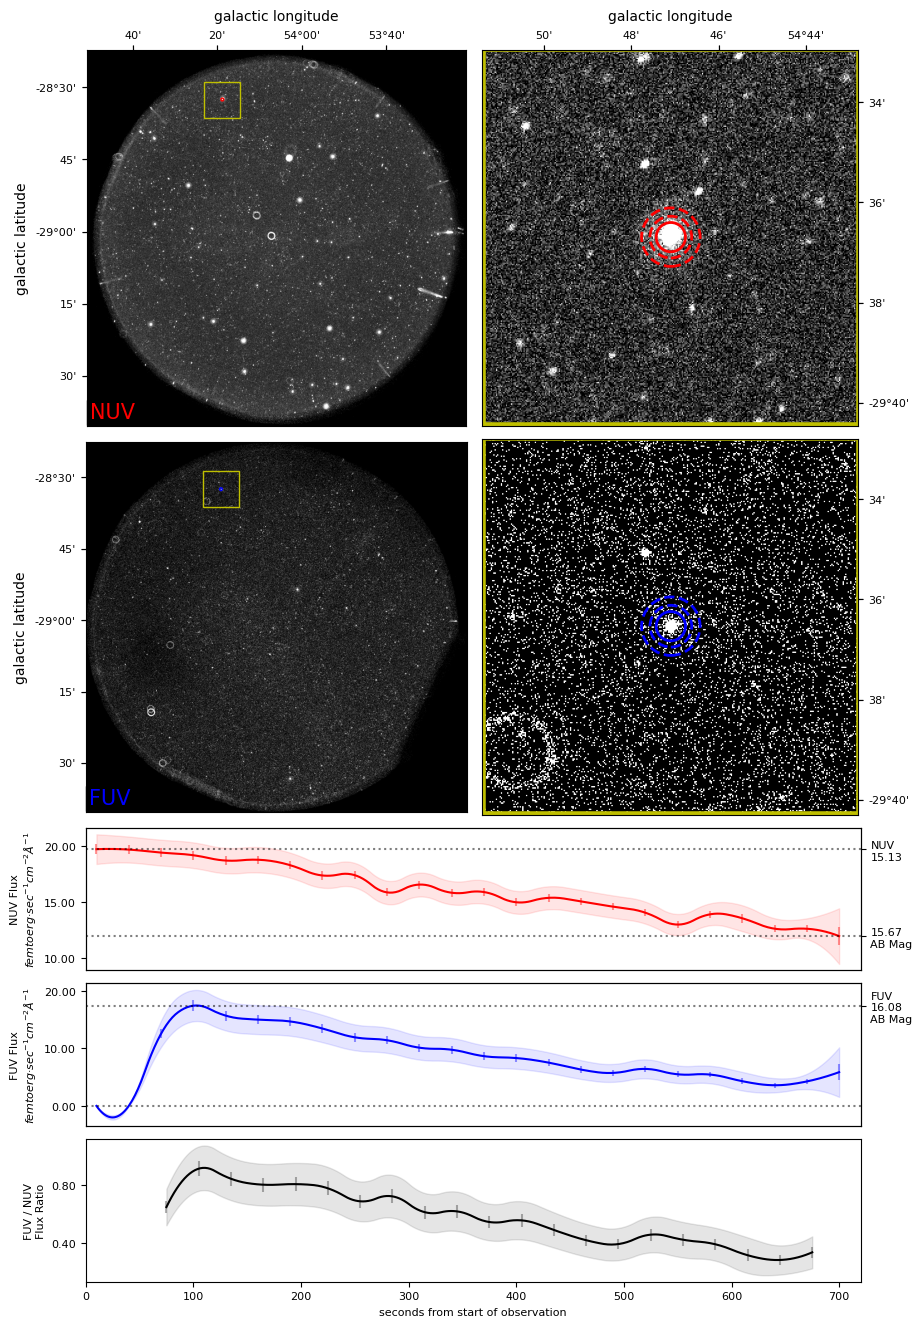

In [12]:
# make final QA plots
for i in [291]:#np.arange(len(tbl)):
    visit = tbl.iloc[i]
    e = visit['eclipse']
    edir = str(e).zfill(5)
    epath = f"../data/lightcurves/e{edir}"
    ra,dec = visit['ra'],visit['dec']
    obs = {}
    for band in ['NUV','FUV']:
        fn = f"{epath}/e{edir}-{band[0].lower()}d-30s-photom-17_5.csv"
        try:
            expt = parse_exposure_time(f"{epath}/e{edir}-{band[0].lower()}d-30s-exptime.csv")
            lcs = parse_lightcurves_csv(fn)
            # a few eclipse have multiple variables, so we have to pick the right one
            ix = np.argmin(angularSeparation(ra,dec,
                           np.array([lc['ra'] for lc in lcs]),
                           np.array([lc['dec'] for lc in lcs])))
            lc = lcs[ix]
        except FileNotFoundError:
            continue
        obs[band] = [lc,expt]

    if not len(obs.keys()):
        print(f"There is no lightcurve data available for {edir}")
        continue
    if len(obs.keys())==1: # only a single band is present
        gs = gridspec.GridSpec(ncols=10,nrows=7)
        fig = plt.figure(figsize=(10,7))
        tmin,tmax = (obs[list(obs.keys())[0]][1]['t0'][0]-15,
                     obs[list(obs.keys())[0]][1]['t0'][-1]+15)
    else:
        gs = gridspec.GridSpec(ncols=10,nrows=16,
                               #wspace=0.01,hspace=0.5,
                              )
        fig = plt.figure(figsize=(10,16))
        tmin,tmax = (min(obs['NUV'][1]['t0'][0],obs['FUV'][1]['t0'][0])-10,
                     max(obs['NUV'][1]['t0'][-1],obs['FUV'][1]['t0'][-1])+20)
    #fig.tight_layout()
    
    for j,k in enumerate(obs.keys()):
        c = 'b' if k=='FUV' else 'r' # set the graphic color for the band
        ra,dec = obs[k][0]['ra'],obs[k][0]['dec']

        imgfilename = f"{epath}/e{edir}-{k[0].lower()}d-full.fits.gz"
        imgmap, _, _, wcs, tranges, exptimes = read_image(imgfilename)
        imgmap[np.where(np.isinf(imgmap))] = 0  # because it pops out with inf values... IDK
        imgmap[np.where(imgmap < 0)] = 0
        
        imgpos = wcs.wcs_world2pix([[lc['ra'],lc['dec']]],1) # set the origin to FITS standard
        imgx,imgy = imgpos[0]
        imsz = np.shape(imgmap)[-2:]
        
        # crop on the subframe
        # noting that image coordinates and numpy coordinates are flipped
        boxsz = 150
        x1, x2, y1, y2 = (max(int(imgy - boxsz), 0),
                          min(int(imgy + boxsz), imsz[0]),
                          max(int(imgx - boxsz), 0),
                          min(int(imgx + boxsz), imsz[1]))

        # Full frame
        offset=0 if j==0 else 5
        ax = fig.add_subplot(gs[offset:5+offset,:5],projection=wcs)
        ##ax.imshow(ZScaleInterval()(imgmap[x1_:x2_, y1_:y2_]), origin="lower", cmap="Greys_r")
        ax.imshow(ZScaleInterval()(imgmap), origin="lower", cmap="Greys_r")
        ax.set_xticks([])
        ax.set_yticks([])
        x1_,y1_=0,0
        rect = Rectangle((y1 - y1_, x1 - x1_), 2 * boxsz, 2 * boxsz,
                         linewidth=1, edgecolor='y', facecolor='none',ls='solid')
        ax.add_patch(rect)
        circ = Circle((y1+boxsz,x1+boxsz), 17.5/1.5,
            linewidth=1, edgecolor=c, facecolor='none', ls='solid')
        ax.add_patch(circ)
        circ = Circle((boxsz, boxsz), 25/1.5,
            linewidth=2, edgecolor=c, facecolor='none', ls='dotted')
        ax.add_patch(circ)
        circ = Circle((boxsz, boxsz), 35/1.5,
            linewidth=2, edgecolor=c, facecolor='none', ls='dotted')
        ax.add_patch(circ)
        ax.text(25, 62, k, color=c, fontsize=15,
           bbox={'facecolor': 'black', 'alpha': 1, 'pad': 2})
        ax.coords[0].set_axislabel('galactic longitude')#, minpad=0.3)
        ax.coords[1].set_axislabel('galactic latitude')#, minpad=-0.4)
        ax.coords[0].set_major_formatter('dd:mm')#:ss.s')
        ax.coords[1].set_major_formatter('dd:mm')
        ax.coords[0].set_ticks(number=6)
        ax.coords[1].set_ticks(number=6)
        ax.coords[0].set_ticks_position('' if j else 't')
        ax.coords[0].set_ticklabel_position('' if j else 't')
        ax.coords[0].set_axislabel_position('' if j else 't')
        ax.coords[1].set_ticks_position('l')
        ax.coords[1].set_ticklabel_position('l')
        ax.coords[1].set_axislabel_position('l')
        ax.coords[0].tick_params(labelsize=8)
        ax.coords[1].tick_params(labelsize=8)
        #ax.xaxis.label.set_fontsize(6)
        #ax.yaxis.label.set_fontsize(6)

        # Thumbnail
        ax = fig.add_subplot(gs[offset:5+offset,5:],projection=wcs)
        ax.imshow(ZScaleInterval()(imgmap[x1:x2, y1:y2]), origin="lower", cmap="Greys_r")
        ax.set_xticks([])
        ax.set_yticks([])
        rect = Rectangle((0,0), 2 * boxsz, 2 * boxsz,
                         linewidth=4, edgecolor='y', facecolor='none',ls='solid')
        ax.add_patch(rect)

        circ = Circle((boxsz, boxsz), 17.5/1.5,
                      linewidth=2, edgecolor=c, facecolor='none', ls='solid')
        ax.add_patch(circ)
        circ = Circle((boxsz, boxsz), 25/1.5,
                      linewidth=2, edgecolor=c, facecolor='none', ls='dashed')
        ax.add_patch(circ)
        circ = Circle((boxsz, boxsz), 35/1.5,
                      linewidth=2, edgecolor=c, facecolor='none', ls='dashed')
        ax.add_patch(circ)
        ax.coords[0].set_axislabel('galactic longitude')#, minpad=0.3)
        ax.coords[1].set_axislabel('galactic latitude')#, minpad=-0.4)
        ax.coords[0].set_major_formatter('dd:mm')#:ss.s')
        ax.coords[1].set_major_formatter('dd:mm')
        ax.coords[0].set_ticks(number=6)
        ax.coords[1].set_ticks(number=6)
        ax.coords[0].set_ticks_position('' if j else 't')
        ax.coords[0].set_ticklabel_position('' if j else 't')
        ax.coords[0].set_axislabel_position('' if j else 't')
        ax.coords[1].set_ticks_position('r')
        ax.coords[1].set_ticklabel_position('r')
        ax.coords[1].set_axislabel_position('')
        ax.coords[0].tick_params(labelsize=8)
        ax.coords[1].tick_params(labelsize=8)


        # Lightcurve
        offset = 10 if len(obs.keys())==2 else 5 # for correct positioning in the gridspec
        ax = fig.add_subplot(gs[offset+j*2:offset+2+j*2,:])
        
        t = np.array(obs[k][1]['t0'])
        flux = counts2flux(obs[k][0]['cps'],k)*10**15
        flux_err = counts2flux(obs[k][0]['cps_err'],k)*10**15
        tix = np.where(np.isfinite(flux))
        X_=np.linspace(t[tix].min(), t[tix].max(), 500)
        interp_model = interp1d(t[tix],
                flux[tix]+3*flux_err[tix],
                kind = "quadratic")
        Y_up=interp_model(X_)
        interp_model = interp1d(t[tix],
                flux[tix]-3*flux_err[tix],
                kind = "quadratic")
        Y_down=interp_model(X_)

        ax.fill_between(X_,
                Y_up,Y_down,
                alpha=0.1,facecolor=c,edgecolor=c)

        ax.errorbar(obs[k][1]['t0'],counts2flux(obs[k][0]['cps'],k)*10**15,
                    yerr=1*counts2flux(obs[k][0]['cps_err'],k)*10**15,
                    fmt=f'none',color=c,label=k,alpha=0.4)
        #ax.errorbar(obs[k][1]['t0'],counts2flux(obs[k][0]['cps'],k)*10**15,
        #            yerr=0*counts2flux(obs[k][0]['cps_err'],k)*10**15,
        #            fmt=f'{c}-',label=k)
        # Plot the curve line of data.
        interp_model = interp1d(t[tix],
                        flux[tix],
                        kind = "quadratic")
        X_=np.linspace(t[tix].min(), t[tix].max(), 500)
        Y_=interp_model(X_)
        plt.plot(X_,Y_,f'{c}-')
        
        # draw a line for the background flux
        #plt.hlines([tbl.iloc[i][f'skybg_flux_{k}']],
        #           tmin,tmax,
        #           linestyle='dashed',color='k',alpha=0.2)
        
        ax.set_xlim([tmin,tmax])
        ax.set_xticks([])
        ax.set_ylabel(f'{k} Flux\n'+r'$femtoerg·sec^{-1}cm^{-2}Å^{-1}$')
        ax.yaxis.set_major_formatter(FormatStrFormatter('%0.2f'))
        ax.yaxis.set_major_locator(MaxNLocator(3))
        ax.xaxis.label.set_fontsize(8)
        ax.yaxis.label.set_fontsize(8)
        ax.tick_params(labelsize=8)
        ax.hlines([np.nanmin(counts2flux(obs[k][0]['cps'],k)*10**15),
                   np.nanmax(counts2flux(obs[k][0]['cps'],k)*10**15)],
                  tmin,tmax,
                  linestyle='dotted',color='k',alpha=0.5)
        # put the mean ab magnitude on the right side of the plot
        ax_ = ax.twinx()
        ax_.tick_params(labelsize=8)
        ax_.set_ylim(ax.get_ybound())
        if np.nanmin(obs[k][0]['cps'])!=0:
            ax_.set_yticks([np.nanmin(counts2flux(obs[k][0]['cps'],k)*10**15),
                            np.nanmax(counts2flux(obs[k][0]['cps'],k)*10**15)])
            ax_.set_yticklabels([f"{np.round(counts2mag(np.nanmin(obs[k][0]['cps']),k),2)}\nAB Mag",
                                 f"{k}\n{np.round(counts2mag(np.nanmax(obs[k][0]['cps']),k),2)}"])
        else: # the minimum in this band is actually zero, which has no valid mag
            ax_.set_yticks([np.nanmax(counts2flux(obs[k][0]['cps'],k)*10**15)])
            ax_.set_yticklabels([f"{k}\n{np.round(counts2mag(np.nanmax(obs[k][0]['cps']),k),2)}\nAB Mag"])
    
    # the ratio plots
    if len(obs.keys())==2:
        ax = fig.add_subplot(gs[14:,:])
        _,ix,_ = np.intersect1d(obs['NUV'][1]['t0'],obs['FUV'][1]['t0'],return_indices=True)
        # we chop the last bin because a low exposure last bin can dominate the plot
        color = (counts2flux(obs['FUV'][0]['cps'],'FUV')[ix][:-1] /
                 counts2flux(obs['NUV'][0]['cps'],'NUV')[ix][:-1])
        color_err = color * np.sqrt(
            (counts2flux(obs['NUV'][0]['cps_err'],'NUV')[ix][:-1] /
             counts2flux(obs['NUV'][0]['cps'],    'NUV')[ix][:-1])**2 +
            (counts2flux(obs['FUV'][0]['cps_err'],'FUV')[ix][:-1] /
             counts2flux(obs['FUV'][0]['cps'],    'FUV')[ix][:-1])**2)
        t = np.array(obs['NUV'][1]['t0'])[ix][:-1]-np.nanmin(np.array(obs['NUV'][1]['t0'])[ix][:-1])+15
        tix = np.where(np.isfinite(color) & np.isfinite(color_err))
        X_=np.linspace(t[tix].min(), t[tix].max(), 500)

        # Plot the curved envelope
        interp_model = interp1d(t[tix],
                        color[tix]+3*color_err[tix],
                        kind = "quadratic")
        Y_up=interp_model(X_)
        interp_model = interp1d(t[tix],
                color[tix]-3*color_err[tix],
                kind = "quadratic")
        Y_down=interp_model(X_)

        ax.fill_between(X_,
                Y_up,Y_down,
                alpha=0.1,facecolor='k',edgecolor='k')

        ax.errorbar(t,
                    color,yerr=1*color_err,fmt='none',color='k',alpha=0.3)

        # Plot the curve line of data.
        interp_model = interp1d(t[tix],
                        color[tix],
                        kind = "quadratic")
        X_=np.linspace(t[tix].min(), t[tix].max(), 500)
        Y_=interp_model(X_)
        plt.plot(X_,Y_,'k-')
        
        ax.set_xlim([tmin-tmin,tmax-tmin])
        ax.set_xlabel('seconds from start of observation')
        #ax.set_xticks([])
        #ax.set_yticks([])
        ax.set_ylabel('FUV / NUV\nFlux Ratio')
        ax.yaxis.set_major_formatter(FormatStrFormatter('%0.2f'))
        ax.yaxis.set_major_locator(MaxNLocator(3))
        ax.yaxis.label.set_fontsize(8)
        #ax.yaxis.tick_right()
        #ax.yaxis.set_label_position("right")
        ax.xaxis.label.set_fontsize(8)
        ax.yaxis.label.set_fontsize(8)
        ax.tick_params(labelsize=8)
    
    plot_fn=f'../data/final_qa_plots/gfcat_{edir}_{str(i).zfill(4)}.jpg'
    #plt.savefig(plot_fn,bbox_inches='tight', pad_inches=0.1, dpi=500)
    #plt.close('all')

In [5]:
for i in np.arange(len(tbl)):
    nbands = sum([tbl.iloc[i]['mag_mean_NUV']!='--',tbl.iloc[i]['mag_mean_FUV']!='--'])
    if nbands==1:
        whichband = 'FUV' if tbl.iloc[i]['mag_mean_NUV']=='--' else 'NUV'
    # Auto generate a caption for the QA image from the table data.
    c1 = f"""This object at RA={np.around(tbl.iloc[i]['ra'],3)}°, Dec={np.round(tbl.iloc[i]['dec'],3)}°
was cleanly observed in {'both bands' if nbands==2 else whichband} on {tbl.iloc[i]['datetime_iso'][:-9]} during eclipse {tbl.iloc[i]['eclipse']}.""".replace('\n',' ')
    morphkey = {'T':'trending','F':'flaring','E':'eclipsing','U':'unknown'}
    c4 = f"""It was tagged as type \"{morphkey[tbl.iloc[i]['morphology']]}\" during manual review, based only on the single-visit lightcurve morphology."""
    if tbl.iloc[i]['simbad_otype']=='--':
        c2 = f"""There is not a good match to any source in SIMBAD."""
    else:
        c2 = f"""Likely matching sources in SIMBAD with known type have type {tbl.iloc[i]['simbad_otype'].replace(',',' or')}."""
    if tbl.iloc[i]['simbad_n_match']==0 and tbl.iloc[i]['gaia_n_match']==0:
        c2 = ''
        c3 = f"""There are no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia."""
        c5 = f"""The nearest matching Gaia source is at a distance of {np.round(tbl.iloc[i]['distance']/1000,3)}"""
    else:
        c3 = f"""The best matched distance is {np.round(tbl.iloc[i]['distance']/1000,3)} kpc."""
        c5 = f"""There are {tbl.iloc[i]['simbad_n_match']} matching SIMBAD sources and {tbl.iloc[i]['gaia_n_match']} Gaia sources within 12.5" of the GALEX source position."""
    autocaption = str(' ').join([c1,c4,c2,c3,c5]).replace('  ',' ')
    print(autocaption)

This object at RA=1.013°, Dec=-4.693° was cleanly observed in NUV on 2009-09-17 during eclipse 34085. It was tagged
as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Variable*. The best matched distance is 2.559 kpc. There are 1 matching
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=2.249°, Dec=23.643° was cleanly observed in NUV on 2009-09-27 during eclipse 34227. It was tagged
as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type **. The best matched distance is 0.259 kpc. There are 1 matching SIMBAD
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=2.427°, Dec=-0.563° was cleanly observed in both bands on 2008-08-30 during eclipse 28485. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 25.381 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=2.706°, Dec=-0.649° was cleanly observed in both bands on 2008-08-30 during eclipse 28486. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.221 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=4.049°, Dec=-39.456° was cleanly observed in both bands on 2005-11-26 during eclipse 13770. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 5.546 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=4.049°, Dec=-39.456° was cleanly observed in both bands on 2005-11-27 during eclipse 13786. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 5.546 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=4.049°, Dec=-39.456° was cleanly observed in NUV on 2005-11-28 during eclipse 13794. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 5.546 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=4.049°, Dec=-39.456° was cleanly observed in both bands on 2005-11-26 during eclipse 13778. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 5.546 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=4.088°, Dec=16.646° was cleanly observed in both bands on 2007-09-11 during eclipse 23321. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.106 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=4.343°, Dec=16.51° was cleanly observed in both bands on 2007-09-08 during eclipse 23279. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star or X. The best matched distance is 0.081 kpc. There are 3
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=4.597°, Dec=16.862° was cleanly observed in both bands on 2007-09-10 during eclipse 23300. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.169 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=4.655°, Dec=16.345° was cleanly observed in both bands on 2007-09-08 during eclipse 23279. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star. The best matched distance is 1.893 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=4.709°, Dec=16.251° was cleanly observed in both bands on 2007-09-11 during eclipse 23324. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.556 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=4.722°, Dec=-11.209° was cleanly observed in both bands on 2003-09-19 during eclipse 2101. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy. The best matched distance is 0.78 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=4.892°, Dec=-1.176° was cleanly observed in both bands on 2008-08-31 during eclipse 28507. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.348 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=4.894°, Dec=-23.165° was cleanly observed in NUV on 2005-09-12 during eclipse 12676. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.164 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=4.955°, Dec=-36.772° was cleanly observed in both bands on 2004-09-29 during eclipse 7589. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.299 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=5.075°, Dec=-0.591° was cleanly observed in both bands on 2007-10-28 during eclipse 24003. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 7.981 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=5.298°, Dec=-8.695° was cleanly observed in both bands on 2007-09-09 during eclipse 23288. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.038 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=6.269°, Dec=-36.772° was cleanly observed in both bands on 2004-10-04 during eclipse 7665. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.02 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=6.305°, Dec=4.199° was cleanly observed in both bands on 2004-10-02 during eclipse 7637. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.26

This object at RA=6.434°, Dec=17.081° was cleanly observed in both bands on 2004-10-23 during eclipse 7940. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.133 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=6.717°, Dec=42.834° was cleanly observed in both bands on 2005-11-08 during eclipse 13511. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.04 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=7.213°, Dec=41.141° was cleanly observed in both bands on 2005-11-08 during eclipse 13503. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.36

This object at RA=7.327°, Dec=-44.649° was cleanly observed in NUV on 2005-09-04 during eclipse 12560. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.503 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=7.666°, Dec=-38.166° was cleanly observed in NUV on 2011-09-13 during eclipse 44690. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.043 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=7.707°, Dec=-42.048° was cleanly observed in both bands on 2007-08-21 during eclipse 23019. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.068 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=7.708°, Dec=-71.845° was cleanly observed in both bands on 2006-10-08 during eclipse 18380. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.42 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.403°, Dec=-43.821° was cleanly observed in both bands on 2004-09-17 during eclipse 7417. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Variable*. The best matched distance is 0.415 
kpc. There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.403°, Dec=-43.821° was cleanly observed in both bands on 2004-10-28 during eclipse 8017. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Variable*. The best matched distance is 0.415 
kpc. There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.403°, Dec=-43.821° was cleanly observed in both bands on 2004-12-05 during eclipse 8569. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Variable*. The best matched distance is 0.415 
kpc. There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.403°, Dec=-43.821° was cleanly observed in both bands on 2004-09-24 during eclipse 7524. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Variable*. The best matched distance is 0.415 
kpc. There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.403°, Dec=-43.821° was cleanly observed in both bands on 2004-09-24 during eclipse 7518. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Variable*. The best matched distance is 0.415 
kpc. There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.403°, Dec=-43.821° was cleanly observed in both bands on 2005-10-12 during eclipse 13112. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Variable*. The best matched distance is 0.415 
kpc. There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.403°, Dec=-43.821° was cleanly observed in both bands on 2004-12-05 during eclipse 8570. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Variable*. The best matched distance is 0.415 
kpc. There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.403°, Dec=-43.821° was cleanly observed in both bands on 2004-09-23 during eclipse 7512. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Variable*. The best matched distance is 0.415 
kpc. There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.403°, Dec=-43.821° was cleanly observed in both bands on 2004-10-27 during eclipse 8003. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Variable*. The best matched distance is 0.415 
kpc. There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.403°, Dec=-43.821° was cleanly observed in both bands on 2004-10-26 during eclipse 7987. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Variable*. The best matched distance is 0.415 
kpc. There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.403°, Dec=-43.821° was cleanly observed in both bands on 2004-09-11 during eclipse 7331. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Variable*. The best matched distance is 0.415 
kpc. There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.543°, Dec=-12.149° was cleanly observed in both bands on 2007-10-29 during eclipse 24029. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Star. The best matched distance is 0.392 kpc. There are 
3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.544°, Dec=-44.084° was cleanly observed in both bands on 2004-09-24 during eclipse 7518. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.101 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=8.677°, Dec=-8.255° was cleanly observed in both bands on 2004-10-01 during eclipse 7628. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.729

This object at RA=8.813°, Dec=-2.441° was cleanly observed in both bands on 2008-09-12 during eclipse 28681. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO or blue. The best matched distance is 0.296 kpc. There are
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=9.029°, Dec=-34.215° was cleanly observed in both bands on 2004-12-08 during eclipse 8610. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.161 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=9.065°, Dec=1.389° was cleanly observed in both bands on 2008-09-11 during eclipse 28668. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type SB*. The best matched distance is 1.502 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=9.15°, Dec=42.305° was cleanly observed in NUV on 2009-08-21 during eclipse 33691. It was tagged 
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type EclBin or Star. The best matched distance is 0.126 kpc. There are 2 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=9.268°, Dec=42.41° was cleanly observed in NUV on 2011-08-06 during eclipse 44133. It was tagged 
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type HighPM* or Star. The best matched distance is 0.069 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=9.269°, Dec=42.41° was cleanly observed in NUV on 2009-10-10 during eclipse 34416. It was tagged 
as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type HighPM* or Star. The best matched distance is 0.069 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=9.51°, Dec=3.684° was cleanly observed in both bands on 2008-09-09 during eclipse 28641. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.885 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=9.619°, Dec=-41.822° was cleanly observed in both bands on 2005-12-02 during eclipse 13856. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.15 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=9.79°, Dec=0.67° was cleanly observed in both bands on 2004-10-29 during eclipse 8030. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN_Candidate or PulsV*. The best matched distance is 2.168 
kpc. There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=9.866°, Dec=-44.523° was cleanly observed in both bands on 2004-09-23 during eclipse 7500. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.102 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.27°, Dec=42.651° was cleanly observed in both bands on 2007-09-25 during eclipse 23521. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.32 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.288°, Dec=41.927° was cleanly observed in both bands on 2007-09-25 during eclipse 23519. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.169 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.346°, Dec=-42.078° was cleanly observed in both bands on 2008-11-03 during eclipse 29443. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.609 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.359°, Dec=42.549° was cleanly observed in NUV on 2009-11-16 during eclipse 34960. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 1.068 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.47°, Dec=41.037° was cleanly observed in both bands on 2007-09-18 during eclipse 23418. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type MolCld or Nova or Star. The best matched distance is 0.346 
kpc. There are 0 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.621°, Dec=-44.416° was cleanly observed in both bands on 2004-12-04 during eclipse 8565. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or HighPM* or X. The best matched distance is 0.061 
kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.621°, Dec=-44.416° was cleanly observed in both bands on 2004-09-17 during eclipse 7416. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or HighPM* or X. The best matched distance is 0.061 
kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.621°, Dec=-44.416° was cleanly observed in both bands on 2004-10-22 during eclipse 7927. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or HighPM* or X. The best matched distance is 0.061 
kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.702°, Dec=35.549° was cleanly observed in both bands on 2005-11-06 during eclipse 13476. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type SB* or Star. The best matched distance is 0.022 kpc. There are
2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.871°, Dec=42.388° was cleanly observed in both bands on 2007-09-16 during eclipse 23389. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.236 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.922°, Dec=-42.348° was cleanly observed in both bands on 2008-10-31 during eclipse 29390. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.581 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in both bands on 2004-09-17 during eclipse 7416. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in NUV on 2005-09-17 during eclipse 12753. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in both bands on 2004-09-17 during eclipse 7422. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in NUV on 2004-09-09 during eclipse 7297. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in both bands on 2003-10-26 during eclipse 2648. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in both bands on 2004-09-16 during eclipse 7407. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in both bands on 2005-10-13 during eclipse 13129. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in both bands on 2005-10-13 during eclipse 13121. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in both bands on 2003-10-26 during eclipse 2640. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in both bands on 2004-07-18 during eclipse 6530. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in both bands on 2004-09-23 during eclipse 7500. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in both bands on 2004-10-28 during eclipse 8016. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in both bands on 2004-10-22 during eclipse 7930. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.949°, Dec=-44.859° was cleanly observed in both bands on 2004-09-23 during eclipse 7511. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.95°, Dec=-44.859° was cleanly observed in both bands on 2004-09-24 during eclipse 7516. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.95°, Dec=-44.859° was cleanly observed in NUV on 2003-10-26 during eclipse 2639. It was tagged
as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 matching 
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.95°, Dec=-44.859° was cleanly observed in both bands on 2004-10-27 during eclipse 8002. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.95°, Dec=-44.859° was cleanly observed in both bands on 2004-10-25 during eclipse 7969. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.95°, Dec=-44.859° was cleanly observed in both bands on 2004-10-26 during eclipse 7990. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=10.951°, Dec=42.282° was cleanly observed in both bands on 2007-09-25 during eclipse 23521. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star or delSctV*. The best matched distance is 0.38 kpc. There
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.016°, Dec=42.677° was cleanly observed in NUV on 2011-08-09 during eclipse 44178. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.22 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.063°, Dec=-45.004° was cleanly observed in both bands on 2004-10-25 during eclipse 7967. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.097 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.063°, Dec=-45.004° was cleanly observed in both bands on 2004-12-04 during eclipse 8564. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.097 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.064°, Dec=-45.004° was cleanly observed in both bands on 2004-09-23 during eclipse 7500. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.097 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.064°, Dec=-45.004° was cleanly observed in both bands on 2004-09-24 during eclipse 7520. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.097 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.073°, Dec=40.446° was cleanly observed in NUV on 2009-10-06 during eclipse 34357. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star or X. The best matched distance is 0.259 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.086°, Dec=39.898° was cleanly observed in NUV on 2009-10-02 during eclipse 34300. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.441 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.164°, Dec=39.909° was cleanly observed in NUV on 2009-10-14 during eclipse 34477. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.26 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.166°, Dec=39.924° was cleanly observed in both bands on 2008-08-28 during eclipse 28459. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.967

This object at RA=11.207°, Dec=40.317° was cleanly observed in both bands on 2008-08-28 during eclipse 28459. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.281 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.237°, Dec=-43.397° was cleanly observed in both bands on 2003-09-30 during eclipse 2259. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.265 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.343°, Dec=-1.08° was cleanly observed in both bands on 2007-09-24 during eclipse 23507. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.362 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.389°, Dec=40.456° was cleanly observed in NUV on 2011-08-10 during eclipse 44190. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.338 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.442°, Dec=41.841° was cleanly observed in NUV on 2009-08-31 during eclipse 33838. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Cepheid or ClassicalCep or Cluster* or Star or 
Variable*. The best matched distance is 0.296 kpc. There are 5 matching SIMBAD sources and 1 Gaia sources within 
12.5" of the GALEX source position.

This object at RA=11.442°, Dec=41.841° was cleanly observed in NUV on 2010-08-21 during eclipse 39025. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Cepheid or ClassicalCep or Cluster* or Star or 
Variable*. The best matched distance is 0.296 kpc. There are 5 matching SIMBAD sources and 1 Gaia sources within 
12.5" of the GALEX source position.

This object at RA=11.442°, Dec=41.841° was cleanly observed in NUV on 2009-10-12 during eclipse 34446. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Cepheid or ClassicalCep or Cluster* or Star or 
Variable*. The best matched distance is 0.296 kpc. There are 5 matching SIMBAD sources and 1 Gaia sources within 
12.5" of the GALEX source position.

This object at RA=11.451°, Dec=-43.92° was cleanly observed in both bands on 2006-09-06 during eclipse 17918. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.355 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.451°, Dec=-43.92° was cleanly observed in NUV on 2005-09-08 during eclipse 12620. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.355 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.451°, Dec=-43.92° was cleanly observed in both bands on 2003-10-11 during eclipse 2433. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.355 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.451°, Dec=-43.92° was cleanly observed in NUV on 2005-09-18 during eclipse 12759. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.355 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.557°, Dec=-44.202° was cleanly observed in both bands on 2005-11-23 during eclipse 13729. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.241 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.558°, Dec=-44.202° was cleanly observed in both bands on 2005-12-07 during eclipse 13926. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.241 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.674°, Dec=-42.362° was cleanly observed in both bands on 2007-11-10 during eclipse 24203. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.707 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.772°, Dec=41.056° was cleanly observed in NUV on 2009-10-14 during eclipse 34475. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type GlobCluster_Candidate or Star. The best matched distance is 
0.464 kpc. There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=11.893°, Dec=40.781° was cleanly observed in NUV on 2009-11-20 during eclipse 35016. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.637

This object at RA=11.963°, Dec=-41.369° was cleanly observed in both bands on 2007-11-12 during eclipse 24230. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.299 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=12.03°, Dec=40.478° was cleanly observed in NUV on 2009-10-21 during eclipse 34581. It was tagged
as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Star. The best matched distance is 0.715 kpc. There are 1 matching 
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=12.224°, Dec=42.184° was cleanly observed in NUV on 2009-09-01 during eclipse 33855. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 2.379 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=12.283°, Dec=-40.388° was cleanly observed in NUV on 2011-09-11 during eclipse 44662. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.574 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=12.451°, Dec=42.337° was cleanly observed in both bands on 2008-09-16 during eclipse 28740. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.173 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=12.621°, Dec=39.175° was cleanly observed in both bands on 2006-09-14 during eclipse 18037. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 3.712 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=12.811°, Dec=41.695° was cleanly observed in NUV on 2009-10-15 during eclipse 34495. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.565 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=13.115°, Dec=0.099° was cleanly observed in both bands on 2007-09-24 during eclipse 23505. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.123 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=13.246°, Dec=12.163° was cleanly observed in both bands on 2004-11-06 during eclipse 8147. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EllipVar or Galaxy. The best matched distance is 0.085 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=13.543°, Dec=5.158° was cleanly observed in both bands on 2008-09-20 during eclipse 28798. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.054 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=13.779°, Dec=-0.951° was cleanly observed in both bands on 2004-11-03 during eclipse 8108. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.183 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=14.075°, Dec=12.494° was cleanly observed in both bands on 2004-10-09 during eclipse 7743. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.104 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=14.075°, Dec=12.494° was cleanly observed in both bands on 2004-10-11 during eclipse 7764. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.104 kpc. There are 0 matching SIMBAD sources 
and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=14.659°, Dec=0.294° was cleanly observed in both bands on 2007-10-29 during eclipse 24017. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star. The best matched distance is 0.118 kpc. There 
are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=14.751°, Dec=40.975° was cleanly observed in both bands on 2005-11-08 during eclipse 13507. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.399 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=15.089°, Dec=-2.153° was cleanly observed in both bands on 2008-10-05 during eclipse 29010. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.514 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=15.107°, Dec=42.311° was cleanly observed in both bands on 2005-11-08 during eclipse 13513. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.088 kpc. 
There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=15.127°, Dec=0.892° was cleanly observed in both bands on 2007-11-10 during eclipse 24197. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass* or QSO. The best matched distance is 0.773 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=15.643°, Dec=3.433° was cleanly observed in both bands on 2008-10-02 during eclipse 28970. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.578

This object at RA=15.773°, Dec=11.743° was cleanly observed in NUV on 2011-11-11 during eclipse 45558. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.157 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=16.654°, Dec=45.39° was cleanly observed in both bands on 2005-11-10 during eclipse 13533. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.801

This object at RA=17.344°, Dec=-1.055° was cleanly observed in both bands on 2007-10-07 during eclipse 23695. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.13 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=17.672°, Dec=-36.825° was cleanly observed in both bands on 2003-10-10 during eclipse 2414. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RotV*. The best matched distance is 0.149 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=17.676°, Dec=13.635° was cleanly observed in both bands on 2008-10-11 during eclipse 29105. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.28 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=17.711°, Dec=-46.004° was cleanly observed in both bands on 2004-09-11 during eclipse 7326. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.043 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=17.711°, Dec=-46.004° was cleanly observed in both bands on 2004-09-11 during eclipse 7327. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.043 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=17.85°, Dec=0.16° was cleanly observed in NUV on 2010-09-27 during eclipse 39556. It was tagged 
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type **. The best matched distance is 0.562 kpc. There are 1 matching SIMBAD
sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=17.909°, Dec=-46.125° was cleanly observed in NUV on 2004-09-07 during eclipse 7274. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.153 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=18.546°, Dec=1.501° was cleanly observed in NUV on 2010-09-28 during eclipse 39569. It was tagged
as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type **. The best matched distance is 1.531 kpc. There are 1 matching SIMBAD
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=19.523°, Dec=-75.191° was cleanly observed in both bands on 2007-06-26 during eclipse 22197. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 11.274 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=19.603°, Dec=34.751° was cleanly observed in both bands on 2005-11-06 during eclipse 13484. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. There 
are no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia 
source is at a distance of 0.417

This object at RA=19.666°, Dec=11.856° was cleanly observed in both bands on 2004-11-13 during eclipse 8256. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type YSO_Candidate. The best matched distance is 0.161 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=20.407°, Dec=12.513° was cleanly observed in both bands on 2005-11-04 during eclipse 13451. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin_Candidate. The best matched distance is 4.039 kpc. 
There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=20.853°, Dec=-25.774° was cleanly observed in NUV on 2011-10-30 during eclipse 45371. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 2.469 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=21.128°, Dec=-33.918° was cleanly observed in both bands on 2003-10-11 during eclipse 2419. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.025 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=21.485°, Dec=-35.721° was cleanly observed in both bands on 2004-09-26 during eclipse 7549. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.146 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=21.581°, Dec=-31.119° was cleanly observed in NUV on 2011-11-17 during eclipse 45643. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.544 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=21.899°, Dec=-75.764° was cleanly observed in NUV on 2006-07-05 during eclipse 16997. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.256 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=21.943°, Dec=-1.007° was cleanly observed in NUV on 2009-10-24 during eclipse 34620. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy. The best matched distance is 0.083 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=21.957°, Dec=-28.895° was cleanly observed in both bands on 2004-09-26 during eclipse 7545. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.476

This object at RA=22.303°, Dec=-22.228° was cleanly observed in both bands on 2004-09-25 during eclipse 7532. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Variable*. The best matched distance is 0.549 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=23.533°, Dec=-13.833° was cleanly observed in NUV on 2010-12-07 during eclipse 40599. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 1.219 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=23.671°, Dec=-1.151° was cleanly observed in both bands on 2008-10-18 during eclipse 29202. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.222 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=24.152°, Dec=-17.789° was cleanly observed in both bands on 2005-11-19 during eclipse 13662. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Variable*. The best matched distance is 0.088 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=24.231°, Dec=7.275° was cleanly observed in both bands on 2004-11-16 during eclipse 8298. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.731 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=24.293°, Dec=-17.551° was cleanly observed in both bands on 2005-11-18 during eclipse 13648. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.241 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=24.565°, Dec=-17.673° was cleanly observed in both bands on 2005-11-19 during eclipse 13664. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type SB*. The best matched distance is 0.654 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=24.762°, Dec=-17.95° was cleanly observed in both bands on 2005-11-18 during eclipse 13649. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Eruptive*. The best matched distance is 0.003 kpc. There
are 0 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=24.762°, Dec=-17.95° was cleanly observed in both bands on 2005-11-19 during eclipse 13673. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Eruptive*. The best matched distance is 0.003 kpc. There
are 0 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=24.762°, Dec=-17.95° was cleanly observed in both bands on 2005-11-18 during eclipse 13655. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Eruptive*. The best matched distance is 0.003 kpc. There
are 0 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=24.762°, Dec=-17.95° was cleanly observed in both bands on 2005-11-18 during eclipse 13648. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Eruptive*. The best matched distance is 0.003 kpc. There
are 0 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=24.762°, Dec=-17.95° was cleanly observed in both bands on 2005-11-19 during eclipse 13664. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Eruptive*. The best matched distance is 0.003 kpc. There
are 0 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=24.763°, Dec=-17.95° was cleanly observed in both bands on 2005-11-19 during eclipse 13662. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Eruptive*. The best matched distance is 0.003 kpc. There
are 0 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=24.763°, Dec=-17.949° was cleanly observed in both bands on 2005-11-18 during eclipse 13656. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Eruptive*. The best matched distance is 0.003 kpc. There
are 0 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=24.979°, Dec=7.53° was cleanly observed in both bands on 2004-11-17 during eclipse 8305. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.245 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=25.112°, Dec=-10.64° was cleanly observed in both bands on 2004-12-13 during eclipse 8686. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.202 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=25.245°, Dec=34.078° was cleanly observed in NUV on 2011-11-21 during eclipse 45702. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.087 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=25.491°, Dec=-26.216° was cleanly observed in NUV on 2011-10-31 during eclipse 45386. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 6.887 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=25.834°, Dec=4.32° was cleanly observed in both bands on 2007-11-01 during eclipse 24067. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.011 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=27.571°, Dec=31.047° was cleanly observed in NUV on 2011-11-23 during eclipse 45730. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.149 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=28.147°, Dec=13.666° was cleanly observed in both bands on 2008-10-13 during eclipse 29129. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.093 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=28.797°, Dec=70.141° was cleanly observed in NUV on 2011-01-02 during eclipse 40986. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.235 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=29.063°, Dec=0.102° was cleanly observed in NUV on 2010-12-02 during eclipse 40521. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Galaxy or HighPM*. The best matched distance is 0.03 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=29.063°, Dec=0.102° was cleanly observed in NUV on 2010-12-03 during eclipse 40536. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Galaxy or HighPM*. The best matched distance is 0.03 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=29.197°, Dec=-0.354° was cleanly observed in both bands on 2008-10-20 during eclipse 29237. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.07 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=29.197°, Dec=-0.354° was cleanly observed in NUV on 2010-12-02 during eclipse 40521. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.07 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=29.197°, Dec=-0.354° was cleanly observed in NUV on 2010-12-01 during eclipse 40518. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.07 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=29.393°, Dec=-74.177° was cleanly observed in both bands on 2004-10-30 during eclipse 8042. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 2.161

This object at RA=29.396°, Dec=13.89° was cleanly observed in both bands on 2003-10-15 during eclipse 2480. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HorBranch*. The best matched distance is 0.286 kpc. There are 
0 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=29.682°, Dec=35.257° was cleanly observed in NUV on 2011-11-23 during eclipse 45729. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=29.787°, Dec=27.907° was cleanly observed in NUV on 2010-11-29 during eclipse 40488. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.149 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=29.951°, Dec=8.794° was cleanly observed in NUV on 2011-10-31 during eclipse 45391. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a good 
match to any source in SIMBAD. The best matched distance is 0.137 kpc. There are 0 matching SIMBAD sources and 2 
Gaia sources within 12.5" of the GALEX source position.

This object at RA=30.406°, Dec=-8.117° was cleanly observed in both bands on 2003-10-14 during eclipse 2476. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.089 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=30.823°, Dec=-5.368° was cleanly observed in NUV on 2010-11-15 during eclipse 40273. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.501

This object at RA=30.96°, Dec=-5.896° was cleanly observed in NUV on 2010-11-12 during eclipse 40235. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.076 kpc. There are 1 matching 
SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=31.334°, Dec=-5.812° was cleanly observed in NUV on 2009-12-13 during eclipse 35351. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.438 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=31.754°, Dec=-5.245° was cleanly observed in NUV on 2009-11-17 during eclipse 34977. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.094 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=32.318°, Dec=10.872° was cleanly observed in both bands on 2004-10-13 during eclipse 7793. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.32 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=32.663°, Dec=-5.843° was cleanly observed in NUV on 2010-10-25 during eclipse 39965. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy. The best matched distance is 0.058 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=32.752°, Dec=-3.669° was cleanly observed in NUV on 2010-12-07 during eclipse 40601. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.252 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=33.13°, Dec=-29.532° was cleanly observed in NUV on 2011-11-12 during eclipse 45559. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.454

This object at RA=33.23°, Dec=0.909° was cleanly observed in both bands on 2008-10-23 during eclipse 29274. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.087 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=33.553°, Dec=-3.963° was cleanly observed in both bands on 2005-11-17 during eclipse 13638. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.012 kpc. There 
are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=33.554°, Dec=-3.963° was cleanly observed in both bands on 2006-10-27 during eclipse 18663. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.012 kpc. There 
are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=34.215°, Dec=-5.376° was cleanly observed in both bands on 2006-10-27 during eclipse 18667. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG. The best matched distance is 0.574 kpc. There are 3
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=34.625°, Dec=-4.921° was cleanly observed in NUV on 2010-11-04 during eclipse 40121. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or smmRad. The best matched distance is 0.091 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=34.625°, Dec=-4.921° was cleanly observed in both bands on 2006-11-10 during eclipse 18869. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or smmRad. The best matched distance is 0.091 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=34.671°, Dec=-5.883° was cleanly observed in both bands on 2005-11-17 during eclipse 13642. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or RRLyrae. The best matched distance is 1.251 kpc. 
There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=34.795°, Dec=-5.308° was cleanly observed in NUV on 2010-11-17 during eclipse 40301. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.026

This object at RA=34.834°, Dec=-5.149° was cleanly observed in NUV on 2010-11-14 during eclipse 40265. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO. The best matched distance is 0.803 kpc. 
There are 2 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=34.845°, Dec=-4.683° was cleanly observed in NUV on 2010-11-16 during eclipse 40298. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Galaxy or QSO. The best matched distance is 0.9 
kpc. There are 2 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=34.942°, Dec=-2.651° was cleanly observed in both bands on 2006-11-14 during eclipse 18933. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.115 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=35.062°, Dec=-3.124° was cleanly observed in both bands on 2006-11-10 during eclipse 18861. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.488 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=35.093°, Dec=-8.141° was cleanly observed in both bands on 2008-10-13 during eclipse 29131. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.025 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=35.187°, Dec=-5.05° was cleanly observed in both bands on 2006-10-13 during eclipse 18456. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star. The best matched distance is 0.4 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=35.331°, Dec=-2.97° was cleanly observed in NUV on 2010-11-10 during eclipse 40198. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Galaxy or Star. The best matched distance is 0.118 kpc. There are 2 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=35.359°, Dec=-3.233° was cleanly observed in NUV on 2010-11-12 during eclipse 40228. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.118 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=35.432°, Dec=-5.276° was cleanly observed in both bands on 2006-11-13 during eclipse 18914. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or HighPM*. The best matched distance is 0.083 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=35.457°, Dec=74.265° was cleanly observed in NUV on 2011-12-31 during eclipse 46287. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.12 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=35.48°, Dec=-5.051° was cleanly observed in both bands on 2006-11-15 during eclipse 18934. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or QSO. The best matched distance is 1.749 kpc. There 
are 2 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=35.494°, Dec=-5.188° was cleanly observed in both bands on 2008-11-01 during eclipse 29407. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.524 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=35.787°, Dec=-30.729° was cleanly observed in both bands on 2007-10-25 during eclipse 23962. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.292 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=35.907°, Dec=-4.669° was cleanly observed in both bands on 2005-10-21 during eclipse 13244. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or QSO. The best matched distance is 3.183 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.049°, Dec=-5.418° was cleanly observed in NUV on 2010-11-02 during eclipse 40088. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.549 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.136°, Dec=-4.511° was cleanly observed in both bands on 2005-10-21 during eclipse 13244. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or QSO or Star. The best matched distance is 0.262 kpc.
There are 7 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.158°, Dec=0.666° was cleanly observed in both bands on 2005-11-04 during eclipse 13450. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.115 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.198°, Dec=-5.741° was cleanly observed in both bands on 2008-11-21 during eclipse 29703. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Star. The best matched distance is 0.116 kpc. There are
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.198°, Dec=-5.741° was cleanly observed in NUV on 2009-11-12 during eclipse 34903. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Star. The best matched distance is 0.116 kpc. There are
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.276°, Dec=-4.48° was cleanly observed in NUV on 2003-12-09 during eclipse 3292. It was tagged 
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Galaxy or Star. The best matched distance is 0.188 kpc. There are 8 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.369°, Dec=-4.261° was cleanly observed in both bands on 2005-10-20 during eclipse 13231. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ClG or EmissionG or Galaxy or GroupG or Radio. The best 
matched distance is 0.488 kpc. There are 21 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX 
source position.

This object at RA=36.392°, Dec=-5.028° was cleanly observed in NUV on 2009-10-26 during eclipse 34656. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star. The best matched distance is 0.164 kpc. There 
are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.401°, Dec=28.097° was cleanly observed in both bands on 2004-11-17 during eclipse 8317. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.306 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.454°, Dec=-3.999° was cleanly observed in both bands on 2005-10-21 during eclipse 13241. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO. The best matched distance is 0.525 kpc. 
There are 13 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.464°, Dec=-4.892° was cleanly observed in both bands on 2007-10-18 during eclipse 23856. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or RRLyrae. The best matched distance is 129.87 kpc. 
There are 13 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.464°, Dec=-4.892° was cleanly observed in both bands on 2005-10-14 during eclipse 13140. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or RRLyrae. The best matched distance is 129.87 kpc. 
There are 12 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.464°, Dec=-4.892° was cleanly observed in NUV on 2003-12-09 during eclipse 3291. It was tagged
as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Galaxy or RRLyrae. The best matched distance is 129.87 kpc. There are 
12 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.529°, Dec=-0.447° was cleanly observed in both bands on 2008-10-12 during eclipse 29126. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.234 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.529°, Dec=-0.447° was cleanly observed in both bands on 2008-10-13 during eclipse 29127. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.234 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.627°, Dec=-4.1° was cleanly observed in both bands on 2007-11-13 during eclipse 24242. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star. The best matched distance is 0.466 kpc. There 
are 11 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.647°, Dec=-5.089° was cleanly observed in both bands on 2006-10-11 during eclipse 18424. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or HighPM*. The best matched distance is 0.118 kpc. 
There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.647°, Dec=-5.089° was cleanly observed in both bands on 2008-11-21 during eclipse 29703. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or HighPM*. The best matched distance is 0.118 kpc. 
There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.722°, Dec=-5.296° was cleanly observed in NUV on 2009-11-14 during eclipse 34932. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or RotV*. The best matched distance is 0.114 kpc. There
are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=36.722°, Dec=-5.296° was cleanly observed in NUV on 2010-11-06 during eclipse 40146. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or RotV*. The best matched distance is 0.114 kpc. There
are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=37.252°, Dec=-41.126° was cleanly observed in both bands on 2005-11-26 during eclipse 13766. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star or WhiteDwarf_Candidate. The best matched 
distance is 0.051 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source 
position.

This object at RA=37.292°, Dec=-4.768° was cleanly observed in NUV on 2010-11-10 during eclipse 40202. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star. The best matched distance is 0.122 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=37.307°, Dec=-10.162° was cleanly observed in NUV on 2009-11-01 during eclipse 34738. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass* or Star. The best matched distance is 0.06 kpc. 
There are 3 matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=37.424°, Dec=-5.788° was cleanly observed in NUV on 2009-12-06 during eclipse 35249. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.798 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=38.656°, Dec=25.575° was cleanly observed in NUV on 2009-10-14 during eclipse 34481. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.625 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=39.982°, Dec=-7.482° was cleanly observed in both bands on 2004-10-21 during eclipse 7911. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.967 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=40.201°, Dec=-7.105° was cleanly observed in both bands on 2004-10-21 during eclipse 7915. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.724 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=41.632°, Dec=-7.354° was cleanly observed in both bands on 2003-11-25 during eclipse 3090. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.12 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=42.67°, Dec=-1.202° was cleanly observed in both bands on 2008-12-17 during eclipse 30076. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.077 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=42.965°, Dec=4.395° was cleanly observed in both bands on 2007-10-23 during eclipse 23940. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 14.859 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=43.229°, Dec=-37.14° was cleanly observed in both bands on 2005-11-15 during eclipse 13613. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.096 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=44.017°, Dec=-0.609° was cleanly observed in both bands on 2004-11-19 during eclipse 8340. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.016 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=45.085°, Dec=-11.295° was cleanly observed in both bands on 2007-10-16 during eclipse 23828. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.271 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=45.472°, Dec=-33.127° was cleanly observed in both bands on 2005-11-16 during eclipse 13621. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.366 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=47.256°, Dec=-15.818° was cleanly observed in both bands on 2007-10-20 during eclipse 23892. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.502 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=47.921°, Dec=-58.066° was cleanly observed in both bands on 2004-12-11 during eclipse 8660. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.891 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=48.029°, Dec=-57.646° was cleanly observed in both bands on 2004-12-09 during eclipse 8633. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.146 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=48.217°, Dec=-7.739° was cleanly observed in both bands on 2008-11-05 during eclipse 29472. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.378 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=48.425°, Dec=-6.862° was cleanly observed in both bands on 2008-11-14 during eclipse 29597. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.036 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=48.535°, Dec=-54.965° was cleanly observed in both bands on 2004-12-09 during eclipse 8625. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 5.784 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=48.782°, Dec=-10.621° was cleanly observed in both bands on 2007-11-14 during eclipse 24257. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.188

This object at RA=49.549°, Dec=-38.184° was cleanly observed in NUV on 2004-11-11 during eclipse 8221. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.236 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=49.839°, Dec=41.522° was cleanly observed in NUV on 2010-11-18 during eclipse 40325. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.479 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=50.022°, Dec=-7.044° was cleanly observed in both bands on 2003-11-28 during eclipse 3126. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.214

This object at RA=50.772°, Dec=0.684° was cleanly observed in both bands on 2008-12-13 during eclipse 30032. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.192 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=51.262°, Dec=-17.214° was cleanly observed in both bands on 2006-11-02 during eclipse 18753. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.527 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=51.866°, Dec=-6.965° was cleanly observed in both bands on 2003-11-29 during eclipse 3141. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RotV*. The best matched distance is 0.26 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=52.042°, Dec=-28.617° was cleanly observed in both bands on 2003-12-04 during eclipse 3211. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 1.641

This object at RA=52.108°, Dec=-28.211° was cleanly observed in both bands on 2003-12-05 during eclipse 3225. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.51 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=52.351°, Dec=-27.548° was cleanly observed in both bands on 2008-11-17 during eclipse 29645. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.105

This object at RA=52.971°, Dec=-27.43° was cleanly observed in NUV on 2010-11-20 during eclipse 40346. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.029

This object at RA=53.009°, Dec=-27.048° was cleanly observed in both bands on 2005-11-02 during eclipse 13415. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.14 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.009°, Dec=-27.048° was cleanly observed in both bands on 2006-10-21 during eclipse 18573. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.14 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.009°, Dec=-27.048° was cleanly observed in both bands on 2005-11-14 during eclipse 13600. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.14 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.009°, Dec=-27.048° was cleanly observed in both bands on 2005-12-13 during eclipse 14021. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.14 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.009°, Dec=-27.048° was cleanly observed in NUV on 2009-12-15 during eclipse 35382. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.14 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.009°, Dec=-27.047° was cleanly observed in both bands on 2008-12-20 during eclipse 30122. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.14 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.009°, Dec=-27.048° was cleanly observed in both bands on 2006-10-20 during eclipse 18565. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.14 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.009°, Dec=-27.048° was cleanly observed in both bands on 2005-11-14 during eclipse 13592. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.14 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.009°, Dec=-27.048° was cleanly observed in NUV on 2010-11-20 during eclipse 40348. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.14 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.065°, Dec=-29.51° was cleanly observed in both bands on 2008-11-17 during eclipse 29643. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type SB*. The best matched distance is 0.468 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.074°, Dec=-27.319° was cleanly observed in NUV on 2009-12-01 during eclipse 35180. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.395

This object at RA=53.169°, Dec=-26.357° was cleanly observed in NUV on 2009-11-09 during eclipse 34856. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.183 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.176°, Dec=-27.951° was cleanly observed in NUV on 2010-11-26 during eclipse 40433. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or HighPM* or Radio or Star or Unknown. The best 
matched distance is 0.071 kpc. There are 31 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX 
source position.

This object at RA=53.207°, Dec=-27.445° was cleanly observed in NUV on 2010-11-22 during eclipse 40386. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.302

This object at RA=53.401°, Dec=-28.822° was cleanly observed in NUV on 2009-12-15 during eclipse 35384. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.395 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.45°, Dec=-27.5° was cleanly observed in both bands on 2005-11-01 during eclipse 13412. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.581 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.513°, Dec=-27.968° was cleanly observed in NUV on 2010-11-24 during eclipse 40415. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.043

This object at RA=53.616°, Dec=-27.206° was cleanly observed in NUV on 2010-11-20 during eclipse 40349. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or RRLyrae. The best matched distance is 10.537 kpc. 
There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.657°, Dec=-27.521° was cleanly observed in NUV on 2010-11-22 during eclipse 40373. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.233 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.658°, Dec=-27.52° was cleanly observed in NUV on 2010-11-26 during eclipse 40441. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.233 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.696°, Dec=-27.614° was cleanly observed in NUV on 2010-12-01 during eclipse 40505. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.252 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.874°, Dec=-28.308° was cleanly observed in both bands on 2006-10-29 during eclipse 18694. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.762 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.942°, Dec=-29.036° was cleanly observed in both bands on 2007-12-24 during eclipse 24845. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.67 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.942°, Dec=-29.036° was cleanly observed in both bands on 2007-12-24 during eclipse 24844. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.67 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.942°, Dec=-29.036° was cleanly observed in both bands on 2007-12-24 during eclipse 24847. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.67 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=53.942°, Dec=-29.037° was cleanly observed in both bands on 2005-10-30 during eclipse 13377. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.67 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in NUV on 2009-12-05 during eclipse 35243. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-10-27 during eclipse 13337. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.545° was cleanly observed in NUV on 2009-12-21 during eclipse 35473. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-10-28 during eclipse 13352. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in NUV on 2009-12-03 during eclipse 35212. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.545° was cleanly observed in both bands on 2006-10-21 during eclipse 18577. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2006-11-23 during eclipse 19051. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2006-10-29 during eclipse 18694. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-11-01 during eclipse 13406. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in NUV on 2009-12-17 during eclipse 35415. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2007-10-10 during eclipse 23744. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2007-12-24 during eclipse 24845. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-10-28 during eclipse 13344. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-11-29 during eclipse 13813. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-11-28 during eclipse 13803. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.545° was cleanly observed in NUV on 2009-12-13 during eclipse 35358. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.545° was cleanly observed in NUV on 2009-12-11 during eclipse 35328. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-11-29 during eclipse 13818. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2008-12-12 during eclipse 30011. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-11-01 during eclipse 13407. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-11-28 during eclipse 13800. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-10-31 during eclipse 13387. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.545° was cleanly observed in both bands on 2005-12-12 during eclipse 14003. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-11-29 during eclipse 13822. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2006-10-16 during eclipse 18502. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2007-12-24 during eclipse 24844. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-10-30 during eclipse 13377. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2006-10-15 during eclipse 18488. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.545° was cleanly observed in NUV on 2009-11-11 during eclipse 34888. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-12-11 during eclipse 13985. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2005-11-13 during eclipse 13581. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2007-12-25 during eclipse 24849. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.545° was cleanly observed in NUV on 2009-11-07 during eclipse 34831. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.544° was cleanly observed in both bands on 2007-10-08 during eclipse 23716. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.314°, Dec=-28.545° was cleanly observed in both bands on 2007-12-24 during eclipse 24847. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.315°, Dec=-28.544° was cleanly observed in both bands on 2007-12-24 during eclipse 24846. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.647 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.387°, Dec=-0.7° was cleanly observed in both bands on 2008-12-15 during eclipse 30051. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.126 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.577°, Dec=-27.376° was cleanly observed in both bands on 2005-10-27 during eclipse 13336. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type SB*. The best matched distance is 0.215 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.577°, Dec=-27.376° was cleanly observed in NUV on 2010-12-02 during eclipse 40525. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type SB*. The best matched distance is 0.215 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.577°, Dec=-27.376° was cleanly observed in NUV on 2009-12-09 during eclipse 35297. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type SB*. The best matched distance is 0.215 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=54.577°, Dec=-27.376° was cleanly observed in NUV on 2010-11-30 during eclipse 40496. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type SB*. The best matched distance is 0.215 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=55.899°, Dec=26.358° was cleanly observed in NUV on 2007-12-05 during eclipse 24567. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or HI. The best matched distance is 0.037 kpc. There
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=55.899°, Dec=26.358° was cleanly observed in NUV on 2007-12-05 during eclipse 24568. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or HI. The best matched distance is 0.037 kpc. There
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=55.947°, Dec=26.634° was cleanly observed in NUV on 2007-12-13 during eclipse 24683. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type YSO_Candidate. The best matched distance is 0.365 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=56.049°, Dec=-22.539° was cleanly observed in both bands on 2007-12-23 during eclipse 24828. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.544

This object at RA=56.432°, Dec=26.083° was cleanly observed in NUV on 2007-12-03 during eclipse 24537. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or FarIR. The best matched distance is 0.107 kpc. 
There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=56.585°, Dec=26.215° was cleanly observed in NUV on 2007-12-04 during eclipse 24555. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.014 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=57.245°, Dec=1.181° was cleanly observed in both bands on 2008-12-09 during eclipse 29971. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RotV*. The best matched distance is 0.11 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=58.968°, Dec=-0.241° was cleanly observed in both bands on 2008-12-16 during eclipse 30072. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.2 kpc. There are 0 matching SIMBAD sources
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=59.804°, Dec=-45.414° was cleanly observed in NUV on 2005-01-26 during eclipse 9329. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.422 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=60.389°, Dec=-5.36° was cleanly observed in both bands on 2004-11-03 during eclipse 8105. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.275 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=61.113°, Dec=20.408° was cleanly observed in NUV on 2010-12-21 during eclipse 40802. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.188 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=61.152°, Dec=-34.253° was cleanly observed in NUV on 2011-01-29 during eclipse 41373. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.103 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=62.789°, Dec=-59.188° was cleanly observed in both bands on 2005-12-03 during eclipse 13872. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*_Candidate or Star or X. The best matched distance is
0.329 kpc. There are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=64.189°, Dec=26.368° was cleanly observed in NUV on 2009-11-11 during eclipse 34889. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 2.162 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=64.206°, Dec=-50.175° was cleanly observed in NUV on 2005-01-26 during eclipse 9330. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.414 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=64.314°, Dec=18.134° was cleanly observed in NUV on 2010-12-26 during eclipse 40874. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.118 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=66.518°, Dec=17.12° was cleanly observed in both bands on 2005-12-19 during eclipse 14103. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 1.859 kpc. There are 1
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=66.518°, Dec=17.12° was cleanly observed in both bands on 2005-12-19 during eclipse 14109. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 1.859 kpc. There are 1
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=66.891°, Dec=16.872° was cleanly observed in both bands on 2005-12-19 during eclipse 14109. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or Star or X. The best matched distance is 1.689 
kpc. There are 2 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=67.483°, Dec=16.914° was cleanly observed in both bands on 2005-12-19 during eclipse 14107. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.044 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=70.635°, Dec=18.44° was cleanly observed in NUV on 2010-12-30 during eclipse 40930. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no matching
sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is at a 
distance of 1.14

This object at RA=72.295°, Dec=-57.285° was cleanly observed in both bands on 2008-11-10 during eclipse 29537. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There are
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.818

This object at RA=72.508°, Dec=-32.466° was cleanly observed in both bands on 2004-12-09 during eclipse 8634. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There are
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.716

This object at RA=72.888°, Dec=-31.861° was cleanly observed in NUV on 2004-11-11 during eclipse 8220. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.32 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=72.976°, Dec=-2.496° was cleanly observed in both bands on 2005-12-21 during eclipse 14137. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.341 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=73.046°, Dec=-2.495° was cleanly observed in both bands on 2005-12-21 during eclipse 14137. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.25 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=73.621°, Dec=-3.13° was cleanly observed in both bands on 2005-12-24 during eclipse 14181. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or GtowardsCl or Star or Unknown. The best matched 
distance is 0.117 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source 
position.

This object at RA=73.919°, Dec=-19.299° was cleanly observed in NUV on 2012-01-17 during eclipse 46523. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.057 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=76.682°, Dec=-38.321° was cleanly observed in both bands on 2004-12-10 during eclipse 8640. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 1.113 kpc. There are 0 matching SIMBAD 
sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=77.749°, Dec=5.976° was cleanly observed in NUV on 2011-01-01 during eclipse 40959. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Variable*. The best matched distance is 0.148 kpc. There are 1 matching
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=78.953°, Dec=-49.202° was cleanly observed in both bands on 2005-10-25 during eclipse 13305. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.824 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=79.249°, Dec=-48.87° was cleanly observed in both bands on 2004-02-10 during eclipse 4203. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.533 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=79.249°, Dec=-48.87° was cleanly observed in NUV on 2004-02-08 during eclipse 4177. It was tagged
as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type EclBin. The best matched distance is 0.533 kpc. There are 1 matching 
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=79.249°, Dec=-48.87° was cleanly observed in both bands on 2005-02-04 during eclipse 9463. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.533 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=79.249°, Dec=-48.87° was cleanly observed in both bands on 2004-02-13 during eclipse 4245. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.533 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=79.249°, Dec=-48.87° was cleanly observed in NUV on 2004-02-07 during eclipse 4160. It was tagged
as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type EclBin. The best matched distance is 0.533 kpc. There are 1 matching 
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=79.249°, Dec=-48.871° was cleanly observed in both bands on 2005-02-01 during eclipse 9421. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.533 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=79.249°, Dec=-48.871° was cleanly observed in both bands on 2004-12-11 during eclipse 8661. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.533 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=79.292°, Dec=-49.24° was cleanly observed in both bands on 2004-02-12 during eclipse 4231. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.3 kpc. There are 0 matching SIMBAD sources and 1
Gaia sources within 12.5" of the GALEX source position.

This object at RA=79.387°, Dec=-50.287° was cleanly observed in both bands on 2006-01-18 during eclipse 14540. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.448 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=79.675°, Dec=-49.121° was cleanly observed in NUV on 2004-02-07 during eclipse 4162. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star or X. The best matched distance is 0.129 kpc. There are 2
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=79.783°, Dec=-48.261° was cleanly observed in both bands on 2005-12-16 during eclipse 14058. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 1.368

This object at RA=80.005°, Dec=-49.084° was cleanly observed in both bands on 2004-02-11 during eclipse 4217. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BrownD*_Candidate. The best matched distance is 0.072 kpc. 
There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=80.26°, Dec=-50.033° was cleanly observed in both bands on 2005-10-26 during eclipse 13318. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.193 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=81.258°, Dec=-48.65° was cleanly observed in both bands on 2005-02-04 during eclipse 9459. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.685 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=81.539°, Dec=-24.338° was cleanly observed in NUV on 2004-12-26 during eclipse 8881. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.105 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=88.249°, Dec=60.264° was cleanly observed in NUV on 2011-01-14 during eclipse 41156. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.122 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=92.492°, Dec=64.763° was cleanly observed in NUV on 2009-10-16 during eclipse 34515. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.096

This object at RA=101.734°, Dec=-36.257° was cleanly observed in both bands on 2005-12-29 during eclipse 14256. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 1.199 kpc. There are 1 
matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=102.129°, Dec=71.361° was cleanly observed in NUV on 2011-09-27 during eclipse 44899. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.227 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=102.597°, Dec=-35.808° was cleanly observed in both bands on 2004-12-15 during eclipse 8718. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star or X. The best matched distance is 0.119 kpc. There are 2
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=102.684°, Dec=-36.211° was cleanly observed in both bands on 2005-12-25 during eclipse 14196. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star. The best matched distance is 0.163 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=107.506°, Dec=38.527° was cleanly observed in NUV on 2010-01-02 during eclipse 35645. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type SB*. The best matched distance is 0.006 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=111.555°, Dec=38.052° was cleanly observed in NUV on 2010-01-02 during eclipse 35649. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Variable*. The best matched distance is 0.219 kpc. There are 1
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=111.999°, Dec=4.531° was cleanly observed in NUV on 2010-01-06 during eclipse 35709. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Star. The best matched distance is 0.948 kpc. There are 
3 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=112.017°, Dec=69.016° was cleanly observed in NUV on 2010-11-28 during eclipse 40474. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.214 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=115.558°, Dec=40.03° was cleanly observed in NUV on 2010-01-08 during eclipse 35739. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.046 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=115.92°, Dec=35.366° was cleanly observed in both bands on 2006-02-13 during eclipse 14927. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.214 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=116.052°, Dec=72.668° was cleanly observed in NUV on 2011-01-16 during eclipse 41180. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 5.995 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=116.161°, Dec=29.206° was cleanly observed in both bands on 2006-02-14 during eclipse 14935. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star or delSctV*. The best matched distance is 1.098
kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=116.161°, Dec=29.206° was cleanly observed in both bands on 2005-01-28 during eclipse 9361. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star or delSctV*. The best matched distance is 1.098
kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=116.444°, Dec=46.881° was cleanly observed in NUV on 2010-01-09 during eclipse 35746. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.09 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=116.809°, Dec=50.344° was cleanly observed in NUV on 2010-01-10 during eclipse 35764. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.014 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=119.015°, Dec=31.387° was cleanly observed in NUV on 2010-01-04 during eclipse 35677. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.161 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=119.858°, Dec=46.64° was cleanly observed in both bands on 2004-01-11 during eclipse 3773. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.177 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=119.972°, Dec=8.141° was cleanly observed in both bands on 2006-01-04 during eclipse 14340. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. There is
not a good match to any source in SIMBAD. The best matched distance is 1.657 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=120.086°, Dec=21.824° was cleanly observed in both bands on 2006-02-14 during eclipse 14940. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 1.437

This object at RA=120.708°, Dec=36.458° was cleanly observed in NUV on 2009-03-09 during eclipse 31274. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.453 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=121.897°, Dec=26.269° was cleanly observed in both bands on 2008-01-25 during eclipse 25304. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. There is
not a good match to any source in SIMBAD. The best matched distance is 0.505 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=121.996°, Dec=29.029° was cleanly observed in both bands on 2008-01-24 during eclipse 25294. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.208 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=122.155°, Dec=50.467° was cleanly observed in both bands on 2005-02-23 during eclipse 9740. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.118 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=122.159°, Dec=45.217° was cleanly observed in both bands on 2004-01-12 during eclipse 3780. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.257 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=122.241°, Dec=45.916° was cleanly observed in both bands on 2004-01-12 during eclipse 3779. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.158 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=122.285°, Dec=38.235° was cleanly observed in NUV on 2010-01-08 during eclipse 35734. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 1.227 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=122.566°, Dec=6.479° was cleanly observed in both bands on 2006-02-14 during eclipse 14941. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.086 kpc. There are 1
matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=122.965°, Dec=-6.882° was cleanly observed in NUV on 2010-01-08 during eclipse 35735. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.265 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=123.046°, Dec=3.723° was cleanly observed in NUV on 2005-01-01 during eclipse 8966. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a good 
match to any source in SIMBAD. The best matched distance is 1.174 kpc. There are 0 matching SIMBAD sources and 1 
Gaia sources within 12.5" of the GALEX source position.

This object at RA=123.11°, Dec=3.555° was cleanly observed in NUV on 2005-01-04 during eclipse 9005. It was tagged 
as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type RRLyrae. The best matched distance is 16.835 kpc. There are 1 matching 
SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=123.523°, Dec=49.414° was cleanly observed in NUV on 2005-01-08 during eclipse 9065. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.427 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=123.697°, Dec=3.451° was cleanly observed in NUV on 2005-01-06 during eclipse 9033. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a good 
match to any source in SIMBAD. The best matched distance is 0.646 kpc. There are 0 matching SIMBAD sources and 1 
Gaia sources within 12.5" of the GALEX source position.

This object at RA=123.72°, Dec=3.576° was cleanly observed in NUV on 2005-01-06 during eclipse 9041. It was tagged 
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a good 
match to any source in SIMBAD. The best matched distance is 0.653 kpc. There are 0 matching SIMBAD sources and 1 
Gaia sources within 12.5" of the GALEX source position.

This object at RA=123.786°, Dec=3.257° was cleanly observed in NUV on 2005-01-06 during eclipse 9034. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Galaxy. The best matched distance is 0.553 kpc. There are 0 matching 
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=123.833°, Dec=3.876° was cleanly observed in NUV on 2005-01-02 during eclipse 8982. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a good 
match to any source in SIMBAD. The best matched distance is 0.53 kpc. There are 0 matching SIMBAD sources and 1 
Gaia sources within 12.5" of the GALEX source position.

This object at RA=123.872°, Dec=51.5° was cleanly observed in NUV on 2004-01-27 during eclipse 4008. It was tagged 
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type BYDraV*. The best matched distance is 0.254 kpc. There are 1 matching 
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=123.912°, Dec=50.579° was cleanly observed in both bands on 2006-01-02 during eclipse 14313. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 1.991

This object at RA=123.955°, Dec=46.022° was cleanly observed in NUV on 2010-03-09 during eclipse 36614. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.043 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=124.21°, Dec=71.166° was cleanly observed in both bands on 2007-03-31 during eclipse 20925. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.091 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=124.365°, Dec=51.862° was cleanly observed in NUV on 2005-01-07 during eclipse 9061. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin or X. The best matched distance is 0.145 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=124.613°, Dec=19.853° was cleanly observed in both bands on 2008-02-22 during eclipse 25715. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.917

This object at RA=124.781°, Dec=24.789° was cleanly observed in both bands on 2009-01-17 during eclipse 30529. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.345 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=125.017°, Dec=18.884° was cleanly observed in both bands on 2009-01-17 during eclipse 30537. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.635 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=125.314°, Dec=70.225° was cleanly observed in both bands on 2007-12-20 during eclipse 24786. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.503 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=125.314°, Dec=70.225° was cleanly observed in both bands on 2007-12-21 during eclipse 24792. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.503 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=126.062°, Dec=47.366° was cleanly observed in NUV on 2009-03-17 during eclipse 31393. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN_Candidate or Galaxy or Star. The best matched distance is 
0.329 kpc. There are 2 matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=126.359°, Dec=10.587° was cleanly observed in NUV on 2010-03-03 during eclipse 36519. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.269 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=126.412°, Dec=33.678° was cleanly observed in both bands on 2009-01-13 during eclipse 30472. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.069 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=127.173°, Dec=66.04° was cleanly observed in both bands on 2008-03-20 during eclipse 26113. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.02 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=127.365°, Dec=-5.77° was cleanly observed in NUV on 2011-02-18 during eclipse 41669. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.526

This object at RA=127.67°, Dec=4.362° was cleanly observed in both bands on 2005-02-12 during eclipse 9577. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.665 kpc. There 
are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=127.67°, Dec=4.362° was cleanly observed in both bands on 2005-02-25 during eclipse 9770. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.665 kpc. There 
are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=127.67°, Dec=4.362° was cleanly observed in NUV on 2005-01-01 during eclipse 8967. It was tagged 
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.665 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=127.884°, Dec=32.46° was cleanly observed in both bands on 2009-01-20 during eclipse 30574. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 1.557 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=127.906°, Dec=19.396° was cleanly observed in NUV on 2009-12-30 during eclipse 35599. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Low-Mass* or SB* or Star. The best matched distance
is 0.016 kpc. There are 5 matching SIMBAD sources and 4 Gaia sources within 12.5" of the GALEX source position.

This object at RA=127.906°, Dec=19.396° was cleanly observed in both bands on 2007-01-08 during eclipse 19732. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Low-Mass* or SB* or Star. The best matched distance
is 0.016 kpc. There are 5 matching SIMBAD sources and 4 Gaia sources within 12.5" of the GALEX source position.

This object at RA=127.906°, Dec=19.397° was cleanly observed in both bands on 2005-02-15 during eclipse 9625. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Low-Mass* or SB* or Star. The best matched distance
is 0.016 kpc. There are 5 matching SIMBAD sources and 4 Gaia sources within 12.5" of the GALEX source position.

This object at RA=127.906°, Dec=19.394° was cleanly observed in NUV on 2009-12-30 during eclipse 35599. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Low-Mass* or SB* or Star. The best matched distance
is 0.017 kpc. There are 5 matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=127.907°, Dec=19.394° was cleanly observed in both bands on 2007-01-08 during eclipse 19732. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Low-Mass* or SB* or Star. The best matched distance
is 0.017 kpc. There are 5 matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=127.907°, Dec=19.394° was cleanly observed in both bands on 2005-02-15 during eclipse 9625. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Low-Mass* or SB* or Star. The best matched distance
is 0.017 kpc. There are 5 matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=128.193°, Dec=4.898° was cleanly observed in both bands on 2009-02-10 during eclipse 30884. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 1.416

This object at RA=128.957°, Dec=18.247° was cleanly observed in both bands on 2005-02-17 during eclipse 9655. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.97

This object at RA=129.137°, Dec=16.591° was cleanly observed in both bands on 2008-02-26 during eclipse 25774. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.23 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=129.53°, Dec=17.782° was cleanly observed in both bands on 2005-02-18 during eclipse 9663. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.184 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=129.59°, Dec=4.525° was cleanly observed in both bands on 2009-01-21 during eclipse 30600. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.217 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=129.742°, Dec=50.281° was cleanly observed in NUV on 2009-03-10 during eclipse 31297. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.75 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=129.879°, Dec=58.151° was cleanly observed in NUV on 2010-01-14 during eclipse 35825. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO or Star. The best matched distance is 0.988 kpc. There are
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=130.123°, Dec=18.401° was cleanly observed in both bands on 2005-02-18 during eclipse 9663. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or Star. The best matched distance is 0.014 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=130.135°, Dec=45.085° was cleanly observed in NUV on 2008-03-23 during eclipse 26161. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.393 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=130.149°, Dec=45.203° was cleanly observed in both bands on 2008-03-12 during eclipse 25989. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 1.669

This object at RA=130.325°, Dec=17.055° was cleanly observed in both bands on 2008-02-26 during eclipse 25773. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.179 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=130.427°, Dec=49.421° was cleanly observed in both bands on 2005-01-28 during eclipse 9360. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.003 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=130.429°, Dec=23.312° was cleanly observed in both bands on 2009-01-23 during eclipse 30617. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.033 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=130.756°, Dec=40.997° was cleanly observed in NUV on 2010-01-16 during eclipse 35853. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.346 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=131.109°, Dec=51.641° was cleanly observed in NUV on 2005-01-09 during eclipse 9086. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.115 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=131.261°, Dec=45.713° was cleanly observed in both bands on 2008-03-15 during eclipse 26035. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.335 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=131.496°, Dec=53.035° was cleanly observed in NUV on 2009-03-10 during eclipse 31302. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 1.158 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=131.721°, Dec=44.444° was cleanly observed in both bands on 2008-02-04 during eclipse 25453. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star or WhiteDwarf. The best matched distance is 0.188 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=132.375°, Dec=26.434° was cleanly observed in both bands on 2009-02-03 during eclipse 30790. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type SB*. The best matched distance is 0.574 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=132.759°, Dec=31.36° was cleanly observed in both bands on 2009-01-23 during eclipse 30626. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.155 kpc. There are 0 matching SIMBAD 
sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=133.009°, Dec=-5.775° was cleanly observed in NUV on 2009-12-31 during eclipse 35614. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.736 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=133.143°, Dec=43.367° was cleanly observed in NUV on 2010-01-16 during eclipse 35852. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.693

This object at RA=133.55°, Dec=26.414° was cleanly observed in both bands on 2009-01-27 during eclipse 30682. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 11.792 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=133.733°, Dec=2.574° was cleanly observed in both bands on 2009-01-26 during eclipse 30668. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.409

This object at RA=133.738°, Dec=22.36° was cleanly observed in both bands on 2009-01-28 during eclipse 30697. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type FarIR or Galaxy or RadioG. The best matched distance is 1.557 
kpc. There are 0 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=133.772°, Dec=12.298° was cleanly observed in both bands on 2008-03-01 during eclipse 25832. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BrightestCG. The best matched distance is 0.129 kpc. There are
0 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=133.833°, Dec=12.387° was cleanly observed in both bands on 2008-03-01 during eclipse 25832. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 9.625 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=133.922°, Dec=-2.077° was cleanly observed in both bands on 2009-02-28 during eclipse 31149. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 1.436 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=134.082°, Dec=12.663° was cleanly observed in both bands on 2008-03-01 during eclipse 25834. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.012 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=134.082°, Dec=12.663° was cleanly observed in both bands on 2008-03-01 during eclipse 25831. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.012 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=134.096°, Dec=28.667° was cleanly observed in both bands on 2009-01-28 during eclipse 30696. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.053 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=134.689°, Dec=17.765° was cleanly observed in both bands on 2006-01-23 during eclipse 14611. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.125 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=135.097°, Dec=43.803° was cleanly observed in both bands on 2005-03-06 during eclipse 9900. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type blue. The best matched distance is 0.635 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=135.097°, Dec=21.833° was cleanly observed in both bands on 2009-01-07 during eclipse 30391. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.006 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=135.403°, Dec=-33.594° was cleanly observed in NUV on 2012-01-26 during eclipse 46657. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.135 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=135.617°, Dec=58.803° was cleanly observed in NUV on 2010-01-16 during eclipse 35846. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.068 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=135.687°, Dec=7.298° was cleanly observed in both bands on 2007-02-19 during eclipse 20335. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.173 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=135.865°, Dec=-0.392° was cleanly observed in both bands on 2008-03-04 during eclipse 25871. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.035 kpc. There 
are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=135.881°, Dec=71.142° was cleanly observed in NUV on 2011-11-19 during eclipse 45668. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.238 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=135.96°, Dec=52.357° was cleanly observed in both bands on 2004-01-17 during eclipse 3858. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.272 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=136.084°, Dec=21.906° was cleanly observed in both bands on 2009-02-04 during eclipse 30797. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.309 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=136.342°, Dec=-3.78° was cleanly observed in both bands on 2009-03-02 during eclipse 31178. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.299 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=136.501°, Dec=24.513° was cleanly observed in both bands on 2009-02-10 during eclipse 30888. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.628 kpc. There are 0 matching SIMBAD 
sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=136.601°, Dec=-0.408° was cleanly observed in both bands on 2004-01-15 during eclipse 3822. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.154 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=136.892°, Dec=-3.671° was cleanly observed in both bands on 2009-03-03 during eclipse 31187. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.178 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=137.005°, Dec=64.95° was cleanly observed in NUV on 2010-01-16 during eclipse 35858. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass* or X. The best matched distance is 0.129 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=137.035°, Dec=-0.77° was cleanly observed in both bands on 2004-01-15 during eclipse 3822. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star or X. The best matched distance is 0.496 kpc. 
There are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=137.051°, Dec=6.072° was cleanly observed in both bands on 2007-02-22 during eclipse 20382. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Variable*. The best matched distance is 0.269 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=137.418°, Dec=54.922° was cleanly observed in both bands on 2004-04-21 during eclipse 5245. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.827 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=137.513°, Dec=20.594° was cleanly observed in NUV on 2010-02-02 during eclipse 36101. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.176 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=137.742°, Dec=54.484° was cleanly observed in NUV on 2004-01-27 during eclipse 4009. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.512

This object at RA=137.857°, Dec=23.12° was cleanly observed in NUV on 2010-02-03 during eclipse 36114. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 1.107 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=138.064°, Dec=-10.201° was cleanly observed in NUV on 2004-12-26 during eclipse 8878. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin_Candidate. The best matched distance is 1.347 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=138.077°, Dec=8.589° was cleanly observed in both bands on 2007-02-21 during eclipse 20374. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.434 kpc. There are 0 matching SIMBAD 
sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=138.23°, Dec=20.008° was cleanly observed in NUV on 2010-02-03 during eclipse 36111. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.131 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=138.798°, Dec=29.563° was cleanly observed in NUV on 2011-03-02 during eclipse 41838. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.35 kpc. There are 1 matching
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=138.885°, Dec=70.453° was cleanly observed in NUV on 2011-04-18 during eclipse 42526. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.319 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=138.902°, Dec=-10.597° was cleanly observed in both bands on 2006-01-25 during eclipse 14646. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.007 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=138.902°, Dec=-10.597° was cleanly observed in NUV on 2004-12-27 during eclipse 8894. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.007 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=138.902°, Dec=-10.597° was cleanly observed in NUV on 2004-12-26 during eclipse 8878. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.007 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=138.902°, Dec=-10.597° was cleanly observed in NUV on 2004-12-26 during eclipse 8877. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.007 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=138.902°, Dec=-10.597° was cleanly observed in NUV on 2004-12-26 during eclipse 8882. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.007 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=139.171°, Dec=13.443° was cleanly observed in NUV on 2011-02-08 during eclipse 41521. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.061 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=139.81°, Dec=30.18° was cleanly observed in NUV on 2011-02-19 during eclipse 41678. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Galaxy. The best matched distance is 0.13 kpc. There are 1 matching 
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=140.26°, Dec=49.097° was cleanly observed in both bands on 2009-02-09 during eclipse 30872. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 0.352 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=140.26°, Dec=49.097° was cleanly observed in both bands on 2009-02-09 during eclipse 30875. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 0.352 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=140.273°, Dec=-0.222° was cleanly observed in both bands on 2009-01-16 during eclipse 30520. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.203 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=140.715°, Dec=-23.069° was cleanly observed in NUV on 2004-12-28 during eclipse 8908. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 43.478 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=140.715°, Dec=-23.069° was cleanly observed in NUV on 2004-12-22 during eclipse 8817. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 43.478 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=140.986°, Dec=70.049° was cleanly observed in NUV on 2005-01-16 during eclipse 9191. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.361

This object at RA=141.113°, Dec=-1.032° was cleanly observed in both bands on 2009-01-16 during eclipse 30521. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.052 kpc. There are 0 matching SIMBAD 
sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=141.326°, Dec=70.386° was cleanly observed in NUV on 2005-01-18 during eclipse 9219. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.108 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=141.476°, Dec=14.098° was cleanly observed in both bands on 2006-02-16 during eclipse 14963. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.95 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=141.631°, Dec=4.993° was cleanly observed in both bands on 2007-03-06 during eclipse 20556. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.148 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=141.961°, Dec=29.761° was cleanly observed in both bands on 2006-01-21 during eclipse 14596. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.214 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=142.141°, Dec=36.16° was cleanly observed in NUV on 2010-03-05 during eclipse 36552. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type LongPeriodV*. The best matched distance is 0.516 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=142.213°, Dec=15.858° was cleanly observed in NUV on 2011-02-13 during eclipse 41590. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star or X. The best matched distance is 0.096 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=142.401°, Dec=70.809° was cleanly observed in NUV on 2005-01-13 during eclipse 9143. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.15 kpc. There are 1 matching
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=142.401°, Dec=70.809° was cleanly observed in NUV on 2005-01-15 during eclipse 9171. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.15 kpc. There are 1 matching
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=142.56°, Dec=26.506° was cleanly observed in NUV on 2011-03-08 during eclipse 41931. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Low-Mass* or X. The best matched distance is 0.024 
kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=142.61°, Dec=7.205° was cleanly observed in both bands on 2007-02-17 during eclipse 20307. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 2.419 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=143.211°, Dec=55.721° was cleanly observed in both bands on 2009-04-29 during eclipse 32024. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.155 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=143.255°, Dec=45.962° was cleanly observed in NUV on 2011-01-12 during eclipse 41123. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.194 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=143.471°, Dec=77.721° was cleanly observed in NUV on 2011-11-17 during eclipse 45637. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 2.855 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=144.021°, Dec=44.678° was cleanly observed in NUV on 2011-01-12 during eclipse 41131. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 1.495 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=144.908°, Dec=3.391° was cleanly observed in both bands on 2007-03-10 during eclipse 20620. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.146

This object at RA=145.556°, Dec=57.562° was cleanly observed in NUV on 2011-01-11 during eclipse 41109. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.126 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=145.677°, Dec=46.409° was cleanly observed in NUV on 2011-01-13 during eclipse 41133. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 2.829 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=145.891°, Dec=-4.081° was cleanly observed in both bands on 2005-02-19 during eclipse 9684. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.377 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=145.973°, Dec=56.656° was cleanly observed in NUV on 2010-01-17 during eclipse 35874. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.208 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=146.008°, Dec=19.68° was cleanly observed in NUV on 2011-02-15 during eclipse 41618. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.251 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=146.543°, Dec=15.543° was cleanly observed in NUV on 2010-03-15 during eclipse 36705. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.159 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=146.563°, Dec=-0.415° was cleanly observed in both bands on 2007-02-24 during eclipse 20420. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or HighPM*. The best matched distance is 0.059 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=146.747°, Dec=61.529° was cleanly observed in both bands on 2004-01-21 during eclipse 3914. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.729 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=146.801°, Dec=51.902° was cleanly observed in both bands on 2009-02-09 during eclipse 30868. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.357 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=147.06°, Dec=67.342° was cleanly observed in both bands on 2007-12-21 during eclipse 24799. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.103 kpc. There are 0 matching SIMBAD 
sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=147.068°, Dec=51.247° was cleanly observed in both bands on 2009-02-09 during eclipse 30868. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.036 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=147.215°, Dec=51.413° was cleanly observed in both bands on 2009-02-09 during eclipse 30868. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.221 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=147.736°, Dec=69.131° was cleanly observed in NUV on 2005-01-19 during eclipse 9224. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.636

This object at RA=148.735°, Dec=7.887° was cleanly observed in both bands on 2008-01-14 during eclipse 25145. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.145 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=148.983°, Dec=-10.558° was cleanly observed in both bands on 2005-02-20 during eclipse 9701. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.13 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=149.049°, Dec=2.08° was cleanly observed in both bands on 2008-01-14 during eclipse 25149. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BlueStraggler or Star. The best matched distance is 0.162 kpc.
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=149.1°, Dec=6.8° was cleanly observed in both bands on 2009-02-08 during eclipse 30851. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star or X. The best matched distance is 0.088 kpc. There are 2
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=149.138°, Dec=1.052° was cleanly observed in NUV on 2010-02-10 during eclipse 36216. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.271 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=149.243°, Dec=-10.523° was cleanly observed in both bands on 2005-02-18 during eclipse 9671. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.096 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=149.26°, Dec=1.973° was cleanly observed in NUV on 2011-03-09 during eclipse 41937. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no matching
sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is at a 
distance of 0.305

This object at RA=149.469°, Dec=2.339° was cleanly observed in both bands on 2008-03-16 during eclipse 26045. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or GroupG or QSO. The best matched distance is 
17.668 kpc. There are 14 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=149.496°, Dec=2.084° was cleanly observed in both bands on 2004-02-18 during eclipse 4325. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO or Star. The best matched distance is 
0.155 kpc. There are 7 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=149.505°, Dec=2.214° was cleanly observed in both bands on 2004-02-11 during eclipse 4216. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or X. The best matched distance is 0.125 kpc. There are
7 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=149.505°, Dec=2.214° was cleanly observed in NUV on 2010-02-22 during eclipse 36390. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or X. The best matched distance is 0.125 kpc. There are
8 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=149.744°, Dec=2.249° was cleanly observed in both bands on 2004-02-11 during eclipse 4223. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or GroupG or Radio or RadioG or Seyfert1 or Star or 
Supernova. The best matched distance is 0.77 kpc. There are 9 matching SIMBAD sources and 0 Gaia sources within 
12.5" of the GALEX source position.

This object at RA=149.818°, Dec=1.846° was cleanly observed in both bands on 2004-02-11 during eclipse 4218. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or AGN_Candidate or Galaxy or QSO. The best matched 
distance is 0.38 kpc. There are 15 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source 
position.

This object at RA=149.829°, Dec=43.84° was cleanly observed in NUV on 2010-01-30 during eclipse 36053. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.027 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=149.851°, Dec=2.956° was cleanly observed in both bands on 2004-02-15 during eclipse 4276. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.412

This object at RA=149.968°, Dec=2.78° was cleanly observed in both bands on 2006-02-05 during eclipse 14811. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or ClG or Galaxy or Star. The best matched distance is 
0.019 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=149.968°, Dec=2.78° was cleanly observed in both bands on 2004-02-18 during eclipse 4322. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or ClG or Galaxy or Star. The best matched distance is 
0.019 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.015°, Dec=33.217° was cleanly observed in NUV on 2010-04-20 during eclipse 37220. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.05 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.08°, Dec=1.449° was cleanly observed in both bands on 2008-01-14 during eclipse 25148. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X or YSO_Candidate. The best matched distance is 0.12 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.08°, Dec=1.449° was cleanly observed in NUV on 2010-03-16 during eclipse 36718. It was tagged
as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type X or YSO_Candidate. The best matched distance is 0.12 kpc. There are 2 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.08°, Dec=1.449° was cleanly observed in both bands on 2004-02-24 during eclipse 4415. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X or YSO_Candidate. The best matched distance is 0.12 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.08°, Dec=1.449° was cleanly observed in NUV on 2004-02-19 during eclipse 4341. It was tagged 
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type X or YSO_Candidate. The best matched distance is 0.12 kpc. There are 2 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.14°, Dec=1.877° was cleanly observed in both bands on 2008-02-28 during eclipse 25798. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ClG or Galaxy or QSO or Star. The best matched distance is 
0.582 kpc. There are 24 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.14°, Dec=2.095° was cleanly observed in both bands on 2008-03-15 during eclipse 26040. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or GroupG or Star. The best matched distance is 0.445 
kpc. There are 12 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.166°, Dec=67.853° was cleanly observed in both bands on 2006-01-04 during eclipse 14346. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.8

This object at RA=150.389°, Dec=1.724° was cleanly observed in both bands on 2004-02-14 during eclipse 4262. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Galaxy or RRLyrae. The best matched distance is 
10.604 kpc. There are 9 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.389°, Dec=1.724° was cleanly observed in both bands on 2004-02-15 during eclipse 4278. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Galaxy or RRLyrae. The best matched distance is 
10.604 kpc. There are 9 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.389°, Dec=1.724° was cleanly observed in both bands on 2008-03-07 during eclipse 25923. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Galaxy or RRLyrae. The best matched distance is 
10.604 kpc. There are 9 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.389°, Dec=1.724° was cleanly observed in both bands on 2004-02-21 during eclipse 4365. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Galaxy or RRLyrae. The best matched distance is 
10.604 kpc. There are 10 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.389°, Dec=1.724° was cleanly observed in both bands on 2008-01-14 during eclipse 25147. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Galaxy or RRLyrae. The best matched distance is 
10.604 kpc. There are 10 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.389°, Dec=1.724° was cleanly observed in both bands on 2006-03-18 during eclipse 15405. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or RRLyrae. The best matched distance is 10.604 kpc. 
There are 9 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.424°, Dec=2.133° was cleanly observed in both bands on 2004-03-20 during eclipse 4781. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or EmissionG or Galaxy or Radio or Star or Supernova. The 
best matched distance is 0.104 kpc. There are 8 matching SIMBAD sources and 1 Gaia sources within 12.5" of the 
GALEX source position.

This object at RA=150.424°, Dec=2.133° was cleanly observed in both bands on 2004-02-28 during eclipse 4469. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or EmissionG or Galaxy or Radio or Star or Supernova. The 
best matched distance is 0.104 kpc. There are 8 matching SIMBAD sources and 1 Gaia sources within 12.5" of the 
GALEX source position.

This object at RA=150.431°, Dec=2.547° was cleanly observed in NUV on 2011-02-16 during eclipse 41631. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or EmissionG or Galaxy or Star. The best matched distance 
is 0.424 kpc. There are 11 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.468°, Dec=2.199° was cleanly observed in both bands on 2004-03-20 during eclipse 4781. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or AGN_Candidate or ClG or Galaxy or GroupG or Radio or 
Star. The best matched distance is 0.129 kpc. There are 8 matching SIMBAD sources and 1 Gaia sources within 12.5" 
of the GALEX source position.

This object at RA=150.468°, Dec=2.199° was cleanly observed in both bands on 2004-02-20 during eclipse 4355. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or AGN_Candidate or ClG or Galaxy or GroupG or Radio or 
Star. The best matched distance is 0.129 kpc. There are 9 matching SIMBAD sources and 1 Gaia sources within 12.5" 
of the GALEX source position.

This object at RA=150.468°, Dec=2.199° was cleanly observed in both bands on 2004-02-15 during eclipse 4282. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or AGN_Candidate or ClG or Galaxy or GroupG or Radio or 
Star. The best matched distance is 0.129 kpc. There are 8 matching SIMBAD sources and 1 Gaia sources within 12.5" 
of the GALEX source position.

This object at RA=150.501°, Dec=66.857° was cleanly observed in both bands on 2007-12-22 during eclipse 24815. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.046 kpc. There 
are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.529°, Dec=1.987° was cleanly observed in NUV on 2011-02-14 during eclipse 41603. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or ClG or Galaxy or Star. The best matched distance is 
0.307 kpc. There are 4 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.533°, Dec=2.376° was cleanly observed in both bands on 2008-02-28 during eclipse 25798. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or BrightestCG or ClG or Galaxy or GroupG or Radio or 
Star. The best matched distance is 0.125 kpc. There are 9 matching SIMBAD sources and 1 Gaia sources within 12.5" 
of the GALEX source position.

This object at RA=150.533°, Dec=2.377° was cleanly observed in both bands on 2004-02-21 during eclipse 4369. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or BrightestCG or ClG or Galaxy or GroupG or Radio or 
Star. The best matched distance is 0.125 kpc. There are 9 matching SIMBAD sources and 1 Gaia sources within 12.5" 
of the GALEX source position.

This object at RA=150.54°, Dec=2.124° was cleanly observed in both bands on 2004-02-24 during eclipse 4406. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star. The best matched distance is 0.333 kpc. There 
are 19 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.549°, Dec=-19.427° was cleanly observed in both bands on 2006-02-11 during eclipse 14897. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.834 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.549°, Dec=-19.427° was cleanly observed in both bands on 2006-01-27 during eclipse 14671. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.834 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.63°, Dec=1.922° was cleanly observed in NUV on 2004-03-10 during eclipse 4624. It was tagged 
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type AGN_Candidate or Galaxy. The best matched distance is 0.359 kpc. There 
are 13 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.632°, Dec=1.635° was cleanly observed in both bands on 2007-01-26 during eclipse 19989. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Radio or Star. The best matched distance is 0.649 
kpc. There are 17 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=150.77°, Dec=0.945° was cleanly observed in NUV on 2010-03-11 during eclipse 36645. It was tagged
as type "trending" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.604

This object at RA=150.841°, Dec=2.057° was cleanly observed in both bands on 2004-02-25 during eclipse 4426. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or HighPM* or X. The best matched distance is 0.099 
kpc. There are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=151.057°, Dec=1.894° was cleanly observed in NUV on 2010-03-02 during eclipse 36505. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or QSO. The best matched distance is 6.566 kpc. There 
are 2 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=151.06°, Dec=1.683° was cleanly observed in both bands on 2008-03-21 during eclipse 26128. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.661

This object at RA=151.589°, Dec=29.685° was cleanly observed in both bands on 2006-02-06 during eclipse 14819. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Variable*. The best matched distance is 1.374 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=151.624°, Dec=-33.658° was cleanly observed in NUV on 2005-03-24 during eclipse 10166. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.381

This object at RA=151.936°, Dec=57.007° was cleanly observed in NUV on 2011-01-12 during eclipse 41129. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 9.124 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=152.431°, Dec=28.547° was cleanly observed in both bands on 2006-02-07 during eclipse 14835. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.462 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=152.579°, Dec=46.273° was cleanly observed in NUV on 2011-01-15 during eclipse 41171. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.636

This object at RA=152.929°, Dec=1.664° was cleanly observed in both bands on 2008-03-25 during eclipse 26178. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. There is
not a good match to any source in SIMBAD. The best matched distance is 0.076 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=153.734°, Dec=61.17° was cleanly observed in NUV on 2009-03-11 during eclipse 31313. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.069 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=154.155°, Dec=22.69° was cleanly observed in NUV on 2010-04-21 during eclipse 37236. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.184 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=154.26°, Dec=38.515° was cleanly observed in both bands on 2008-02-21 during eclipse 25704. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.082 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=154.819°, Dec=61.47° was cleanly observed in NUV on 2009-03-11 during eclipse 31315. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.69 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=155.363°, Dec=50.918° was cleanly observed in NUV on 2010-01-20 during eclipse 35912. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.033 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=155.917°, Dec=2.658° was cleanly observed in both bands on 2004-03-27 during eclipse 4875. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass* or Radio. The best matched distance is 0.231 kpc. 
There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=156.067°, Dec=13.696° was cleanly observed in NUV on 2010-03-13 during eclipse 36675. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.283

This object at RA=156.358°, Dec=28.785° was cleanly observed in NUV on 2011-02-23 during eclipse 41744. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or RRLyrae. The best matched distance is 1.874 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=156.859°, Dec=71.065° was cleanly observed in both bands on 2007-03-31 during eclipse 20926. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.096 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.175°, Dec=57.144° was cleanly observed in both bands on 2005-03-03 during eclipse 9858. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN_Candidate or Star. The best matched distance is 0.542 kpc.
There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.176°, Dec=57.144° was cleanly observed in NUV on 2005-04-13 during eclipse 10456. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN_Candidate or Star. The best matched distance is 0.542 kpc.
There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.196°, Dec=57.409° was cleanly observed in NUV on 2005-01-22 during eclipse 9273. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.144 kpc. There are 0 matching SIMBAD sources and
3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.198°, Dec=61.449° was cleanly observed in NUV on 2005-01-14 during eclipse 9154. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 6.447 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.661°, Dec=68.549° was cleanly observed in both bands on 2007-12-23 during eclipse 24825. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.088 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.758°, Dec=57.844° was cleanly observed in both bands on 2005-03-05 during eclipse 9881. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.146 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.878°, Dec=57.088° was cleanly observed in both bands on 2005-03-05 during eclipse 9881. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.47 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.879°, Dec=57.088° was cleanly observed in NUV on 2005-01-18 during eclipse 9222. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.47 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.879°, Dec=57.088° was cleanly observed in NUV on 2005-01-17 during eclipse 9205. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.47 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.879°, Dec=57.088° was cleanly observed in both bands on 2005-03-05 during eclipse 9882. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.47 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.879°, Dec=57.088° was cleanly observed in NUV on 2005-01-22 during eclipse 9268. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.47 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.879°, Dec=57.088° was cleanly observed in NUV on 2005-01-19 during eclipse 9228. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.47 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.879°, Dec=57.088° was cleanly observed in both bands on 2006-02-17 during eclipse 14988. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.47 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.879°, Dec=57.088° was cleanly observed in NUV on 2005-04-20 during eclipse 10557. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.47 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=157.879°, Dec=57.088° was cleanly observed in NUV on 2005-04-20 during eclipse 10558. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.47 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.117°, Dec=32.085° was cleanly observed in NUV on 2010-04-16 during eclipse 37162. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.095 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.45°, Dec=68.266° was cleanly observed in both bands on 2007-12-23 during eclipse 24821. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.178 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.782° was cleanly observed in both bands on 2005-02-25 during eclipse 9771. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in NUV on 2005-01-14 during eclipse 9163. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.782° was cleanly observed in both bands on 2006-01-09 during eclipse 14409. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.782° was cleanly observed in both bands on 2006-01-09 during eclipse 14407. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in both bands on 2005-02-26 during eclipse 9781. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in NUV on 2005-01-15 during eclipse 9165. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.782° was cleanly observed in NUV on 2005-01-20 during eclipse 9242. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in NUV on 2005-01-17 during eclipse 9201. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.782° was cleanly observed in both bands on 2006-01-13 during eclipse 14479. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in NUV on 2005-01-24 during eclipse 9305. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in NUV on 2005-01-23 during eclipse 9291. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.782° was cleanly observed in both bands on 2005-03-05 during eclipse 9890. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in both bands on 2005-03-01 during eclipse 9823. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.782° was cleanly observed in both bands on 2006-02-18 during eclipse 14994. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in NUV on 2005-04-21 during eclipse 10573. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in NUV on 2005-04-14 during eclipse 10477. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in NUV on 2005-01-23 during eclipse 9282. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in NUV on 2005-01-18 during eclipse 9220. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in NUV on 2005-01-20 during eclipse 9243. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in both bands on 2005-03-03 during eclipse 9863. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.782° was cleanly observed in NUV on 2005-04-18 during eclipse 10534. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.782° was cleanly observed in both bands on 2006-01-09 during eclipse 14410. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in NUV on 2011-01-14 during eclipse 41148. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in both bands on 2008-03-26 during eclipse 26200. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in both bands on 2005-03-05 during eclipse 9894. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.471°, Dec=58.781° was cleanly observed in NUV on 2005-04-21 during eclipse 10572. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.59 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.641°, Dec=57.542° was cleanly observed in NUV on 2005-01-22 during eclipse 9267. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.127 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.644°, Dec=11.198° was cleanly observed in both bands on 2009-02-07 during eclipse 30849. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.041 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.888°, Dec=5.866° was cleanly observed in NUV on 2010-02-07 during eclipse 36175. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.195 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.91°, Dec=58.264° was cleanly observed in both bands on 2005-03-05 during eclipse 9889. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.683 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.91°, Dec=58.263° was cleanly observed in both bands on 2008-02-03 during eclipse 25444. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.684 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.91°, Dec=58.263° was cleanly observed in NUV on 2005-04-13 during eclipse 10462. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.684 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=158.91°, Dec=58.263° was cleanly observed in NUV on 2005-04-19 during eclipse 10548. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.683 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=159.004°, Dec=5.12° was cleanly observed in both bands on 2009-02-13 during eclipse 30927. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or Radio. The best matched distance is 0.015 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=159.188°, Dec=15.36° was cleanly observed in both bands on 2009-02-07 during eclipse 30842. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.02 kpc. There 
are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=159.642°, Dec=59.642° was cleanly observed in both bands on 2005-02-26 during eclipse 9781. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 1.26 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=159.754°, Dec=61.181° was cleanly observed in NUV on 2005-01-14 during eclipse 9159. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 11.806 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=159.755°, Dec=13.525° was cleanly observed in both bands on 2007-03-16 during eclipse 20704. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.179 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.641°, Dec=76.029° was cleanly observed in NUV on 2011-11-16 during eclipse 45629. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.144 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.665°, Dec=33.353° was cleanly observed in NUV on 2011-02-23 during eclipse 41742. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.673

This object at RA=160.764°, Dec=57.743° was cleanly observed in NUV on 2010-01-20 during eclipse 35916. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.087 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2010-01-20 during eclipse 35916. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2005-03-04 during eclipse 9871. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2006-01-14 during eclipse 14481. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-22 during eclipse 9276. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-15 during eclipse 9174. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-18 during eclipse 9214. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-16 during eclipse 9193. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2005-03-07 during eclipse 9911. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2006-01-09 during eclipse 14420. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2005-03-02 during eclipse 9837. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2006-01-10 during eclipse 14428. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2005-02-25 during eclipse 9772. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2005-03-02 during eclipse 9843. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2005-02-25 during eclipse 9773. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-24 during eclipse 9307. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2006-01-14 during eclipse 14487. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-04-13 during eclipse 10461. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-23 during eclipse 9286. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-20 during eclipse 9240. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-04-13 during eclipse 10463. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2005-03-07 during eclipse 9910. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2006-01-14 during eclipse 14488. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-23 during eclipse 9294. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2005-03-06 during eclipse 9904. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2005-02-27 during eclipse 9795. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2006-02-18 during eclipse 14998. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2006-01-13 during eclipse 14467. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-16 during eclipse 9179. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2005-03-06 during eclipse 9903. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-17 during eclipse 9200. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2005-03-04 during eclipse 9869. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-20 during eclipse 9244. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-19 during eclipse 9225. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in both bands on 2005-02-27 during eclipse 9801. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-04-18 during eclipse 10535. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-17 during eclipse 9194. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-01-20 during eclipse 9248. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-04-19 during eclipse 10544. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=160.987°, Dec=58.125° was cleanly observed in NUV on 2005-04-20 during eclipse 10552. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.182 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=161.207°, Dec=52.174° was cleanly observed in NUV on 2010-01-22 during eclipse 35936. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.039 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=161.433°, Dec=5.363° was cleanly observed in both bands on 2007-03-13 during eclipse 20657. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There are
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.215

This object at RA=161.435°, Dec=5.364° was cleanly observed in both bands on 2006-03-09 during eclipse 15282. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.215

This object at RA=161.675°, Dec=-8.376° was cleanly observed in NUV on 2011-04-09 during eclipse 42393. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 1.887 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=161.7°, Dec=59.245° was cleanly observed in NUV on 2005-01-16 during eclipse 9188. It was tagged 
as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type delSctV*. The best matched distance is 0.459 kpc. There are 1 matching 
SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=161.702°, Dec=-0.477° was cleanly observed in both bands on 2004-03-28 during eclipse 4889. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.745 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=161.782°, Dec=5.563° was cleanly observed in both bands on 2006-01-30 during eclipse 14720. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 15.015 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=161.782°, Dec=5.563° was cleanly observed in both bands on 2006-01-31 during eclipse 14736. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 15.015 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=161.782°, Dec=5.563° was cleanly observed in both bands on 2006-02-26 during eclipse 15113. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 15.015 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=161.782°, Dec=5.563° was cleanly observed in both bands on 2006-02-01 during eclipse 14744. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 15.015 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.014°, Dec=55.702° was cleanly observed in NUV on 2005-04-21 during eclipse 10570. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 40.984 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.014°, Dec=55.702° was cleanly observed in NUV on 2005-01-16 during eclipse 9187. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 40.984 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.014°, Dec=55.702° was cleanly observed in both bands on 2005-03-06 during eclipse 9897. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 40.984 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.05°, Dec=64.724° was cleanly observed in both bands on 2004-01-22 during eclipse 3925. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.097 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.09°, Dec=57.992° was cleanly observed in NUV on 2005-01-16 during eclipse 9179. It was tagged
as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type AGN or QSO_Candidate. The best matched distance is 1.546 kpc. There are
1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.12°, Dec=58.866° was cleanly observed in NUV on 2004-03-10 during eclipse 4631. It was tagged
as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Galaxy or HighPM*. The best matched distance is 0.044 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.185°, Dec=58.26° was cleanly observed in NUV on 2004-03-07 during eclipse 4581. It was tagged
as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type RRLyrae. The best matched distance is 64.516 kpc. There are 1 matching 
SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.185°, Dec=58.26° was cleanly observed in both bands on 2004-05-02 during eclipse 5406. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 64.516 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.185°, Dec=58.26° was cleanly observed in both bands on 2006-01-14 during eclipse 14488. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 64.516 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.185°, Dec=58.26° was cleanly observed in NUV on 2004-03-07 during eclipse 4588. It was tagged
as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type RRLyrae. The best matched distance is 64.516 kpc. There are 1 matching 
SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.185°, Dec=58.26° was cleanly observed in both bands on 2005-02-27 during eclipse 9801. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 64.516 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.339°, Dec=59.253° was cleanly observed in both bands on 2004-01-24 during eclipse 3953. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.759 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.429°, Dec=6.021° was cleanly observed in both bands on 2006-03-21 during eclipse 15449. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.304 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.668°, Dec=51.799° was cleanly observed in NUV on 2011-01-18 during eclipse 41218. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BYDraV*. The best matched distance is 0.027 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.669°, Dec=57.964° was cleanly observed in both bands on 2006-02-18 during eclipse 15000. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.175 kpc. There are 1
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.672°, Dec=4.212° was cleanly observed in both bands on 2006-02-21 during eclipse 15039. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.08 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.75°, Dec=5.425° was cleanly observed in both bands on 2006-03-21 during eclipse 15449. It was
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.283 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.879°, Dec=4.633° was cleanly observed in both bands on 2007-03-20 during eclipse 20767. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or RRLyrae. The best matched distance is 18.45 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=162.88°, Dec=57.577° was cleanly observed in both bands on 2006-02-20 during eclipse 15026. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Compact_Gr_G or Galaxy or HighPM*. The best matched distance 
is 0.055 kpc. There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=163.14°, Dec=-6.086° was cleanly observed in both bands on 2008-04-01 during eclipse 26292. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 6.605 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=163.247°, Dec=57.014° was cleanly observed in both bands on 2006-02-18 during eclipse 14999. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin_Candidate. The best matched distance is 1.449 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=163.247°, Dec=57.014° was cleanly observed in NUV on 2004-02-02 during eclipse 4094. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin_Candidate. The best matched distance is 1.449 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=163.247°, Dec=57.014° was cleanly observed in NUV on 2004-02-01 during eclipse 4071. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin_Candidate. The best matched distance is 1.449 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=163.247°, Dec=57.014° was cleanly observed in NUV on 2004-03-08 during eclipse 4596. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin_Candidate. The best matched distance is 1.449 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=163.39°, Dec=58.555° was cleanly observed in both bands on 2004-04-22 during eclipse 5258. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.121 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=163.688°, Dec=60.21° was cleanly observed in NUV on 2005-04-14 during eclipse 10471. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.279 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=163.808°, Dec=56.796° was cleanly observed in NUV on 2004-01-31 during eclipse 4067. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 16.367 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=163.808°, Dec=56.796° was cleanly observed in NUV on 2004-03-07 during eclipse 4589. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 16.367 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=163.808°, Dec=56.796° was cleanly observed in NUV on 2004-02-01 during eclipse 4075. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 16.367 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=163.817°, Dec=-3.594° was cleanly observed in both bands on 2008-03-27 during eclipse 26206. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM* or Star. The best matched distance is 0.054 kpc.
There are 4 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=163.817°, Dec=-3.595° was cleanly observed in both bands on 2007-03-27 during eclipse 20869. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM* or Star. The best matched distance is 0.054 kpc.
There are 5 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=163.817°, Dec=-3.595° was cleanly observed in both bands on 2007-03-26 during eclipse 20858. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM* or Star. The best matched distance is 0.054 kpc.
There are 4 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.04°, Dec=58.988° was cleanly observed in NUV on 2005-04-18 during eclipse 10529. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.082 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.04°, Dec=58.988° was cleanly observed in both bands on 2009-02-08 during eclipse 30860. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.082 kpc. There are 0 matching SIMBAD 
sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.094°, Dec=57.089° was cleanly observed in NUV on 2004-03-07 during eclipse 4580. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 15.48 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.094°, Dec=57.089° was cleanly observed in NUV on 2004-02-01 during eclipse 4081. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 15.48 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.094°, Dec=57.089° was cleanly observed in both bands on 2004-03-17 during eclipse 4733. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 15.48 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.094°, Dec=57.089° was cleanly observed in NUV on 2004-03-07 during eclipse 4594. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 15.48 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.094°, Dec=57.089° was cleanly observed in both bands on 2004-05-02 during eclipse 5400. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 15.48 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.094°, Dec=57.089° was cleanly observed in both bands on 2004-04-29 during eclipse 5363. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 15.48 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.094°, Dec=57.089° was cleanly observed in both bands on 2004-04-23 during eclipse 5275. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 15.48 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.185°, Dec=59.916° was cleanly observed in both bands on 2005-03-03 during eclipse 9856. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.141 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.237°, Dec=-3.362° was cleanly observed in both bands on 2008-03-13 during eclipse 26011. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Variable*. The best matched distance is 0.118 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.237°, Dec=-3.362° was cleanly observed in both bands on 2008-03-03 during eclipse 25859. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Variable*. The best matched distance is 0.118 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.237°, Dec=-3.362° was cleanly observed in both bands on 2008-03-03 during eclipse 25858. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Variable*. The best matched distance is 0.118 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.405°, Dec=58.525° was cleanly observed in NUV on 2005-01-18 during eclipse 9211. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.483 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.463°, Dec=-3.766° was cleanly observed in both bands on 2005-02-21 during eclipse 9709. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Supernova. The best matched distance is 0.517 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=164.529°, Dec=59.666° was cleanly observed in NUV on 2005-04-17 during eclipse 10508. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.218

This object at RA=164.54°, Dec=58.641° was cleanly observed in NUV on 2005-04-14 during eclipse 10469. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.746

This object at RA=164.755°, Dec=6.241° was cleanly observed in NUV on 2010-02-23 during eclipse 36405. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.395 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=165.102°, Dec=12.732° was cleanly observed in NUV on 2011-04-16 during eclipse 42499. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.013

This object at RA=165.483°, Dec=59.31° was cleanly observed in NUV on 2005-01-18 during eclipse 9215. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type X. The best matched distance is 0.121 kpc. There are 1 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=165.622°, Dec=28.567° was cleanly observed in both bands on 2006-03-24 during eclipse 15494. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.041 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=165.654°, Dec=58.748° was cleanly observed in both bands on 2005-03-03 during eclipse 9857. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.301

This object at RA=165.785°, Dec=15.297° was cleanly observed in NUV on 2011-04-17 during eclipse 42511. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Star. The best matched distance is 0.018 kpc. There
are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=166.275°, Dec=58.517° was cleanly observed in both bands on 2006-01-14 during eclipse 14485. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.176 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=166.275°, Dec=58.517° was cleanly observed in both bands on 2006-02-20 during eclipse 15033. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.176 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=166.275°, Dec=58.517° was cleanly observed in both bands on 2008-05-11 during eclipse 26871. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.176 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=166.88°, Dec=-14.149° was cleanly observed in both bands on 2005-02-20 during eclipse 9697. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.455 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=166.884°, Dec=43.765° was cleanly observed in both bands on 2007-05-20 during eclipse 21657. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or QSO. The best matched distance is 0.026 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=166.931°, Dec=7.94° was cleanly observed in NUV on 2010-03-07 during eclipse 36578. It was tagged
as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type GtowardsCl or Low-Mass* or X. The best matched distance is 0.071 kpc. 
There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=168.586°, Dec=58.898° was cleanly observed in NUV on 2010-01-22 during eclipse 35938. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.111 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=169.024°, Dec=-37.028° was cleanly observed in NUV on 2011-04-04 during eclipse 42321. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 1.307 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=169.317°, Dec=17.961° was cleanly observed in both bands on 2008-02-15 during eclipse 25607. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Planet. The best matched distance is 0.305 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=169.408°, Dec=-17.326° was cleanly observed in both bands on 2005-02-22 during eclipse 9725. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 0.971 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=170.193°, Dec=26.848° was cleanly observed in NUV on 2010-04-15 during eclipse 37148. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.186 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=171.056°, Dec=-8.915° was cleanly observed in NUV on 2011-03-07 during eclipse 41908. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.211 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=171.056°, Dec=-8.915° was cleanly observed in NUV on 2011-03-07 during eclipse 41907. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 2.211 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=171.107°, Dec=77.704° was cleanly observed in NUV on 2011-11-15 during eclipse 45614. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.055 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=171.327°, Dec=-0.788° was cleanly observed in both bands on 2009-02-18 during eclipse 31001. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.883 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=171.965°, Dec=-9.042° was cleanly observed in NUV on 2011-03-06 during eclipse 41906. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.209 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=172.556°, Dec=5.152° was cleanly observed in both bands on 2009-04-25 during eclipse 31960. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV* or QSO. The best matched distance is 8.985 kpc. There 
are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=172.98°, Dec=-34.608° was cleanly observed in NUV on 2011-04-06 during eclipse 42349. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass* or TTauri*. The best matched distance is 0.05 kpc. 
There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=173.318°, Dec=13.74° was cleanly observed in NUV on 2009-03-14 during eclipse 31347. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin or NearIR or Star. The best matched distance is 0.092 
kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=173.683°, Dec=45.539° was cleanly observed in both bands on 2006-02-26 during eclipse 15112. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type SB*. The best matched distance is 0.224 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=174.866°, Dec=61.925° was cleanly observed in NUV on 2010-01-23 during eclipse 35949. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.253 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=175.723°, Dec=57.266° was cleanly observed in NUV on 2010-01-25 during eclipse 35981. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.122 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=176.773°, Dec=-0.915° was cleanly observed in both bands on 2009-04-20 during eclipse 31893. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.411

This object at RA=176.869°, Dec=66.734° was cleanly observed in NUV on 2010-01-21 during eclipse 35928. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.021 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=176.92°, Dec=0.256° was cleanly observed in both bands on 2004-04-20 during eclipse 5231. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Eruptive* or Galaxy. The best matched distance is 0.019
kpc. There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=177.414°, Dec=0.586° was cleanly observed in both bands on 2004-04-20 during eclipse 5231. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star. The best matched distance is 0.051 kpc. There 
are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=180.573°, Dec=28.587° was cleanly observed in NUV on 2010-04-24 during eclipse 37278. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.018 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=180.731°, Dec=18.754° was cleanly observed in both bands on 2006-03-29 during eclipse 15563. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There are
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.866

This object at RA=181.148°, Dec=-7.971° was cleanly observed in both bands on 2005-02-17 during eclipse 9657. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.156 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=181.394°, Dec=51.93° was cleanly observed in both bands on 2009-04-28 during eclipse 32012. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.213 kpc. There are 2 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=181.699°, Dec=1.725° was cleanly observed in both bands on 2009-02-26 during eclipse 31118. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.109 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=182.812°, Dec=47.829° was cleanly observed in both bands on 2008-03-26 during eclipse 26194. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 1.006 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=183.396°, Dec=36.134° was cleanly observed in both bands on 2008-02-18 during eclipse 25658. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.16 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=183.484°, Dec=2.009° was cleanly observed in both bands on 2009-04-24 during eclipse 31950. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.9 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=183.567°, Dec=0.623° was cleanly observed in both bands on 2009-04-24 during eclipse 31951. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or Star. The best matched distance is 0.008 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=183.567°, Dec=0.623° was cleanly observed in both bands on 2009-04-23 during eclipse 31935. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or Star. The best matched distance is 0.008 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=183.8°, Dec=36.054° was cleanly observed in both bands on 2009-04-17 during eclipse 31852. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.45 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=183.842°, Dec=36.58° was cleanly observed in NUV on 2010-03-22 during eclipse 36796. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.157 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=184.025°, Dec=13.962° was cleanly observed in both bands on 2007-03-17 during eclipse 20725. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.085 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=184.421°, Dec=49.095° was cleanly observed in both bands on 2006-02-27 during eclipse 15123. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.09 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=184.515°, Dec=6.419° was cleanly observed in both bands on 2008-04-21 during eclipse 26575. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 15.674 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=184.587°, Dec=6.237° was cleanly observed in NUV on 2008-05-12 during eclipse 26883. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.384 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=184.717°, Dec=6.65° was cleanly observed in both bands on 2008-04-27 during eclipse 26659. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy. The best matched distance is 1.03 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=184.936°, Dec=31.281° was cleanly observed in NUV on 2011-06-08 during eclipse 43268. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.426

This object at RA=185.24°, Dec=67.644° was cleanly observed in both bands on 2004-04-30 during eclipse 5376. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.899 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=185.326°, Dec=6.597° was cleanly observed in both bands on 2008-04-25 during eclipse 26637. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star or X. The best matched distance is 0.17 kpc. There are 2 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=185.362°, Dec=30.643° was cleanly observed in NUV on 2011-03-04 during eclipse 41876. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.012 kpc. There are 2 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=185.363°, Dec=30.642° was cleanly observed in both bands on 2007-04-13 during eclipse 21120. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.012 kpc. There are 2 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=185.751°, Dec=29.545° was cleanly observed in NUV on 2008-05-07 during eclipse 26808. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.688 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=186.087°, Dec=-0.7° was cleanly observed in both bands on 2009-04-24 during eclipse 31952. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type SB*. The best matched distance is 0.273 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=186.492°, Dec=33.781° was cleanly observed in both bands on 2007-02-27 during eclipse 20454. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin or Star. The best matched distance is 0.385 kpc. There 
are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=186.635°, Dec=33.789° was cleanly observed in NUV on 2008-04-08 during eclipse 26387. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star or X. The best matched distance is 0.277 kpc. There are 2
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=186.635°, Dec=33.788° was cleanly observed in both bands on 2008-03-25 during eclipse 26183. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star or X. The best matched distance is 0.277 kpc. There are 2
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=186.635°, Dec=33.789° was cleanly observed in both bands on 2007-02-26 during eclipse 20440. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star or X. The best matched distance is 0.277 kpc. There are 2
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=186.845°, Dec=2.651° was cleanly observed in NUV on 2008-03-05 during eclipse 25889. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 0.495 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=186.936°, Dec=8.701° was cleanly observed in both bands on 2009-05-03 during eclipse 32086. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Seyfert1. The best matched distance is 1.106 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.219°, Dec=1.339° was cleanly observed in NUV on 2009-03-09 during eclipse 31277. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.051 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.234°, Dec=1.061° was cleanly observed in NUV on 2009-03-19 during eclipse 31420. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.114 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.234°, Dec=1.061° was cleanly observed in NUV on 2008-05-05 during eclipse 26782. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.114 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.234°, Dec=1.061° was cleanly observed in NUV on 2009-03-18 during eclipse 31410. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.114 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.404°, Dec=47.821° was cleanly observed in NUV on 2006-04-10 during eclipse 15736. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 2.26 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.528°, Dec=1.248° was cleanly observed in NUV on 2008-05-09 during eclipse 26841. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.116 kpc. There are 1 
matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.529°, Dec=1.248° was cleanly observed in both bands on 2009-04-10 during eclipse 31748. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.116 kpc. There are 1 
matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.732°, Dec=31.87° was cleanly observed in NUV on 2009-04-06 during eclipse 31685. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.041 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.732°, Dec=31.869° was cleanly observed in NUV on 2009-03-18 during eclipse 31411. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.041 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.732°, Dec=31.87° was cleanly observed in both bands on 2009-04-19 during eclipse 31874. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.041 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.732°, Dec=31.87° was cleanly observed in both bands on 2008-04-07 during eclipse 26376. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.041 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.732°, Dec=31.869° was cleanly observed in both bands on 2009-04-13 during eclipse 31794. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.041 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.732°, Dec=31.87° was cleanly observed in both bands on 2009-04-19 during eclipse 31875. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.041 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.863°, Dec=0.692° was cleanly observed in both bands on 2009-04-10 during eclipse 31748. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 1.155 kpc. There are 
1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.863°, Dec=0.692° was cleanly observed in NUV on 2009-03-10 during eclipse 31289. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 1.155 kpc. There are 
1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.912°, Dec=8.233° was cleanly observed in NUV on 2010-03-25 during eclipse 36842. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.693 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=187.982°, Dec=0.908° was cleanly observed in both bands on 2008-05-04 during eclipse 26771. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae or Star. The best matched distance is 5.008 kpc. There
are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.098°, Dec=9.694° was cleanly observed in NUV on 2010-03-24 during eclipse 36831. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 0.438 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.305°, Dec=-7.915° was cleanly observed in both bands on 2007-05-16 during eclipse 21592. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Variable*. The best matched distance is 1.196 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.318°, Dec=9.021° was cleanly observed in NUV on 2010-03-25 during eclipse 36842. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.004 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.318°, Dec=9.021° was cleanly observed in both bands on 2009-05-03 during eclipse 32087. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.004 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.318°, Dec=9.021° was cleanly observed in both bands on 2009-05-08 during eclipse 32154. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.004 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.319°, Dec=9.021° was cleanly observed in both bands on 2007-05-11 during eclipse 21525. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.004 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.378°, Dec=31.339° was cleanly observed in NUV on 2009-03-19 during eclipse 31423. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.122 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.523°, Dec=67.783° was cleanly observed in NUV on 2010-01-23 during eclipse 35951. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.326 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.672°, Dec=61.907° was cleanly observed in both bands on 2006-02-23 during eclipse 15067. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN_Candidate. The best matched distance is 0.104 kpc. There 
are 0 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.71°, Dec=62.17° was cleanly observed in NUV on 2004-01-30 during eclipse 4040. It was tagged 
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Star. The best matched distance is 0.59 kpc. There are 1 matching 
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.71°, Dec=62.17° was cleanly observed in NUV on 2005-04-17 during eclipse 10517. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Star. The best matched distance is 0.59 kpc. There are 1 matching 
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.804°, Dec=62.296° was cleanly observed in both bands on 2004-03-19 during eclipse 4761. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or Star. The best matched distance is 0.212 kpc. There 
are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.85°, Dec=61.692° was cleanly observed in both bands on 2006-03-04 during eclipse 15198. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.512 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=188.85°, Dec=61.692° was cleanly observed in both bands on 2004-04-26 during eclipse 5315. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.512 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=189.003°, Dec=62.5° was cleanly observed in NUV on 2004-01-29 during eclipse 4028. It was tagged 
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a good 
match to any source in SIMBAD. The best matched distance is 0.098 kpc. There are 0 matching SIMBAD sources and 1 
Gaia sources within 12.5" of the GALEX source position.

This object at RA=189.61°, Dec=13.016° was cleanly observed in both bands on 2009-05-06 during eclipse 32134. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 2.941 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=189.763°, Dec=65.826° was cleanly observed in NUV on 2006-04-09 during eclipse 15733. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.229 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=189.989°, Dec=62.417° was cleanly observed in NUV on 2005-04-18 during eclipse 10522. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.219 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=189.999°, Dec=11.51° was cleanly observed in both bands on 2009-04-30 during eclipse 32042. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 15.152 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=190.021°, Dec=62.385° was cleanly observed in NUV on 2004-01-29 during eclipse 4038. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.325 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=190.21°, Dec=62.429° was cleanly observed in both bands on 2008-02-16 during eclipse 25632. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy. The best matched distance is 0.273 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=190.516°, Dec=15.675° was cleanly observed in NUV on 2010-04-01 during eclipse 36944. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.198 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=191.111°, Dec=61.587° was cleanly observed in both bands on 2006-02-25 during eclipse 15095. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.69 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=192.279°, Dec=-1.073° was cleanly observed in both bands on 2004-05-05 during eclipse 5446. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 10.406 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=192.6°, Dec=66.923° was cleanly observed in both bands on 2004-01-26 during eclipse 3987. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.493 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=192.659°, Dec=54.035° was cleanly observed in NUV on 2011-05-31 during eclipse 43152. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 3.702 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=193.101°, Dec=-29.25° was cleanly observed in both bands on 2007-03-29 during eclipse 20893. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Galaxy. The best matched distance is 0.057 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=193.167°, Dec=28.486° was cleanly observed in both bands on 2009-04-17 during eclipse 31849. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.288 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=193.333°, Dec=-10.176° was cleanly observed in both bands on 2008-03-12 during eclipse 25991. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 1.457 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=193.333°, Dec=-10.176° was cleanly observed in NUV on 2006-04-29 during eclipse 16019. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 1.457 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=193.472°, Dec=-4.426° was cleanly observed in NUV on 2010-04-18 during eclipse 37194. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.807

This object at RA=193.897°, Dec=27.061° was cleanly observed in both bands on 2006-03-09 during eclipse 15268. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or HighPM* or Star. The best matched distance is 0.125 
kpc. There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=193.897°, Dec=27.061° was cleanly observed in both bands on 2006-03-09 during eclipse 15269. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or HighPM* or Star. The best matched distance is 0.125 
kpc. There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=193.897°, Dec=27.061° was cleanly observed in both bands on 2008-04-21 during eclipse 26573. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or HighPM* or Star. The best matched distance is 0.125 
kpc. There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=193.898°, Dec=27.063° was cleanly observed in both bands on 2008-04-09 during eclipse 26408. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or HighPM* or Star. The best matched distance is 0.125 
kpc. There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=194.099°, Dec=29.217° was cleanly observed in both bands on 2006-03-01 during eclipse 15161. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.936 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=194.86°, Dec=27.36° was cleanly observed in both bands on 2006-03-07 during eclipse 15251. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or HotSubdwarf or Star. The best matched distance is 
0.101 kpc. There are 2 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=195.294°, Dec=1.127° was cleanly observed in NUV on 2011-03-23 during eclipse 42147. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.083 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=195.69°, Dec=-23.971° was cleanly observed in both bands on 2009-05-04 during eclipse 32103. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type SXPheV*. The best matched distance is 0.898 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=195.696°, Dec=41.519° was cleanly observed in NUV on 2011-04-18 during eclipse 42521. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.026 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=195.958°, Dec=-17.314° was cleanly observed in NUV on 2006-04-27 during eclipse 15994. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.064 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=196.719°, Dec=0.875° was cleanly observed in NUV on 2005-05-04 during eclipse 10767. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.137 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=196.975°, Dec=53.858° was cleanly observed in NUV on 2005-06-08 during eclipse 11278. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Star. The best matched distance is 0.656 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=197.249°, Dec=28.971° was cleanly observed in NUV on 2009-03-20 during eclipse 31443. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.17 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=197.396°, Dec=28.984° was cleanly observed in both bands on 2009-04-17 during eclipse 31850. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or Star. The best matched distance is 0.013 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=197.396°, Dec=28.985° was cleanly observed in both bands on 2004-04-06 during eclipse 5024. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or Star. The best matched distance is 0.013 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=197.798°, Dec=28.582° was cleanly observed in NUV on 2009-04-07 during eclipse 31706. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 13.774 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=198.818°, Dec=-2.303° was cleanly observed in both bands on 2004-05-08 during eclipse 5494. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There are
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.398

This object at RA=199.563°, Dec=47.526° was cleanly observed in both bands on 2006-03-10 during eclipse 15290. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.061 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=200.616°, Dec=27.743° was cleanly observed in NUV on 2005-03-12 during eclipse 9994. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 13.624 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=200.616°, Dec=27.743° was cleanly observed in NUV on 2006-04-24 during eclipse 15945. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 13.624 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=200.621°, Dec=1.014° was cleanly observed in NUV on 2011-04-10 during eclipse 42403. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.548 kpc. There are 
1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=200.724°, Dec=27.473° was cleanly observed in both bands on 2007-05-07 during eclipse 21468. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.249 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=200.844°, Dec=31.612° was cleanly observed in both bands on 2007-05-05 during eclipse 21439. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.339 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=200.873°, Dec=61.154° was cleanly observed in NUV on 2011-03-12 during eclipse 41983. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.376 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=200.938°, Dec=38.353° was cleanly observed in NUV on 2011-03-18 during eclipse 42072. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.058 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=200.958°, Dec=27.724° was cleanly observed in NUV on 2006-05-23 during eclipse 16368. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Galaxy or Variable*. The best matched distance is
0.135 kpc. There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.099°, Dec=27.622° was cleanly observed in NUV on 2005-03-16 during eclipse 10051. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.12 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.099°, Dec=27.622° was cleanly observed in NUV on 2006-04-14 during eclipse 15801. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.12 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.099°, Dec=27.622° was cleanly observed in NUV on 2006-04-26 during eclipse 15981. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.12 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.233°, Dec=27.955° was cleanly observed in both bands on 2007-05-09 during eclipse 21498. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy. The best matched distance is 0.289 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.314°, Dec=27.36° was cleanly observed in both bands on 2007-05-28 during eclipse 21775. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy. The best matched distance is 1.455 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.399°, Dec=27.635° was cleanly observed in both bands on 2007-04-16 during eclipse 21165. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.045 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.511°, Dec=27.583° was cleanly observed in NUV on 2005-06-11 during eclipse 11324. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.511°, Dec=27.584° was cleanly observed in both bands on 2007-05-17 during eclipse 21616. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in NUV on 2005-06-05 during eclipse 11231. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.583° was cleanly observed in both bands on 2007-05-04 during eclipse 21416. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in both bands on 2007-04-20 during eclipse 21212. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in NUV on 2006-05-19 during eclipse 16312. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.046 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in both bands on 2007-05-05 during eclipse 21432. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in NUV on 2006-05-21 during eclipse 16340. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.046 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in both bands on 2007-05-09 during eclipse 21497. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.046 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in both bands on 2007-05-03 during eclipse 21403. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in both bands on 2007-05-08 during eclipse 21475. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in both bands on 2007-04-13 during eclipse 21111. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.046 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.583° was cleanly observed in NUV on 2005-03-12 during eclipse 9994. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in NUV on 2005-03-12 during eclipse 9990. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.046 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in both bands on 2007-04-16 during eclipse 21165. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in NUV on 2005-03-16 during eclipse 10051. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.046 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in both bands on 2007-04-21 during eclipse 21235. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.046 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in NUV on 2006-06-03 during eclipse 16528. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.046 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in both bands on 2007-05-11 during eclipse 21528. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.046 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in both bands on 2007-05-09 during eclipse 21498. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.046 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in both bands on 2007-04-15 during eclipse 21151. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.583° was cleanly observed in both bands on 2007-05-03 during eclipse 21409. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in NUV on 2006-05-20 during eclipse 16326. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.046 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.583° was cleanly observed in NUV on 2006-04-23 during eclipse 15938. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.045 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in NUV on 2006-04-24 during eclipse 15953. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.046 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.512°, Dec=27.584° was cleanly observed in both bands on 2007-05-14 during eclipse 21569. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.046 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=201.551°, Dec=0.189° was cleanly observed in NUV on 2011-04-08 during eclipse 42374. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 2.646 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=202.045°, Dec=10.475° was cleanly observed in NUV on 2011-05-03 during eclipse 42750. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.061 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=202.212°, Dec=5.48° was cleanly observed in NUV on 2011-04-04 during eclipse 42318. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no matching
sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is at a 
distance of 0.273

This object at RA=202.751°, Dec=65.713° was cleanly observed in both bands on 2007-05-26 during eclipse 21750. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 1.731

This object at RA=202.803°, Dec=29.53° was cleanly observed in both bands on 2009-03-22 during eclipse 31470. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.052 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=202.829°, Dec=9.552° was cleanly observed in NUV on 2011-05-04 during eclipse 42761. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 9.579 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=203.048°, Dec=15.933° was cleanly observed in NUV on 2011-05-04 during eclipse 42764. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 7.236 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=203.79°, Dec=50.654° was cleanly observed in NUV on 2010-03-15 during eclipse 36706. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.044 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=204.177°, Dec=51.918° was cleanly observed in both bands on 2006-02-27 during eclipse 15133. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. There 
are no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia 
source is at a distance of 0.292

This object at RA=204.323°, Dec=40.909° was cleanly observed in both bands on 2008-05-21 during eclipse 27014. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO. The best matched distance is 0.176 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=204.514°, Dec=0.713° was cleanly observed in NUV on 2011-04-13 during eclipse 42448. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 5.144 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=204.578°, Dec=41.448° was cleanly observed in both bands on 2009-05-06 during eclipse 32121. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.167 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=204.682°, Dec=-9.755° was cleanly observed in NUV on 2005-07-04 during eclipse 11654. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.704

This object at RA=204.877°, Dec=30.654° was cleanly observed in both bands on 2007-05-01 during eclipse 21378. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.208 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=206.512°, Dec=23.815° was cleanly observed in NUV on 2011-05-23 during eclipse 43037. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RGB*. The best matched distance is 0.754 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=207.44°, Dec=-30.473° was cleanly observed in NUV on 2006-05-06 during eclipse 16122. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.617

This object at RA=207.477°, Dec=-28.186° was cleanly observed in both bands on 2009-05-17 during eclipse 32294. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.222 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=207.743°, Dec=26.555° was cleanly observed in NUV on 2009-06-18 during eclipse 32756. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Cepheid or X. The best matched distance is 0.081 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=208.193°, Dec=31.55° was cleanly observed in NUV on 2011-06-05 during eclipse 43230. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.086 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=208.344°, Dec=2.278° was cleanly observed in both bands on 2004-06-14 during eclipse 6033. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.087 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=209.433°, Dec=-10.697° was cleanly observed in NUV on 2011-04-13 during eclipse 42450. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.368 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=209.71°, Dec=-2.407° was cleanly observed in both bands on 2009-05-18 during eclipse 32306. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.413 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=209.984°, Dec=5.039° was cleanly observed in both bands on 2008-04-01 during eclipse 26284. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.08 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=210.071°, Dec=-10.602° was cleanly observed in NUV on 2011-04-11 during eclipse 42424. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.649 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=210.113°, Dec=44.126° was cleanly observed in NUV on 2009-06-14 during eclipse 32694. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.053 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=210.248°, Dec=37.68° was cleanly observed in NUV on 2006-04-12 during eclipse 15771. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.608 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=210.597°, Dec=55.959° was cleanly observed in NUV on 2010-03-21 during eclipse 36792. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO or Star. The best matched distance is 0.255 kpc. There are
1 matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=210.611°, Dec=5.681° was cleanly observed in both bands on 2008-04-01 during eclipse 26286. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type NearIR or Star. The best matched distance is 0.045 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=210.78°, Dec=54.06° was cleanly observed in both bands on 2008-05-12 during eclipse 26878. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.103 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=210.988°, Dec=-15.02° was cleanly observed in both bands on 2008-04-29 during eclipse 26692. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.059 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=211.033°, Dec=-5.633° was cleanly observed in NUV on 2006-05-04 during eclipse 16089. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.268

This object at RA=211.066°, Dec=0.509° was cleanly observed in both bands on 2007-04-16 during eclipse 21162. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.186 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=211.673°, Dec=17.827° was cleanly observed in NUV on 2011-06-01 during eclipse 43170. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.178 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=211.967°, Dec=53.858° was cleanly observed in NUV on 2010-03-17 during eclipse 36727. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.2 kpc. There are 0 matching SIMBAD sources and 1
Gaia sources within 12.5" of the GALEX source position.

This object at RA=211.987°, Dec=35.013° was cleanly observed in both bands on 2007-05-01 during eclipse 21380. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.062 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=212.503°, Dec=52.415° was cleanly observed in NUV on 2011-03-14 during eclipse 42019. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.153 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=212.681°, Dec=53.686° was cleanly observed in NUV on 2009-06-22 during eclipse 32810. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Compact_Gr_G or Galaxy or QSO. The best matched distance is 
0.398 kpc. There are 4 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=212.802°, Dec=6.831° was cleanly observed in both bands on 2008-04-15 during eclipse 26488. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.054 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=213.087°, Dec=-1.705° was cleanly observed in both bands on 2007-04-15 during eclipse 21148. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 1.366 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.396°, Dec=52.469° was cleanly observed in NUV on 2006-04-11 during eclipse 15761. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO or Radio. The best matched distance is 
2.817 kpc. There are 14 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.472°, Dec=54.35° was cleanly observed in NUV on 2009-06-22 during eclipse 32808. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 1.796 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.477°, Dec=54.308° was cleanly observed in NUV on 2010-03-15 during eclipse 36701. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.075 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.477°, Dec=54.307° was cleanly observed in NUV on 2009-06-24 during eclipse 32843. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.075 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.538°, Dec=9.366° was cleanly observed in NUV on 2009-06-15 during eclipse 32706. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.123 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.569°, Dec=52.494° was cleanly observed in NUV on 2005-04-22 during eclipse 10592. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Infrared or QSO or Radio or X. The best matched 
distance is 3.039 kpc. There are 4 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source 
position.

This object at RA=214.58°, Dec=52.835° was cleanly observed in NUV on 2005-03-15 during eclipse 10029. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin or Galaxy or X. The best matched distance is 0.503 kpc.
There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.58°, Dec=52.835° was cleanly observed in NUV on 2005-04-26 during eclipse 10640. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin or Galaxy or X. The best matched distance is 0.503 kpc.
There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.58°, Dec=52.835° was cleanly observed in both bands on 2006-03-06 during eclipse 15230. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin or Galaxy or X. The best matched distance is 0.503 kpc.
There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.58°, Dec=52.835° was cleanly observed in both bands on 2006-03-06 during eclipse 15235. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin or Galaxy or X. The best matched distance is 0.503 kpc.
There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.75°, Dec=52.302° was cleanly observed in NUV on 2005-04-30 during eclipse 10704. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO. The best matched distance is 4.623 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.772°, Dec=52.424° was cleanly observed in NUV on 2006-04-11 during eclipse 15757. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO. The best matched distance is 1.404 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.784°, Dec=53.084° was cleanly observed in NUV on 2005-06-03 during eclipse 11205. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.539

This object at RA=214.814°, Dec=-2.743° was cleanly observed in both bands on 2009-05-19 during eclipse 32319. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 1.652 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.944°, Dec=52.995° was cleanly observed in NUV on 2005-03-13 during eclipse 9998. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or Star or X. The best matched distance is 0.082
kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.944°, Dec=52.995° was cleanly observed in NUV on 2005-03-13 during eclipse 10005. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or Star or X. The best matched distance is 0.082
kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.944°, Dec=52.995° was cleanly observed in NUV on 2005-03-14 during eclipse 10019. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO or Star or X. The best matched distance 
is 0.082 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.944°, Dec=52.995° was cleanly observed in NUV on 2005-03-14 during eclipse 10015. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO or Star or X. The best matched distance 
is 0.082 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.944°, Dec=52.995° was cleanly observed in both bands on 2007-04-09 during eclipse 21057. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or Star or X. The best matched distance is 0.082
kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.944°, Dec=52.995° was cleanly observed in NUV on 2010-03-21 during eclipse 36788. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or Star or X. The best matched distance is 0.082
kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.944°, Dec=52.995° was cleanly observed in both bands on 2008-03-31 during eclipse 26274. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO or Star or X. The best matched distance 
is 0.082 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.944°, Dec=52.995° was cleanly observed in both bands on 2006-03-03 during eclipse 15188. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO or Star or X. The best matched distance 
is 0.082 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.944°, Dec=52.995° was cleanly observed in both bands on 2005-03-09 during eclipse 9952. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO or Star or X. The best matched distance 
is 0.082 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.944°, Dec=52.995° was cleanly observed in both bands on 2007-04-09 during eclipse 21051. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO or Star or X. The best matched distance 
is 0.082 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.944°, Dec=52.995° was cleanly observed in both bands on 2006-03-06 during eclipse 15226. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO or Star or X. The best matched distance 
is 0.082 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.944°, Dec=52.995° was cleanly observed in NUV on 2005-03-19 during eclipse 10085. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO or Star or X. The best matched distance 
is 0.082 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.945°, Dec=52.995° was cleanly observed in NUV on 2010-04-30 during eclipse 37368. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO or Star or X. The best matched distance 
is 0.082 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=214.948°, Dec=25.104° was cleanly observed in NUV on 2006-05-07 during eclipse 16134. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.505

This object at RA=214.958°, Dec=53.098° was cleanly observed in both bands on 2006-03-03 during eclipse 15192. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or PulsV* or X. The best matched distance is 9.542 kpc.
There are 3 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=215.044°, Dec=52.674° was cleanly observed in NUV on 2005-04-23 during eclipse 10602. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or QSO or X. The best matched distance is 0.559 kpc.
There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=215.088°, Dec=52.259° was cleanly observed in both bands on 2005-03-09 during eclipse 9939. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.221 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=215.098°, Dec=52.432° was cleanly observed in both bands on 2009-05-14 during eclipse 32245. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO. The best matched distance is 0.694 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=215.383°, Dec=53.045° was cleanly observed in NUV on 2005-03-11 during eclipse 9979. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or GroupG or QSO or X. The best matched distance
is 2.095 kpc. There are 5 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=215.383°, Dec=53.045° was cleanly observed in NUV on 2005-04-22 during eclipse 10592. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or GroupG or QSO or X. The best matched distance
is 2.095 kpc. There are 5 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=215.517°, Dec=53.096° was cleanly observed in both bands on 2007-04-10 during eclipse 21066. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.283 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=215.571°, Dec=52.513° was cleanly observed in both bands on 2008-05-10 during eclipse 26861. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.234 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=215.571°, Dec=52.513° was cleanly observed in NUV on 2009-06-22 during eclipse 32811. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.234 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=216.077°, Dec=32.909° was cleanly observed in NUV on 2006-05-13 during eclipse 16222. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.576 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=216.163°, Dec=54.091° was cleanly observed in NUV on 2011-03-14 during eclipse 42013. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.361 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=216.464°, Dec=4.497° was cleanly observed in both bands on 2004-06-19 during eclipse 6109. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.071 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=216.483°, Dec=-1.566° was cleanly observed in both bands on 2009-05-20 during eclipse 32329. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.113 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=216.688°, Dec=34.456° was cleanly observed in NUV on 2006-06-03 during eclipse 16531. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.34 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=217.112°, Dec=18.178° was cleanly observed in NUV on 2011-05-14 during eclipse 42901. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.413 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=217.159°, Dec=57.753° was cleanly observed in NUV on 2011-06-03 during eclipse 43201. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.293 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=217.551°, Dec=-2.214° was cleanly observed in both bands on 2008-04-29 during eclipse 26691. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.237 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=217.566°, Dec=32.523° was cleanly observed in NUV on 2006-06-02 during eclipse 16516. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.585

This object at RA=217.652°, Dec=33.512° was cleanly observed in both bands on 2009-03-22 during eclipse 31473. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or EmissionG or HighPM* or Infrared or X. The best matched
distance is 0.13 kpc. There are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source 
position.

This object at RA=217.906°, Dec=32.739° was cleanly observed in NUV on 2006-06-01 during eclipse 16499. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Star. The best matched distance is 1.419 kpc. There are 
3 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=218.072°, Dec=34.671° was cleanly observed in NUV on 2006-05-09 during eclipse 16161. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO or X. The best matched distance is 0.087 kpc. There are 2 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=218.443°, Dec=0.3° was cleanly observed in both bands on 2007-04-18 during eclipse 21188. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.1 kpc. There are 0 matching SIMBAD sources and 1
Gaia sources within 12.5" of the GALEX source position.

This object at RA=218.634°, Dec=22.686° was cleanly observed in both bands on 2007-04-29 during eclipse 21344. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.06 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=218.751°, Dec=-0.769° was cleanly observed in both bands on 2007-04-21 during eclipse 21229. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.477 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=218.943°, Dec=34.434° was cleanly observed in both bands on 2009-03-22 during eclipse 31475. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or HighPM*. The best matched distance is 0.045 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=218.943°, Dec=34.434° was cleanly observed in NUV on 2006-05-16 during eclipse 16262. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or HighPM*. The best matched distance is 0.045 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=218.944°, Dec=34.434° was cleanly observed in NUV on 2005-05-21 during eclipse 11011. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or HighPM*. The best matched distance is 0.045 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.096°, Dec=34.861° was cleanly observed in NUV on 2011-05-05 during eclipse 42776. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN. The best matched distance is 0.292 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.229°, Dec=34.066° was cleanly observed in NUV on 2006-05-19 during eclipse 16311. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or WhiteDwarf_Candidate. The best matched distance is 
0.713 kpc. There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.229°, Dec=34.066° was cleanly observed in NUV on 2006-05-11 during eclipse 16190. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or WhiteDwarf_Candidate. The best matched distance is 
0.713 kpc. There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.229°, Dec=34.066° was cleanly observed in NUV on 2006-05-13 during eclipse 16221. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or WhiteDwarf_Candidate. The best matched distance is 
0.713 kpc. There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.229°, Dec=34.066° was cleanly observed in NUV on 2006-06-04 during eclipse 16541. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or WhiteDwarf_Candidate. The best matched distance is 
0.713 kpc. There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.229°, Dec=34.066° was cleanly observed in NUV on 2006-05-22 during eclipse 16352. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or WhiteDwarf_Candidate. The best matched distance is 
0.713 kpc. There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.229°, Dec=34.066° was cleanly observed in NUV on 2006-05-18 during eclipse 16299. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or WhiteDwarf_Candidate. The best matched distance is 
0.713 kpc. There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.229°, Dec=34.066° was cleanly observed in NUV on 2006-06-01 during eclipse 16507. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or WhiteDwarf_Candidate. The best matched distance is 
0.713 kpc. There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.256°, Dec=63.904° was cleanly observed in NUV on 2006-04-13 during eclipse 15779. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.155 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.405°, Dec=34.175° was cleanly observed in NUV on 2006-05-31 during eclipse 16491. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.087 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.422°, Dec=34.688° was cleanly observed in both bands on 2004-06-12 during eclipse 6004. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN. The best matched distance is 0.216 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.474°, Dec=34.99° was cleanly observed in both bands on 2007-05-24 during eclipse 21719. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.474°, Dec=34.99° was cleanly observed in both bands on 2007-05-24 during eclipse 21720. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.474°, Dec=34.99° was cleanly observed in both bands on 2004-06-17 during eclipse 6071. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.474°, Dec=34.99° was cleanly observed in both bands on 2007-05-23 during eclipse 21703. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.474°, Dec=34.99° was cleanly observed in both bands on 2008-03-30 during eclipse 26252. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.474°, Dec=34.99° was cleanly observed in NUV on 2006-05-31 during eclipse 16486. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.474°, Dec=34.989° was cleanly observed in NUV on 2006-05-28 during eclipse 16446. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.474°, Dec=34.99° was cleanly observed in both bands on 2007-05-24 during eclipse 21712. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.474°, Dec=34.99° was cleanly observed in both bands on 2004-06-20 during eclipse 6120. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.474°, Dec=34.99° was cleanly observed in NUV on 2006-06-02 during eclipse 16519. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.474°, Dec=34.99° was cleanly observed in both bands on 2004-06-16 during eclipse 6062. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.475°, Dec=34.99° was cleanly observed in both bands on 2004-06-14 during eclipse 6029. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.475°, Dec=34.99° was cleanly observed in both bands on 2004-06-13 during eclipse 6021. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.475°, Dec=34.99° was cleanly observed in both bands on 2008-07-01 during eclipse 27621. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.475°, Dec=34.99° was cleanly observed in both bands on 2004-06-13 during eclipse 6014. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.475°, Dec=34.99° was cleanly observed in both bands on 2004-06-14 during eclipse 6038. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.475°, Dec=34.99° was cleanly observed in both bands on 2004-06-15 during eclipse 6046. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.475°, Dec=34.99° was cleanly observed in both bands on 2004-06-12 during eclipse 6005. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.475°, Dec=34.99° was cleanly observed in both bands on 2004-06-22 during eclipse 6145. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.971 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.493°, Dec=52.011° was cleanly observed in NUV on 2011-03-08 during eclipse 41925. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.113 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.531°, Dec=33.101° was cleanly observed in NUV on 2006-06-01 during eclipse 16497. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.558 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.556°, Dec=5.84° was cleanly observed in both bands on 2004-05-24 during eclipse 5725. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Type2Cep. The best matched distance is 10.07 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.587°, Dec=33.267° was cleanly observed in NUV on 2006-05-07 during eclipse 16133. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.621 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.664°, Dec=-2.957° was cleanly observed in both bands on 2009-05-21 during eclipse 32346. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.025 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.728°, Dec=33.005° was cleanly observed in NUV on 2011-05-20 during eclipse 42996. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BYDraV*. The best matched distance is 0.093 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=219.751°, Dec=64.29° was cleanly observed in both bands on 2006-02-27 during eclipse 15128. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BYDraV* or Star. The best matched distance is 0.034 kpc. There
are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=220.03°, Dec=0.029° was cleanly observed in NUV on 2007-04-21 during eclipse 21232. It was tagged
as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type delSctV*. The best matched distance is 0.699 kpc. There are 1 matching 
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=220.973°, Dec=64.208° was cleanly observed in both bands on 2006-02-27 during eclipse 15128. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 3.525

This object at RA=221.336°, Dec=8.859° was cleanly observed in NUV on 2009-06-11 during eclipse 32648. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.362

This object at RA=221.911°, Dec=3.887° was cleanly observed in both bands on 2004-06-03 during eclipse 5866. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.045 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=221.958°, Dec=-0.3° was cleanly observed in both bands on 2009-05-22 during eclipse 32357. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.13

This object at RA=222.242°, Dec=0.178° was cleanly observed in both bands on 2008-04-27 during eclipse 26663. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 10.823 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=223.685°, Dec=59.465° was cleanly observed in both bands on 2004-06-24 during eclipse 6172. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.079 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=224.293°, Dec=7.369° was cleanly observed in NUV on 2009-05-27 during eclipse 32430. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.212 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=224.733°, Dec=-0.948° was cleanly observed in both bands on 2007-04-23 during eclipse 21257. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 0.366 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=224.785°, Dec=-2.708° was cleanly observed in both bands on 2009-05-24 during eclipse 32391. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.05 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=225.148°, Dec=4.755° was cleanly observed in both bands on 2008-04-12 during eclipse 26445. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 7.536 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=227.492°, Dec=-2.434° was cleanly observed in both bands on 2008-05-28 during eclipse 27122. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.042 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=229.817°, Dec=6.758° was cleanly observed in NUV on 2008-05-29 during eclipse 27128. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 2.743 kpc. There are 1
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=230.051°, Dec=3.417° was cleanly observed in both bands on 2004-06-12 during eclipse 5998. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.71 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=230.192°, Dec=4.131° was cleanly observed in NUV on 2008-05-29 during eclipse 27130. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BrownD*_Candidate. The best matched distance is 0.055 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=230.462°, Dec=-25.237° was cleanly observed in NUV on 2010-04-25 during eclipse 37291. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.607 kpc. There 
are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=232.699°, Dec=37.129° was cleanly observed in NUV on 2010-06-22 during eclipse 38152. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RotV*. The best matched distance is 0.089 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=234.21°, Dec=37.58° was cleanly observed in NUV on 2006-05-01 during eclipse 16049. It was tagged
as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type BYDraV* or HighPM*. The best matched distance is 0.053 kpc. There are 2
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=236.804°, Dec=-13.436° was cleanly observed in both bands on 2007-06-06 during eclipse 21909. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.173 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=236.864°, Dec=45.131° was cleanly observed in NUV on 2010-08-02 during eclipse 38747. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.022 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=237.592°, Dec=42.032° was cleanly observed in NUV on 2009-06-07 during eclipse 32594. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.63 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=238.291°, Dec=6.091° was cleanly observed in NUV on 2010-05-13 during eclipse 37560. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or delSctV*. The best matched distance is 1.68 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=238.532°, Dec=56.917° was cleanly observed in both bands on 2008-07-09 during eclipse 27734. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.031 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=239.2°, Dec=55.573° was cleanly observed in both bands on 2006-07-15 during eclipse 17149. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.947 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=239.282°, Dec=5.569° was cleanly observed in NUV on 2011-06-17 during eclipse 43410. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.947 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=240.016°, Dec=5.728° was cleanly observed in both bands on 2008-06-12 during eclipse 27337. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 7.819 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=240.291°, Dec=57.195° was cleanly observed in both bands on 2008-05-20 during eclipse 27003. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.256 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=240.449°, Dec=55.609° was cleanly observed in both bands on 2008-04-08 during eclipse 26389. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.257 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=240.947°, Dec=57.696° was cleanly observed in both bands on 2008-07-09 during eclipse 27731. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.96 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=241.136°, Dec=55.68° was cleanly observed in both bands on 2008-07-09 during eclipse 27735. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO. The best matched distance is 4.96 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=241.136°, Dec=55.68° was cleanly observed in both bands on 2008-05-20 during eclipse 27006. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO. The best matched distance is 4.96 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=241.436°, Dec=42.231° was cleanly observed in NUV on 2009-06-06 during eclipse 32574. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.358

This object at RA=241.538°, Dec=53.089° was cleanly observed in both bands on 2004-07-31 during eclipse 6714. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 0.845 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=241.767°, Dec=54.513° was cleanly observed in NUV on 2005-07-22 during eclipse 11917. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN. The best matched distance is 0.308 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=241.808°, Dec=55.859° was cleanly observed in both bands on 2006-07-20 during eclipse 17214. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 12.077 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=241.968°, Dec=55.447° was cleanly observed in NUV on 2006-04-14 during eclipse 15805. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star or X. The best matched distance is 0.621 kpc. There are 2
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=242.04°, Dec=54.358° was cleanly observed in NUV on 2011-05-10 during eclipse 42844. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.939

This object at RA=242.157°, Dec=55.101° was cleanly observed in NUV on 2010-05-03 during eclipse 37413. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 2.394

This object at RA=242.191°, Dec=55.878° was cleanly observed in NUV on 2011-04-25 during eclipse 42626. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.302 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=242.239°, Dec=55.44° was cleanly observed in NUV on 2006-04-14 during eclipse 15805. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ClG. The best matched distance is 0.345 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=242.264°, Dec=52.944° was cleanly observed in both bands on 2006-07-20 during eclipse 17211. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Planet or Planet_Candidate or X. The best matched 
distance is 0.017 kpc. There are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source 
position.

This object at RA=242.288°, Dec=53.531° was cleanly observed in NUV on 2009-06-27 during eclipse 32884. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO. The best matched distance is 27.548 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=242.316°, Dec=25.521° was cleanly observed in NUV on 2006-05-01 during eclipse 16046. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 3.606 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=242.383°, Dec=53.679° was cleanly observed in NUV on 2005-07-22 during eclipse 11912. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.216 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=242.384°, Dec=53.679° was cleanly observed in NUV on 2009-06-21 during eclipse 32797. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.216 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=242.384°, Dec=53.679° was cleanly observed in NUV on 2011-06-06 during eclipse 43241. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.216 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=242.384°, Dec=53.68° was cleanly observed in NUV on 2009-06-27 during eclipse 32884. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.216 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=242.461°, Dec=42.307° was cleanly observed in NUV on 2009-06-05 during eclipse 32565. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 1.281 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=242.612°, Dec=50.098° was cleanly observed in both bands on 2004-07-31 during eclipse 6716. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 4.912 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=242.718°, Dec=53.754° was cleanly observed in NUV on 2011-04-23 during eclipse 42603. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.44 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=242.718°, Dec=53.754° was cleanly observed in NUV on 2009-06-23 during eclipse 32827. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.44 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=242.723°, Dec=53.652° was cleanly observed in NUV on 2005-05-05 during eclipse 10771. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.081 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=243.077°, Dec=52.707° was cleanly observed in NUV on 2005-05-05 during eclipse 10770. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.249 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=243.411°, Dec=54.664° was cleanly observed in NUV on 2010-05-03 during eclipse 37413. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.076 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=243.411°, Dec=54.665° was cleanly observed in NUV on 2011-06-06 during eclipse 43238. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.076 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=243.411°, Dec=54.664° was cleanly observed in NUV on 2011-06-06 during eclipse 43240. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.076 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=243.411°, Dec=54.664° was cleanly observed in NUV on 2009-06-23 during eclipse 32826. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.076 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=243.49°, Dec=28.482° was cleanly observed in NUV on 2005-05-16 during eclipse 10937. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 3.914 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=243.763°, Dec=56.501° was cleanly observed in NUV on 2005-07-25 during eclipse 11962. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 24.39 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=243.82°, Dec=55.374° was cleanly observed in NUV on 2011-06-10 during eclipse 43297. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.495 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.099°, Dec=55.098° was cleanly observed in NUV on 2010-05-07 during eclipse 37477. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 2.467

This object at RA=244.271°, Dec=30.426° was cleanly observed in NUV on 2008-05-25 during eclipse 27074. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.488 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.273°, Dec=55.268° was cleanly observed in NUV on 2005-07-27 during eclipse 11992. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.273°, Dec=55.268° was cleanly observed in NUV on 2010-06-21 during eclipse 38129. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.273°, Dec=55.268° was cleanly observed in NUV on 2005-07-29 during eclipse 12015. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.273°, Dec=55.268° was cleanly observed in NUV on 2005-07-26 during eclipse 11974. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.273°, Dec=55.268° was cleanly observed in NUV on 2005-07-30 during eclipse 12037. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.274°, Dec=55.268° was cleanly observed in both bands on 2006-07-18 during eclipse 17187. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.274°, Dec=55.268° was cleanly observed in NUV on 2009-06-21 during eclipse 32793. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.274°, Dec=55.267° was cleanly observed in NUV on 2011-04-25 during eclipse 42627. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.274°, Dec=55.268° was cleanly observed in both bands on 2006-07-21 during eclipse 17225. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.274°, Dec=55.267° was cleanly observed in NUV on 2011-06-06 during eclipse 43237. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.274°, Dec=55.268° was cleanly observed in NUV on 2005-05-04 during eclipse 10766. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.274°, Dec=55.267° was cleanly observed in NUV on 2011-04-23 during eclipse 42598. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.274°, Dec=55.268° was cleanly observed in NUV on 2010-05-07 during eclipse 37477. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.274°, Dec=55.268° was cleanly observed in NUV on 2009-06-24 during eclipse 32850. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.274°, Dec=55.267° was cleanly observed in NUV on 2010-05-03 during eclipse 37412. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.02 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.356°, Dec=54.898° was cleanly observed in both bands on 2009-05-13 during eclipse 32229. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.556

This object at RA=244.521°, Dec=54.558° was cleanly observed in both bands on 2009-05-15 during eclipse 32260. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.392 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.547°, Dec=55.696° was cleanly observed in NUV on 2009-06-21 during eclipse 32793. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN_Candidate. The best matched distance is 0.368 kpc. There 
are 0 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=244.704°, Dec=55.406° was cleanly observed in NUV on 2005-06-09 during eclipse 11291. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.894 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=245.129°, Dec=13.832° was cleanly observed in both bands on 2008-06-06 during eclipse 27248. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.23 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=245.649°, Dec=35.603° was cleanly observed in NUV on 2009-06-01 during eclipse 32506. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.502 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=245.831°, Dec=55.958° was cleanly observed in NUV on 2005-07-26 during eclipse 11975. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.339 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=246.095°, Dec=19.989° was cleanly observed in NUV on 2011-07-19 during eclipse 43866. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Low-Mass*. The best matched distance is 0.178 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=246.415°, Dec=19.205° was cleanly observed in NUV on 2011-07-19 during eclipse 43867. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 0.64 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=246.482°, Dec=49.982° was cleanly observed in both bands on 2004-08-07 during eclipse 6818. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.247 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=247.056°, Dec=12.414° was cleanly observed in both bands on 2008-06-06 during eclipse 27251. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.078 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=247.108°, Dec=40.861° was cleanly observed in both bands on 2006-07-10 during eclipse 17070. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or GroupG or Star. The best matched distance is 
0.055 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=247.573°, Dec=40.907° was cleanly observed in NUV on 2005-05-07 during eclipse 10802. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 78.125 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=247.829°, Dec=40.864° was cleanly observed in both bands on 2006-07-25 during eclipse 17294. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.011 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=247.829°, Dec=40.864° was cleanly observed in both bands on 2006-07-12 during eclipse 17096. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.011 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=247.829°, Dec=40.864° was cleanly observed in NUV on 2005-07-19 during eclipse 11876. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.011 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=247.829°, Dec=40.864° was cleanly observed in NUV on 2005-07-19 during eclipse 11875. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.011 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=247.829°, Dec=40.865° was cleanly observed in both bands on 2006-07-09 during eclipse 17057. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.011 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=247.829°, Dec=40.864° was cleanly observed in NUV on 2005-05-11 during eclipse 10861. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.011 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=248.676°, Dec=40.511° was cleanly observed in both bands on 2006-07-11 during eclipse 17084. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 2.175

This object at RA=248.755°, Dec=31.508° was cleanly observed in NUV on 2005-07-20 during eclipse 11890. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass* or Star or X. The best matched distance is 0.039 
kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=248.865°, Dec=35.015° was cleanly observed in both bands on 2009-05-28 during eclipse 32446. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BYDraV*. The best matched distance is 0.017 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=248.968°, Dec=41.803° was cleanly observed in NUV on 2005-05-06 during eclipse 10788. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.002

This object at RA=249.078°, Dec=41.849° was cleanly observed in both bands on 2006-07-11 during eclipse 17086. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO or Star. The best matched distance is 13.316 kpc. There 
are 2 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.248°, Dec=46.58° was cleanly observed in both bands on 2004-08-06 during eclipse 6811. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.074 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.312°, Dec=1.937° was cleanly observed in NUV on 2011-07-23 during eclipse 43930. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 2.391 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.538°, Dec=41.249° was cleanly observed in both bands on 2004-05-25 during eclipse 5736. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.705

This object at RA=249.617°, Dec=41.195° was cleanly observed in both bands on 2007-07-04 during eclipse 22316. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 13.477 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.708°, Dec=40.915° was cleanly observed in both bands on 2007-07-01 during eclipse 22274. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Infrared. The best matched distance is 0.222 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.711°, Dec=40.913° was cleanly observed in both bands on 2007-07-01 during eclipse 22274. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Infrared. The best matched distance is 1.178 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.712°, Dec=40.402° was cleanly observed in NUV on 2005-05-08 during eclipse 10816. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 1.326 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.807°, Dec=41.666° was cleanly observed in NUV on 2005-05-09 during eclipse 10830. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.84 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.91°, Dec=41.112° was cleanly observed in both bands on 2007-07-01 during eclipse 22271. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.15 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.91°, Dec=41.112° was cleanly observed in both bands on 2007-06-26 during eclipse 22198. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.15 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.91°, Dec=41.112° was cleanly observed in both bands on 2004-05-24 during eclipse 5722. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.15 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.91°, Dec=41.112° was cleanly observed in NUV on 2005-05-11 during eclipse 10868. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.15 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.91°, Dec=41.112° was cleanly observed in both bands on 2004-05-20 during eclipse 5666. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.15 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.91°, Dec=41.112° was cleanly observed in both bands on 2006-07-07 during eclipse 17024. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.15 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.91°, Dec=41.113° was cleanly observed in both bands on 2003-06-30 during eclipse 927. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.15 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.91°, Dec=41.112° was cleanly observed in NUV on 2011-05-10 during eclipse 42848. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.15 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=249.91°, Dec=41.112° was cleanly observed in both bands on 2004-05-16 during eclipse 5612. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 3.15 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.138°, Dec=40.618° was cleanly observed in NUV on 2006-06-12 during eclipse 16662. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 2.922 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.138°, Dec=40.618° was cleanly observed in both bands on 2006-07-10 during eclipse 17071. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 2.922 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.138°, Dec=40.618° was cleanly observed in NUV on 2006-04-29 during eclipse 16018. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 2.922 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.138°, Dec=40.618° was cleanly observed in NUV on 2005-05-12 during eclipse 10878. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 2.922 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.138°, Dec=40.618° was cleanly observed in NUV on 2005-05-10 during eclipse 10849. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 2.922 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.138°, Dec=40.618° was cleanly observed in NUV on 2005-06-18 during eclipse 11418. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 2.922 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.204°, Dec=23.101° was cleanly observed in NUV on 2011-05-05 during eclipse 42777. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.339 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in NUV on 2005-05-08 during eclipse 10814. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in NUV on 2005-05-05 during eclipse 10779. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.706° was cleanly observed in NUV on 2011-05-10 during eclipse 42848. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in NUV on 2005-05-09 during eclipse 10831. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in NUV on 2005-06-19 during eclipse 11430. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in NUV on 2005-05-10 during eclipse 10849. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in NUV on 2005-05-12 during eclipse 10878. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in both bands on 2006-07-13 during eclipse 17113. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in both bands on 2006-07-07 during eclipse 17026. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in NUV on 2006-06-12 during eclipse 16662. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in both bands on 2006-07-07 during eclipse 17025. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in NUV on 2005-05-08 during eclipse 10816. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in NUV on 2005-07-23 during eclipse 11926. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in NUV on 2005-05-06 during eclipse 10796. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in both bands on 2006-07-10 during eclipse 17071. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in NUV on 2005-06-19 during eclipse 11432. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=250.279°, Dec=40.707° was cleanly observed in NUV on 2005-06-18 during eclipse 11418. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 1.658 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=251.403°, Dec=-1.776° was cleanly observed in NUV on 2005-06-25 during eclipse 11522. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 9.99 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=251.469°, Dec=42.435° was cleanly observed in both bands on 2004-05-23 during eclipse 5709. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.248 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=251.521°, Dec=35.145° was cleanly observed in both bands on 2006-07-06 during eclipse 17015. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.083 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=251.538°, Dec=-2.334° was cleanly observed in NUV on 2006-06-15 during eclipse 16705. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.131 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=251.631°, Dec=34.581° was cleanly observed in NUV on 2006-06-09 during eclipse 16622. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.012 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=251.658°, Dec=25.32° was cleanly observed in NUV on 2006-06-14 during eclipse 16693. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.225 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=251.828°, Dec=-1.871° was cleanly observed in NUV on 2006-06-15 during eclipse 16705. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin or Star. The best matched distance is 5.305 kpc. There 
are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=251.925°, Dec=34.959° was cleanly observed in both bands on 2004-08-02 during eclipse 6743. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BrightestCG or Galaxy or HighPM* or X. The best matched 
distance is 0.116 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source 
position.

This object at RA=251.925°, Dec=34.959° was cleanly observed in both bands on 2004-08-02 during eclipse 6748. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BrightestCG or Galaxy or HighPM* or X. The best matched 
distance is 0.116 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source 
position.

This object at RA=252.095°, Dec=-2.372° was cleanly observed in NUV on 2006-07-02 during eclipse 16950. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.098 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=252.244°, Dec=34.81° was cleanly observed in both bands on 2004-08-02 during eclipse 6746. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star or X. The best matched distance is 0.464 kpc. 
There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=252.416°, Dec=34.972° was cleanly observed in both bands on 2008-06-12 during eclipse 27333. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or GroupG or RRLyrae. The best matched distance is 
15.601 kpc. There are 3 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=252.416°, Dec=34.972° was cleanly observed in NUV on 2005-07-18 during eclipse 11858. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or GroupG or RRLyrae. The best matched distance is 
15.601 kpc. There are 3 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=252.416°, Dec=34.972° was cleanly observed in both bands on 2004-08-02 during eclipse 6747. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or GroupG or RRLyrae. The best matched distance is 
15.601 kpc. There are 3 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=252.416°, Dec=34.972° was cleanly observed in both bands on 2004-07-31 during eclipse 6723. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or GroupG or RRLyrae. The best matched distance is 
15.601 kpc. There are 3 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=252.417°, Dec=34.972° was cleanly observed in both bands on 2004-08-05 during eclipse 6794. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or GroupG or RRLyrae. The best matched distance is 
15.601 kpc. There are 3 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=252.417°, Dec=34.972° was cleanly observed in NUV on 2006-06-10 during eclipse 16627. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or GroupG or RRLyrae. The best matched distance is 
15.601 kpc. There are 3 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=252.433°, Dec=34.489° was cleanly observed in both bands on 2004-07-31 during eclipse 6725. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.58 kpc. There are 0 matching SIMBAD 
sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=253.164°, Dec=34.962° was cleanly observed in both bands on 2004-07-14 during eclipse 6464. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO or Star or X. The best matched distance 
is 0.115 kpc. There are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=253.164°, Dec=34.962° was cleanly observed in both bands on 2004-08-03 during eclipse 6764. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN or Galaxy or QSO or Star or X. The best matched distance 
is 0.115 kpc. There are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=253.194°, Dec=35.22° was cleanly observed in both bands on 2004-08-01 during eclipse 6732. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 3.936 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=253.194°, Dec=35.22° was cleanly observed in both bands on 2004-08-04 during eclipse 6777. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 3.936 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=253.194°, Dec=35.22° was cleanly observed in both bands on 2004-08-03 during eclipse 6769. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 3.936 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=253.194°, Dec=35.22° was cleanly observed in both bands on 2004-08-05 during eclipse 6791. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 3.936 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=253.688°, Dec=42.541° was cleanly observed in both bands on 2004-05-20 during eclipse 5667. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BYDraV*. The best matched distance is 0.049 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=253.688°, Dec=42.54° was cleanly observed in NUV on 2011-07-15 during eclipse 43809. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BYDraV*. The best matched distance is 0.049 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=253.697°, Dec=-22.331° was cleanly observed in NUV on 2005-06-26 during eclipse 11532. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.139 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.049°, Dec=-3.682° was cleanly observed in both bands on 2006-07-11 during eclipse 17080. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.064 kpc. There are 1 
matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.049°, Dec=-3.682° was cleanly observed in NUV on 2005-06-24 during eclipse 11506. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.064 kpc. There are 1 
matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.259°, Dec=66.586° was cleanly observed in both bands on 2007-04-12 during eclipse 21101. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 5.737 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.275°, Dec=-4.35° was cleanly observed in NUV on 2005-06-27 during eclipse 11551. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.009 kpc. There are 1
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.275°, Dec=-4.35° was cleanly observed in NUV on 2005-06-30 during eclipse 11598. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.009 kpc. There are 1
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.275°, Dec=-4.35° was cleanly observed in NUV on 2005-06-24 during eclipse 11506. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.009 kpc. There are 1
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.275°, Dec=-4.35° was cleanly observed in NUV on 2005-06-30 during eclipse 11597. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.009 kpc. There are 1
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.275°, Dec=-4.35° was cleanly observed in NUV on 2005-06-30 during eclipse 11596. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.009 kpc. There are 1
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.275°, Dec=-4.35° was cleanly observed in NUV on 2006-06-14 during eclipse 16691. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.009 kpc. There are 1
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.275°, Dec=-4.35° was cleanly observed in NUV on 2006-06-15 during eclipse 16708. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.009 kpc. There are 1
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.275°, Dec=-4.35° was cleanly observed in both bands on 2006-07-11 during eclipse 17080. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.009 kpc. There are 1
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.275°, Dec=-4.35° was cleanly observed in NUV on 2006-07-03 during eclipse 16964. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.009 kpc. There are 1
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.275°, Dec=-4.35° was cleanly observed in NUV on 2006-06-21 during eclipse 16796. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.009 kpc. There are 1
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=254.79°, Dec=20.972° was cleanly observed in NUV on 2010-05-17 during eclipse 37623. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BYDraV* or HighPM* or Star. The best matched distance is 0.02 
kpc. There are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=255.006°, Dec=39.158° was cleanly observed in both bands on 2004-05-21 during eclipse 5679. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV* or WhiteDwarf_Candidate. The best matched distance is 
2.959 kpc. There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=255.231°, Dec=35.83° was cleanly observed in both bands on 2004-07-29 during eclipse 6685. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.135 kpc. There are 
1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=255.556°, Dec=32.498° was cleanly observed in NUV on 2005-07-17 during eclipse 11840. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.302 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=255.971°, Dec=32.196° was cleanly observed in both bands on 2004-07-29 during eclipse 6687. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or SB* or Star. The best matched distance is 0.018 
kpc. There are 4 matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=256.723°, Dec=37.409° was cleanly observed in NUV on 2009-08-07 during eclipse 33490. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.496 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=257.254°, Dec=58.873° was cleanly observed in both bands on 2007-08-27 during eclipse 23102. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.535

This object at RA=257.718°, Dec=19.153° was cleanly observed in NUV on 2005-06-21 during eclipse 11464. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type UV. The best matched distance is 3.444 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=257.924°, Dec=60.117° was cleanly observed in NUV on 2006-04-17 during eclipse 15839. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Radio. The best matched distance is 0.284 kpc. There
are 0 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=257.997°, Dec=60.261° was cleanly observed in NUV on 2005-07-30 during eclipse 12039. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.284 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.016°, Dec=52.898° was cleanly observed in NUV on 2005-08-03 during eclipse 12088. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Cepheid. The best matched distance is 1.028 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.212°, Dec=22.084° was cleanly observed in NUV on 2009-07-04 during eclipse 32986. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.304 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.213°, Dec=58.463° was cleanly observed in both bands on 2007-08-30 during eclipse 23141. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 4.869 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.213°, Dec=58.463° was cleanly observed in both bands on 2007-08-29 during eclipse 23132. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 4.869 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.213°, Dec=58.463° was cleanly observed in NUV on 2006-04-21 during eclipse 15895. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 4.869 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.265°, Dec=59.801° was cleanly observed in both bands on 2008-04-07 during eclipse 26377. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.576 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.377°, Dec=19.108° was cleanly observed in NUV on 2006-07-02 during eclipse 16948. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.546 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.737°, Dec=58.858° was cleanly observed in both bands on 2003-08-19 during eclipse 1654. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in NUV on 2005-08-02 during eclipse 12082. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in NUV on 2005-08-01 during eclipse 12058. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.857° was cleanly observed in NUV on 2006-06-11 during eclipse 16651. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.857° was cleanly observed in NUV on 2006-04-21 during eclipse 15895. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.857° was cleanly observed in NUV on 2005-07-31 during eclipse 12047. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2003-08-19 during eclipse 1646. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2007-09-01 during eclipse 23169. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2007-08-31 during eclipse 23163. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in NUV on 2005-08-03 during eclipse 12092. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2007-08-31 during eclipse 23164. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2007-08-29 during eclipse 23132. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2004-07-05 during eclipse 6332. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2007-08-30 during eclipse 23141. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2007-08-27 during eclipse 23108. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in NUV on 2003-08-19 during eclipse 1653. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2003-08-19 during eclipse 1647. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2007-08-27 during eclipse 23105. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2007-08-28 during eclipse 23122. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.857° was cleanly observed in both bands on 2007-08-27 during eclipse 23103. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.857° was cleanly observed in both bands on 2007-08-30 during eclipse 23149. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.857° was cleanly observed in both bands on 2007-08-27 during eclipse 23104. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2007-08-29 during eclipse 23135. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in NUV on 2005-08-04 during eclipse 12102. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2007-08-27 during eclipse 23106. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2007-08-28 during eclipse 23115. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.738°, Dec=58.858° was cleanly observed in both bands on 2007-08-27 during eclipse 23102. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.9°, Dec=59.177° was cleanly observed in both bands on 2004-08-09 during eclipse 6852. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.638

This object at RA=258.914°, Dec=58.864° was cleanly observed in NUV on 2006-04-21 during eclipse 15895. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin or X. The best matched distance is 0.375 kpc. There are
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=258.914°, Dec=58.864° was cleanly observed in both bands on 2007-08-27 during eclipse 23102. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin or X. The best matched distance is 0.375 kpc. There are
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=259.204°, Dec=60.04° was cleanly observed in NUV on 2003-08-17 during eclipse 1623. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type QSO. The best matched distance is 0.216 kpc. There are 1 matching 
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=259.445°, Dec=59.69° was cleanly observed in both bands on 2008-05-19 during eclipse 26989. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.129 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=259.445°, Dec=59.69° was cleanly observed in both bands on 2003-08-11 during eclipse 1534. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.129 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=259.971°, Dec=26.501° was cleanly observed in NUV on 2008-05-27 during eclipse 27109. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Eruptive*. The best matched distance is 0.011 kpc. There
are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=259.976°, Dec=26.501° was cleanly observed in NUV on 2008-05-27 during eclipse 27109. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Eruptive*. The best matched distance is 0.011 kpc. There
are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=260.307°, Dec=58.102° was cleanly observed in both bands on 2003-08-18 during eclipse 1640. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.454 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=261.001°, Dec=60.747° was cleanly observed in NUV on 2006-04-21 during eclipse 15898. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.689 kpc. 
There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=261.001°, Dec=60.747° was cleanly observed in both bands on 2004-05-01 during eclipse 5386. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.689 kpc. 
There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=261.001°, Dec=60.747° was cleanly observed in both bands on 2004-05-03 during eclipse 5421. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.689 kpc. 
There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=261.001°, Dec=60.747° was cleanly observed in NUV on 2005-07-27 during eclipse 11993. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.689 kpc. 
There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=261.001°, Dec=60.747° was cleanly observed in both bands on 2006-09-06 during eclipse 17922. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.689 kpc. 
There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=261.001°, Dec=60.747° was cleanly observed in both bands on 2006-09-07 during eclipse 17926. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.689 kpc. 
There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=261.421°, Dec=59.258° was cleanly observed in both bands on 2003-08-14 during eclipse 1573. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.328 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=261.421°, Dec=59.258° was cleanly observed in both bands on 2003-08-14 during eclipse 1580. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.328 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=262.78°, Dec=58.854° was cleanly observed in both bands on 2007-08-28 during eclipse 23116. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.215 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=265.16°, Dec=55.869° was cleanly observed in both bands on 2004-08-10 during eclipse 6859. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 1.67 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=268.235°, Dec=66.419° was cleanly observed in both bands on 2008-05-23 during eclipse 27046. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.263 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=269.421°, Dec=18.065° was cleanly observed in both bands on 2007-06-21 during eclipse 22119. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.087 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=270.068°, Dec=66.81° was cleanly observed in both bands on 2008-05-25 during eclipse 27068. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 2.471 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=270.161°, Dec=17.155° was cleanly observed in both bands on 2007-06-20 during eclipse 22111. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.756

This object at RA=271.742°, Dec=16.177° was cleanly observed in both bands on 2007-06-22 during eclipse 22133. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X or YSO_Candidate. The best matched distance is 0.076 kpc. 
There are 2 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=273.121°, Dec=15.351° was cleanly observed in NUV on 2005-07-03 during eclipse 11635. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 1.197 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=273.351°, Dec=17.534° was cleanly observed in NUV on 2006-06-25 during eclipse 16852. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.529 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=275.69°, Dec=64.919° was cleanly observed in both bands on 2006-09-07 during eclipse 17935. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.175 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=277.361°, Dec=21.065° was cleanly observed in NUV on 2009-07-06 during eclipse 33020. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.471 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=278.277°, Dec=-79.187° was cleanly observed in NUV on 2010-07-12 during eclipse 38436. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.473

This object at RA=280.275°, Dec=44.787° was cleanly observed in NUV on 2011-06-21 during eclipse 43459. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.044

This object at RA=281.524°, Dec=43.537° was cleanly observed in both bands on 2008-05-22 during eclipse 27032. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RotV*. The best matched distance is 0.152 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=286.347°, Dec=47.871° was cleanly observed in both bands on 2009-05-11 during eclipse 32202. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 2.7

This object at RA=286.588°, Dec=65.494° was cleanly observed in NUV on 2011-09-20 during eclipse 44790. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.11 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=286.707°, Dec=-42.957° was cleanly observed in NUV on 2010-08-22 during eclipse 39030. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.566 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=288.151°, Dec=63.151° was cleanly observed in NUV on 2010-06-17 during eclipse 38068. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.099 kpc. There 
are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=290.998°, Dec=37.522° was cleanly observed in NUV on 2010-06-29 during eclipse 38245. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RotV* or Star. The best matched distance is 0.981 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=291.323°, Dec=38.112° was cleanly observed in NUV on 2010-06-29 during eclipse 38242. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.25 kpc. There are 0 matching SIMBAD sources and 
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=292.672°, Dec=40.873° was cleanly observed in NUV on 2010-07-02 during eclipse 38290. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.771 kpc. There are 2 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=293.087°, Dec=-23.854° was cleanly observed in NUV on 2010-08-08 during eclipse 38836. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 0.728 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=294.164°, Dec=-52.767° was cleanly observed in NUV on 2010-07-09 during eclipse 38395. It was 
tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.645 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=295.446°, Dec=-75.073° was cleanly observed in NUV on 2010-07-17 during eclipse 38509. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 6.94 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=296.181°, Dec=-7.834° was cleanly observed in NUV on 2005-07-09 during eclipse 11724. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.055 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=296.181°, Dec=-7.834° was cleanly observed in NUV on 2005-07-09 during eclipse 11729. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.055 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=296.181°, Dec=-7.834° was cleanly observed in NUV on 2005-06-17 during eclipse 11404. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.055 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=296.522°, Dec=59.574° was cleanly observed in NUV on 2011-09-20 during eclipse 44794. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 2.577 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=297.279°, Dec=77.74° was cleanly observed in both bands on 2004-09-27 during eclipse 7566. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV*. The best matched distance is 0.401 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=297.407°, Dec=-24.746° was cleanly observed in NUV on 2010-08-27 during eclipse 39108. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.278 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=297.973°, Dec=2.89° was cleanly observed in NUV on 2011-08-13 during eclipse 44239. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no matching
sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is at a 
distance of 0.466

This object at RA=302.644°, Dec=6.536° was cleanly observed in NUV on 2011-08-15 during eclipse 44268. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Radio or SB*. The best matched distance is 0.016 kpc. There 
are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=302.786°, Dec=-5.302° was cleanly observed in NUV on 2010-08-17 during eclipse 38958. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.147 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=303.18°, Dec=1.784° was cleanly observed in NUV on 2011-08-19 during eclipse 44324. It was tagged
as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type PulsV*. The best matched distance is 1.673 kpc. There are 1 matching 
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=303.82°, Dec=-13.707° was cleanly observed in NUV on 2010-08-28 during eclipse 39119. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 9.97 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=306.817°, Dec=76.013° was cleanly observed in NUV on 2009-10-08 during eclipse 34393. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.896 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=307.237°, Dec=-73.439° was cleanly observed in NUV on 2010-07-22 during eclipse 38579. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 3.541 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=307.342°, Dec=18.157° was cleanly observed in NUV on 2011-09-09 during eclipse 44632. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 1.396 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=308.132°, Dec=7.971° was cleanly observed in NUV on 2011-09-13 during eclipse 44684. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type AGN_Candidate. The best matched distance is 0.164 kpc. There 
are 0 matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=308.656°, Dec=-74.478° was cleanly observed in NUV on 2010-07-20 during eclipse 38550. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.213 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=309.844°, Dec=-1.063° was cleanly observed in NUV on 2005-08-30 during eclipse 12486. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.063 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=310.039°, Dec=-0.87° was cleanly observed in both bands on 2004-08-11 during eclipse 6882. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Low-Mass* or Star. The best matched distance is 
0.092 kpc. There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=310.039°, Dec=-0.871° was cleanly observed in NUV on 2005-08-30 during eclipse 12481. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type CataclyV* or Low-Mass* or Star. The best matched distance is 
0.092 kpc. There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=310.179°, Dec=-78.283° was cleanly observed in NUV on 2010-07-18 during eclipse 38526. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.28 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=310.448°, Dec=69.189° was cleanly observed in NUV on 2011-11-07 during eclipse 45487. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 1.29 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=311.199°, Dec=-0.069° was cleanly observed in both bands on 2008-09-01 during eclipse 28516. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.711

This object at RA=311.29°, Dec=0.933° was cleanly observed in NUV on 2004-07-11 during eclipse 6422. It was tagged 
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a good 
match to any source in SIMBAD. The best matched distance is 0.872 kpc. There are 0 matching SIMBAD sources and 3 
Gaia sources within 12.5" of the GALEX source position.

This object at RA=311.565°, Dec=-4.931° was cleanly observed in both bands on 2003-08-03 during eclipse 1413. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.192 kpc. There are 0
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=311.633°, Dec=0.414° was cleanly observed in both bands on 2004-08-13 during eclipse 6909. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.249 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=311.811°, Dec=11.078° was cleanly observed in NUV on 2011-09-15 during eclipse 44720. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.052 kpc. There are 0 matching SIMBAD sources and
2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=312.692°, Dec=-0.255° was cleanly observed in NUV on 2004-07-10 during eclipse 6408. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.162

This object at RA=313.312°, Dec=-2.356° was cleanly observed in NUV on 2011-09-12 during eclipse 44669. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.034 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=315.935°, Dec=-7.379° was cleanly observed in both bands on 2003-08-03 during eclipse 1420. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.485 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=316.288°, Dec=-78.177° was cleanly observed in NUV on 2010-07-14 during eclipse 38462. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 1.275 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=317.101°, Dec=1.034° was cleanly observed in both bands on 2008-09-04 during eclipse 28565. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HotSubdwarf. The best matched distance is 1.792 kpc. There are
1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=317.109°, Dec=15.647° was cleanly observed in both bands on 2006-09-09 during eclipse 17955. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.19 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=317.811°, Dec=15.379° was cleanly observed in NUV on 2005-08-04 during eclipse 12099. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.227 kpc. There are 0 matching SIMBAD sources 
and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=319.024°, Dec=-72.455° was cleanly observed in NUV on 2010-07-23 during eclipse 38595. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.294 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=319.701°, Dec=0.314° was cleanly observed in both bands on 2004-08-15 during eclipse 6938. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.037 kpc. There 
are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=320.047°, Dec=-0.564° was cleanly observed in both bands on 2008-08-19 during eclipse 28325. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.314 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=320.358°, Dec=-5.547° was cleanly observed in NUV on 2011-09-16 during eclipse 44737. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.122 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=321.521°, Dec=-7.43° was cleanly observed in NUV on 2009-08-21 during eclipse 33697. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or RRLyrae. The best matched distance is 5.75 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=322.437°, Dec=0.607° was cleanly observed in NUV on 2010-08-03 during eclipse 38760. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.802 kpc. There are 0
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=322.98°, Dec=0.125° was cleanly observed in NUV on 2010-08-02 during eclipse 38745. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Galaxy. The best matched distance is 0.056 kpc. There are 1 matching 
SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=323.005°, Dec=-1.533° was cleanly observed in both bands on 2008-08-19 during eclipse 28331. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 1.159

This object at RA=323.519°, Dec=-1.525° was cleanly observed in both bands on 2007-09-20 during eclipse 23453. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 1.261

This object at RA=324.316°, Dec=16.23° was cleanly observed in NUV on 2011-09-22 during eclipse 44823. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.27 kpc. There are 0 matching SIMBAD sources and 
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=324.359°, Dec=-6.167° was cleanly observed in NUV on 2010-09-17 during eclipse 39418. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.135 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=324.418°, Dec=1.62° was cleanly observed in both bands on 2004-08-22 during eclipse 7041. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Star. The best matched distance is 0.036 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=324.418°, Dec=1.62° was cleanly observed in both bands on 2008-09-08 during eclipse 28618. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Star. The best matched distance is 0.036 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=324.482°, Dec=-63.712° was cleanly observed in NUV on 2005-07-11 during eclipse 11753. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.023 kpc. There 
are 3 matching SIMBAD sources and 3 Gaia sources within 12.5" of the GALEX source position.

This object at RA=324.682°, Dec=-1.629° was cleanly observed in both bands on 2006-08-15 during eclipse 17593. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 1.291

This object at RA=324.756°, Dec=-24.159° was cleanly observed in both bands on 2004-07-20 during eclipse 6557. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.019 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=324.974°, Dec=-68.425° was cleanly observed in NUV on 2010-07-24 during eclipse 38615. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.711 kpc. 
There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=325.054°, Dec=-1.381° was cleanly observed in NUV on 2004-08-19 during eclipse 6991. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 5.634 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=325.07°, Dec=13.106° was cleanly observed in both bands on 2004-06-30 during eclipse 6268. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.549 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=325.317°, Dec=-23.903° was cleanly observed in both bands on 2004-07-14 during eclipse 6465. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 4.072

This object at RA=325.523°, Dec=-23.912° was cleanly observed in both bands on 2004-07-14 during eclipse 6470. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.512 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=326.153°, Dec=0.706° was cleanly observed in both bands on 2008-09-08 during eclipse 28619. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 2.351

This object at RA=327.317°, Dec=4.512° was cleanly observed in both bands on 2006-08-18 during eclipse 17641. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.085 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=327.366°, Dec=-13.594° was cleanly observed in NUV on 2010-09-17 during eclipse 39419. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.289 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=327.724°, Dec=-5.889° was cleanly observed in both bands on 2004-07-19 during eclipse 6545. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.055 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=327.724°, Dec=-5.889° was cleanly observed in both bands on 2004-07-26 during eclipse 6640. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.055 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=327.724°, Dec=-5.889° was cleanly observed in both bands on 2004-07-25 during eclipse 6629. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.055 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=327.724°, Dec=-5.889° was cleanly observed in both bands on 2004-07-23 during eclipse 6595. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.055 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=327.732°, Dec=1.255° was cleanly observed in both bands on 2006-08-17 during eclipse 17627. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 9.443 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=328.128°, Dec=21.036° was cleanly observed in NUV on 2011-09-24 during eclipse 44850. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin_Candidate. The best matched distance is 1.134 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=328.251°, Dec=-29.605° was cleanly observed in both bands on 2004-07-28 during eclipse 6676. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.12 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=328.341°, Dec=4.672° was cleanly observed in both bands on 2006-08-19 during eclipse 17656. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO or WhiteDwarf_Candidate. The best matched distance is 
0.174 kpc. There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=328.475°, Dec=-18.464° was cleanly observed in NUV on 2010-09-17 during eclipse 39417. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Variable*. The best matched distance is 0.102 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=328.78°, Dec=-9.8° was cleanly observed in both bands on 2008-08-12 during eclipse 28226. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.166 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=328.852°, Dec=-2.64° was cleanly observed in both bands on 2008-08-05 during eclipse 28122. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.701 kpc. There 
are 2 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=329.188°, Dec=31.879° was cleanly observed in NUV on 2011-09-25 during eclipse 44857. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.094 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=329.591°, Dec=2.903° was cleanly observed in NUV on 2009-09-11 during eclipse 33993. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 2.513 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=329.591°, Dec=2.903° was cleanly observed in both bands on 2006-08-20 during eclipse 17670. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 2.513 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=329.983°, Dec=-72.686° was cleanly observed in NUV on 2010-07-22 during eclipse 38578. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.576 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=330.571°, Dec=-7.379° was cleanly observed in both bands on 2004-08-17 during eclipse 6964. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.378 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=330.655°, Dec=3.704° was cleanly observed in both bands on 2007-07-27 during eclipse 22653. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 2.825 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=330.821°, Dec=-64.058° was cleanly observed in both bands on 2007-06-27 during eclipse 22212. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV* or RRLyrae. The best matched distance is 8.496 kpc. 
There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=332.032°, Dec=2.272° was cleanly observed in NUV on 2009-09-11 during eclipse 33995. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Star. The best matched distance is 0.998 kpc. There 
are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=332.682°, Dec=1.272° was cleanly observed in NUV on 2009-08-15 during eclipse 33598. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.324 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=332.713°, Dec=-0.296° was cleanly observed in NUV on 2010-08-08 during eclipse 38832. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type QSO. The best matched distance is 34.364 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=332.716°, Dec=0.959° was cleanly observed in both bands on 2008-09-08 during eclipse 28622. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.054 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=332.716°, Dec=0.959° was cleanly observed in NUV on 2009-08-25 during eclipse 33745. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.054 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=332.716°, Dec=0.959° was cleanly observed in both bands on 2008-08-24 during eclipse 28397. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.054 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=332.716°, Dec=0.959° was cleanly observed in NUV on 2009-09-14 during eclipse 34036. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.054 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=332.716°, Dec=0.959° was cleanly observed in NUV on 2010-08-12 during eclipse 38887. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.054 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=332.716°, Dec=0.959° was cleanly observed in NUV on 2009-08-27 during eclipse 33773. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.054 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=332.716°, Dec=0.959° was cleanly observed in NUV on 2010-08-10 during eclipse 38861. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.054 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=332.746°, Dec=0.626° was cleanly observed in NUV on 2010-08-14 during eclipse 38916. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.082 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=332.806°, Dec=-0.388° was cleanly observed in both bands on 2008-08-28 during eclipse 28456. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or RRLyrae. The best matched distance is 526.316 
kpc. There are 1 matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=332.823°, Dec=-0.228° was cleanly observed in NUV on 2009-09-16 during eclipse 34069. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Star. The best matched distance is 0.126 kpc. There
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=333.403°, Dec=36.939° was cleanly observed in NUV on 2011-09-26 during eclipse 44873. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.797 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=333.447°, Dec=-17.728° was cleanly observed in NUV on 2009-09-21 during eclipse 34143. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.192 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=333.462°, Dec=-63.703° was cleanly observed in NUV on 2010-07-26 during eclipse 38645. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.014 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=333.544°, Dec=1.516° was cleanly observed in NUV on 2009-09-06 during eclipse 33922. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy. The best matched distance is 0.322 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=333.613°, Dec=-17.794° was cleanly observed in NUV on 2003-08-29 during eclipse 1805. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.35 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=333.613°, Dec=-17.794° was cleanly observed in NUV on 2005-10-01 during eclipse 12952. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.35 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=333.613°, Dec=-17.794° was cleanly observed in NUV on 2005-10-02 during eclipse 12968. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.35 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=333.703°, Dec=1.309° was cleanly observed in NUV on 2009-08-10 during eclipse 33536. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.375 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=333.8°, Dec=25.704° was cleanly observed in both bands on 2004-09-28 during eclipse 7584. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.17 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=333.801°, Dec=25.704° was cleanly observed in both bands on 2004-09-28 during eclipse 7585. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf_Candidate. The best matched distance is 0.17 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=333.819°, Dec=1.062° was cleanly observed in both bands on 2008-08-27 during eclipse 28450. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Low-Mass*. The best matched distance is 0.182 kpc. 
There are 1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=334.265°, Dec=1.14° was cleanly observed in both bands on 2008-08-27 during eclipse 28452. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.153 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=334.316°, Dec=0.437° was cleanly observed in NUV on 2003-09-06 during eclipse 1909. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type EmissionG or QSO. The best matched distance is 0.933 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=334.321°, Dec=0.369° was cleanly observed in both bands on 2003-09-29 during eclipse 2252. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EmissionG or Galaxy or Star or X. The best matched distance is
0.319 kpc. There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=334.56°, Dec=24.742° was cleanly observed in both bands on 2007-07-24 during eclipse 22598. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There are
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.85

This object at RA=334.726°, Dec=-3.071° was cleanly observed in NUV on 2011-10-04 during eclipse 44999. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.642 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=334.981°, Dec=-8.409° was cleanly observed in both bands on 2004-08-18 during eclipse 6978. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 1.172 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=335.83°, Dec=-8.88° was cleanly observed in both bands on 2004-08-18 during eclipse 6975. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 3.739

This object at RA=336.722°, Dec=13.788° was cleanly observed in both bands on 2006-09-24 during eclipse 18186. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy. The best matched distance is 0.242 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=336.954°, Dec=-1.232° was cleanly observed in both bands on 2008-09-27 during eclipse 28896. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.03 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=336.954°, Dec=-1.232° was cleanly observed in both bands on 2008-09-28 during eclipse 28918. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Low-Mass*. The best matched distance is 0.03 kpc. There are 1 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=338.157°, Dec=-60.549° was cleanly observed in NUV on 2011-08-23 during eclipse 44377. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or Infrared or Star. The best matched distance is 0.208
kpc. There are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=338.341°, Dec=-60.93° was cleanly observed in NUV on 2011-07-16 during eclipse 43828. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.093 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=338.341°, Dec=-60.931° was cleanly observed in NUV on 2011-07-18 during eclipse 43857. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.093 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=338.345°, Dec=-9.615° was cleanly observed in NUV on 2004-08-18 during eclipse 6986. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.026 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=338.345°, Dec=-9.615° was cleanly observed in both bands on 2004-09-12 during eclipse 7347. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.026 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=338.345°, Dec=-9.615° was cleanly observed in both bands on 2004-09-22 during eclipse 7485. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.026 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=338.345°, Dec=-9.615° was cleanly observed in NUV on 2004-09-06 during eclipse 7259. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.026 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=338.427°, Dec=18.723° was cleanly observed in NUV on 2011-10-01 during eclipse 44947. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.383

This object at RA=338.675°, Dec=0.446° was cleanly observed in both bands on 2004-08-24 during eclipse 7068. It was
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type X. The best matched distance is 0.2 kpc. There are 1 matching 
SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=338.687°, Dec=-60.93° was cleanly observed in both bands on 2008-11-03 during eclipse 29439. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.576 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=338.878°, Dec=14.482° was cleanly observed in both bands on 2004-07-16 during eclipse 6501. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.525 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=338.878°, Dec=14.481° was cleanly observed in both bands on 2004-07-24 during eclipse 6617. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.525 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=338.878°, Dec=14.482° was cleanly observed in both bands on 2003-09-07 during eclipse 1929. It 
was tagged as type "eclipsing" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type **. The best matched distance is 0.525 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=338.96°, Dec=-28.391° was cleanly observed in NUV on 2003-10-24 during eclipse 2610. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.416

This object at RA=340.317°, Dec=12.165° was cleanly observed in both bands on 2003-08-24 during eclipse 1731. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.287 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=340.432°, Dec=11.89° was cleanly observed in both bands on 2003-08-26 during eclipse 1756. It was
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 6.803 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=340.441°, Dec=-1.095° was cleanly observed in both bands on 2004-09-29 during eclipse 7597. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.17 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=340.933°, Dec=19.281° was cleanly observed in NUV on 2011-10-02 during eclipse 44964. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.038 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=341.481°, Dec=1.445° was cleanly observed in both bands on 2004-08-25 during eclipse 7083. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.139 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=342.023°, Dec=-30.12° was cleanly observed in NUV on 2011-08-26 during eclipse 44421. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.385 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=342.167°, Dec=-6.713° was cleanly observed in both bands on 2004-10-07 during eclipse 7712. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type WhiteDwarf. The best matched distance is 0.1 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=342.495°, Dec=-53.617° was cleanly observed in NUV on 2011-10-19 during eclipse 45217. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.239 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=342.612°, Dec=19.102° was cleanly observed in NUV on 2011-10-03 during eclipse 44985. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or QSO. The best matched distance is 0.674 kpc. There are 1
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=342.812°, Dec=-74.614° was cleanly observed in NUV on 2010-07-23 during eclipse 38596. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.503 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=342.942°, Dec=-1.37° was cleanly observed in both bands on 2008-10-09 during eclipse 29071. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.135 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=343.035°, Dec=-39.972° was cleanly observed in both bands on 2003-09-22 during eclipse 2143. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.346

This object at RA=343.349°, Dec=16.585° was cleanly observed in both bands on 2008-10-01 during eclipse 28963. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.199 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=343.353°, Dec=-39.793° was cleanly observed in NUV on 2003-08-03 during eclipse 1422. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy. The best matched distance is 0.105 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=343.983°, Dec=-56.118° was cleanly observed in NUV on 2010-07-30 during eclipse 38698. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.129 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=344.189°, Dec=-24.659° was cleanly observed in both bands on 2004-10-07 during eclipse 7710. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or HighPM*. The best matched distance is 0.132 kpc. There 
are 3 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=344.362°, Dec=22.531° was cleanly observed in NUV on 2011-10-04 during eclipse 44991. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.415 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=344.627°, Dec=-40.713° was cleanly observed in both bands on 2004-08-31 during eclipse 7173. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.112 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=344.721°, Dec=-0.316° was cleanly observed in both bands on 2008-10-09 during eclipse 29072. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RSCVnV*. The best matched distance is 0.153 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=344.949°, Dec=30.156° was cleanly observed in NUV on 2005-08-20 during eclipse 12334. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.625

This object at RA=345.575°, Dec=13.464° was cleanly observed in both bands on 2004-08-27 during eclipse 7108. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.05 kpc. There are
2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=346.133°, Dec=0.412° was cleanly observed in NUV on 2004-09-10 during eclipse 7314. It was tagged
as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type delSctV*. The best matched distance is 3.448 kpc. There are 1 matching 
SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=346.133°, Dec=0.412° was cleanly observed in both bands on 2008-10-09 during eclipse 29068. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type delSctV*. The best matched distance is 3.448 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=346.705°, Dec=-0.618° was cleanly observed in both bands on 2004-09-21 during eclipse 7471. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or HorBranch*. The best matched distance is 3.342 kpc. 
There are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=347.082°, Dec=-15.41° was cleanly observed in both bands on 2006-08-27 during eclipse 17768. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type BYDraV*. The best matched distance is 0.025 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=347.308°, Dec=0.314° was cleanly observed in NUV on 2003-09-06 during eclipse 1911. It was tagged
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely matching 
sources in SIMBAD with known type have type Star. The best matched distance is 0.946 kpc. There are 1 matching 
SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=347.8°, Dec=-9.948° was cleanly observed in NUV on 2004-09-09 during eclipse 7301. It was tagged 
as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a good 
match to any source in SIMBAD. The best matched distance is 0.236 kpc. There are 0 matching SIMBAD sources and 1 
Gaia sources within 12.5" of the GALEX source position.

This object at RA=348.204°, Dec=1.261° was cleanly observed in both bands on 2008-10-09 during eclipse 29077. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.328 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=348.47°, Dec=14.474° was cleanly observed in both bands on 2004-08-28 during eclipse 7129. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.03 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=348.595°, Dec=-31.053° was cleanly observed in both bands on 2004-10-05 during eclipse 7688. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.127 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=349.399°, Dec=4.74° was cleanly observed in both bands on 2007-09-05 during eclipse 23239. It was
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.209

This object at RA=349.577°, Dec=31.531° was cleanly observed in NUV on 2011-10-03 during eclipse 44978. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 2.583 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=350.119°, Dec=-54.959° was cleanly observed in both bands on 2007-08-17 during eclipse 22959. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.167 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=350.625°, Dec=-13.875° was cleanly observed in both bands on 2008-08-30 during eclipse 28496. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.115 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=350.755°, Dec=-0.022° was cleanly observed in NUV on 2003-08-25 during eclipse 1740. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.507 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=350.892°, Dec=-8.013° was cleanly observed in both bands on 2008-08-23 during eclipse 28388. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 4.323 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=351.464°, Dec=-12.838° was cleanly observed in both bands on 2006-09-27 during eclipse 18229. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 1.102 kpc. There are 0 matching SIMBAD 
sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=351.508°, Dec=0.466° was cleanly observed in both bands on 2006-09-12 during eclipse 18002. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HorBranch*. The best matched distance is 3.678 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=351.615°, Dec=-2.97° was cleanly observed in both bands on 2006-09-30 during eclipse 18264. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type RRLyrae. The best matched distance is 5.348 kpc. There are 1 
matching SIMBAD sources and 0 Gaia sources within 12.5" of the GALEX source position.

This object at RA=351.622°, Dec=0.022° was cleanly observed in both bands on 2006-09-04 during eclipse 17893. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or X. The best matched distance is 0.336 kpc. There are
1 matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=351.766°, Dec=-7.357° was cleanly observed in both bands on 2008-08-27 during eclipse 28449. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Variable*. The best matched distance is 0.181 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=352.094°, Dec=0.478° was cleanly observed in NUV on 2005-10-04 during eclipse 12992. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Low-Mass* or NearIR. The best matched distance is 
0.023 kpc. There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=352.094°, Dec=0.477° was cleanly observed in both bands on 2006-09-04 during eclipse 17885. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Low-Mass* or NearIR. The best matched distance is 
0.023 kpc. There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=352.126°, Dec=-0.258° was cleanly observed in both bands on 2006-09-04 during eclipse 17885. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.756 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=352.571°, Dec=-8.644° was cleanly observed in both bands on 2005-09-27 during eclipse 12889. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.046 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=352.933°, Dec=-2.751° was cleanly observed in both bands on 2004-10-12 during eclipse 7784. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are 
no matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source 
is at a distance of 0.035

This object at RA=352.938°, Dec=-2.745° was cleanly observed in both bands on 2004-10-12 during eclipse 7785. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.035 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=352.938°, Dec=-2.745° was cleanly observed in both bands on 2004-10-12 during eclipse 7784. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.035 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=353.066°, Dec=-1.305° was cleanly observed in NUV on 2009-10-23 during eclipse 34606. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.105 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=353.129°, Dec=-12.265° was cleanly observed in both bands on 2008-08-26 during eclipse 28434. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.027 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=353.366°, Dec=0.332° was cleanly observed in both bands on 2008-09-21 during eclipse 28811. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or X. The best matched distance is 0.341 kpc. There are
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=353.366°, Dec=0.332° was cleanly observed in both bands on 2007-09-05 during eclipse 23228. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Galaxy or X. The best matched distance is 0.341 kpc. There are
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=353.38°, Dec=-55.444° was cleanly observed in both bands on 2007-08-14 during eclipse 22910. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type PulsV*. The best matched distance is 2.26 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=353.512°, Dec=0.177° was cleanly observed in both bands on 2008-09-21 during eclipse 28807. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or Galaxy or X. The best matched distance is 0.014 
kpc. There are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=353.513°, Dec=0.177° was cleanly observed in both bands on 2006-09-04 during eclipse 17884. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or X. The best matched distance is 0.014 kpc. There 
are 3 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=353.513°, Dec=0.178° was cleanly observed in NUV on 2005-09-14 during eclipse 12702. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or X. The best matched distance is 0.014 kpc. There 
are 2 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=353.692°, Dec=-25.167° was cleanly observed in both bands on 2004-10-06 during eclipse 7692. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.128 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=353.795°, Dec=-2.391° was cleanly observed in both bands on 2006-09-21 during eclipse 18139. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or Star. The best matched distance is 0.007 kpc. There
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=353.911°, Dec=30.257° was cleanly observed in both bands on 2007-09-07 during eclipse 23264. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin. The best matched distance is 0.866 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=354.225°, Dec=-10.662° was cleanly observed in both bands on 2005-09-27 during eclipse 12897. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.383 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=354.574°, Dec=-41.519° was cleanly observed in NUV on 2011-12-02 during eclipse 45856. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive*. The best matched distance is 0.021 kpc. There are 1
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=355.729°, Dec=1.658° was cleanly observed in both bands on 2008-10-15 during eclipse 29166. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.736 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=355.81°, Dec=11.364° was cleanly observed in both bands on 2007-09-07 during eclipse 23257. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.289 kpc. There are 0 matching SIMBAD 
sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=355.938°, Dec=-5.568° was cleanly observed in both bands on 2007-09-14 during eclipse 23361. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.129 kpc. There are 0 matching SIMBAD 
sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=356.634°, Dec=-0.545° was cleanly observed in both bands on 2008-08-27 during eclipse 28447. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.133 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=356.674°, Dec=1.972° was cleanly observed in both bands on 2008-09-02 during eclipse 28535. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.183 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=356.99°, Dec=-43.336° was cleanly observed in NUV on 2005-09-13 during eclipse 12690. It was 
tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is not 
a good match to any source in SIMBAD. The best matched distance is 0.241 kpc. There are 0 matching SIMBAD sources 
and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=357.878°, Dec=-13.731° was cleanly observed in both bands on 2007-09-12 during eclipse 23342. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.086 kpc. There are 1 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=357.908°, Dec=-43.899° was cleanly observed in NUV on 2005-09-14 during eclipse 12701. It was 
tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 1.939

This object at RA=358.005°, Dec=16.337° was cleanly observed in both bands on 2004-10-22 during eclipse 7928. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Star. The best matched distance is 0.091 kpc. There are 0 
matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=358.469°, Dec=-10.544° was cleanly observed in both bands on 2006-09-17 during eclipse 18081. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type GtowardsCl or Star. The best matched distance is 0.248 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=358.785°, Dec=14.813° was cleanly observed in both bands on 2004-08-27 during eclipse 7114. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.149 kpc. There are 0 matching SIMBAD 
sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=358.811°, Dec=0.056° was cleanly observed in both bands on 2008-09-04 during eclipse 28567. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HorBranch*. The best matched distance is 2.386 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=358.811°, Dec=0.056° was cleanly observed in both bands on 2006-10-23 during eclipse 18602. It 
was tagged as type "trending" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HorBranch*. The best matched distance is 2.387 kpc. There are 
1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=358.841°, Dec=13.504° was cleanly observed in both bands on 2004-09-22 during eclipse 7493. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is 
not a good match to any source in SIMBAD. The best matched distance is 0.391 kpc. There are 0 matching SIMBAD 
sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=358.897°, Dec=0.697° was cleanly observed in both bands on 2007-11-13 during eclipse 24237. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM*. The best matched distance is 0.051 kpc. There are 2 
matching SIMBAD sources and 2 Gaia sources within 12.5" of the GALEX source position.

This object at RA=358.981°, Dec=-13.357° was cleanly observed in both bands on 2007-09-13 during eclipse 23351. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or Galaxy. The best matched distance is 0.023 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=358.981°, Dec=-13.357° was cleanly observed in both bands on 2007-09-14 during eclipse 23358. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type Eruptive* or Galaxy. The best matched distance is 0.023 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=359.086°, Dec=-4.492° was cleanly observed in both bands on 2008-09-01 during eclipse 28520. It 
was tagged as type "unknown" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type HighPM* or X. The best matched distance is 0.026 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=359.257°, Dec=-55.898° was cleanly observed in NUV on 2011-08-29 during eclipse 44465. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There are no 
matching sources within 12.5" of the GALEX position in either SIMBAD or Gaia. The nearest matching Gaia source is 
at a distance of 0.544

This object at RA=359.337°, Dec=-12.981° was cleanly observed in both bands on 2008-09-04 during eclipse 28561. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type ** or Eruptive*. The best matched distance is 0.02 kpc. There 
are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=359.492°, Dec=-3.69° was cleanly observed in both bands on 2008-09-01 during eclipse 28525. It 
was tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. Likely 
matching sources in SIMBAD with known type have type EclBin_Candidate. The best matched distance is 0.322 kpc. 
There are 1 matching SIMBAD sources and 1 Gaia sources within 12.5" of the GALEX source position.

This object at RA=359.854°, Dec=-74.912° was cleanly observed in NUV on 2011-07-14 during eclipse 43796. It was 
tagged as type "flaring" during manual review, based only on the single-visit lightcurve morphology. There is not a
good match to any source in SIMBAD. The best matched distance is 0.137 kpc. There are 0 matching SIMBAD sources and
1 Gaia sources within 12.5" of the GALEX source position.